In [4]:
import warnings 
warnings.filterwarnings("ignore")

from monai.transforms import (
    Activations,
    AddChannel,
    AsChannelFirst,
    AsDiscrete,
    Compose,
    EnsureType,
    LoadImage,
    RandFlip,
    RandSpatialCrop,
    RandZoom,
    Resize,
    ScaleIntensity,
    ScaleIntensityRange,
    SpatialCrop,
    ToTensor,
)
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [5]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2

num_slices = 48

num_workers_tr = 24
batch_size_tr = 24
num_workers_vl = 24
batch_size_vl = 8

model_filename_base = "BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold"

num_images = len(all_images)

print(num_images)

device_num = 0

num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
fold_label_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
train_labels = []
val_files = []
val_labels = []
test_files = []
test_labels = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    img = [im for im in all_images if any(pref in im for pref in tr_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    train_files.append(img)
    train_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in va_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    val_files.append(img)
    val_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in te_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    test_files.append(img)
    test_labels.append(seg)
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))
    print(len(train_labels[i]),len(val_labels[i]),len(test_labels[i]))

108
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
94 6 8
94 6 8
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
91 8 9
91 8 9
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1,

In [6]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            reduce_to_statistics=True),
        ScaleIntensity(
            channel_wise=True),
        RandFlip(prob=0.5, 
            spatial_axis=1),
        RandZoom(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode='bilinear'),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            center_slice=30,
            reduce_to_statistics=True),
        ScaleIntensity(), 
        EnsureType()
    ]
)

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

In [7]:
class PTXDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [8]:
train_ds = [PTXDataset(train_files[i], train_labels[i], train_transforms) for i in range(num_folds)]
train_loader = [torch.utils.data.DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [PTXDataset(val_files[i], val_labels[i], train_transforms) for i in range(num_folds)]
val_loader = [torch.utils.data.DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

In [9]:
imgnum = 2
img, lbl = utils.first(train_loader[0])

tensor(0)
Data Size = torch.Size([24, 2, 128, 224])
ROI Size = torch.Size([128, 224])


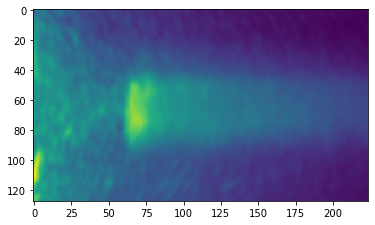

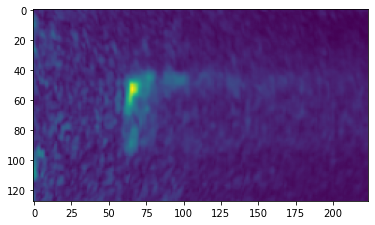

In [10]:
print(lbl[0])
plt.subplots()
plt.imshow(img[imgnum,0,:,:])
plt.subplots()
plt.imshow(img[imgnum,1,:,:])
print("Data Size =", img.shape)
roi_size = img.shape[2:]
print("ROI Size =", roi_size)

In [11]:
device = torch.device("cuda:"+str(device_num))

def vfold_train(vfold_num, train_loader, val_loader):
    model = DenseNet121(spatial_dims=2, in_channels=2,
                        out_channels=num_classes).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)
    auc_metric = ROCAUCMetric()

    max_epochs = 1000
    val_interval = 2
    
    best_metric = num_classes*100
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    vimages, vlabels = (
                        val_data[0].to(device),
                        val_data[1].to(device),
                    )
                    y_pred = torch.cat([y_pred, model(vimages)], dim=0)
                    y = torch.cat([y, vlabels], dim=0)
                y_onehot = [y_trans(i) for i in decollate_batch(y)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                diff = 0
                for i in range(len(y_onehot)):
                    for c in range(num_classes):
                        diff += (y_onehot[i][c] - y_pred_act[i][c])**2
                result = float(diff)
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if epoch>100 and result <= best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(),
                        model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current SSD: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best SSD: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                    )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_auc_"+str(vfold_num)+".npy", metric_values)

# In[ ]:


for i in range(device_num,num_folds,4):
    vfold_train(i, train_loader[i], val_loader[i])


# In[ ]:

----------
1: epoch 1/1000
1/0, train_loss: 0.7021
2/0, train_loss: 0.6573
3/0, train_loss: 0.6858
4/0, train_loss: 0.6568
1 epoch 1 average loss: 0.6755
----------
1: epoch 2/1000
1/0, train_loss: 0.6748
2/0, train_loss: 0.6392
3/0, train_loss: 0.6731
4/0, train_loss: 0.6288
1 epoch 2 average loss: 0.6540
current epoch: 2 current SSD: 4.0219 current accuracy: 0.3750 best SSD: 200.0000 at epoch: -1
----------
1: epoch 3/1000
1/0, train_loss: 0.6343
2/0, train_loss: 0.6592
3/0, train_loss: 0.6461
4/0, train_loss: 0.6812
1 epoch 3 average loss: 0.6552
----------
1: epoch 4/1000
1/0, train_loss: 0.6650
2/0, train_loss: 0.6254
3/0, train_loss: 0.6383
4/0, train_loss: 0.6672
1 epoch 4 average loss: 0.6490
current epoch: 4 current SSD: 3.7150 current accuracy: 0.6250 best SSD: 200.0000 at epoch: -1
----------
1: epoch 5/1000
1/0, train_loss: 0.6096
2/0, train_loss: 0.6197
3/0, train_loss: 0.6043
4/0, train_loss: 0.6194
1 epoch 5 average loss: 0.6132
----------
1: epoch 6/1000
1/0, train_loss

4/0, train_loss: 0.3000
1 epoch 41 average loss: 0.3183
----------
1: epoch 42/1000
1/0, train_loss: 0.3353
2/0, train_loss: 0.2337
3/0, train_loss: 0.3493
4/0, train_loss: 0.1947
1 epoch 42 average loss: 0.2782
current epoch: 42 current SSD: 2.6047 current accuracy: 0.8750 best SSD: 200.0000 at epoch: -1
----------
1: epoch 43/1000
1/0, train_loss: 0.2347
2/0, train_loss: 0.3365
3/0, train_loss: 0.3745
4/0, train_loss: 0.2720
1 epoch 43 average loss: 0.3044
----------
1: epoch 44/1000
1/0, train_loss: 0.2792
2/0, train_loss: 0.3240
3/0, train_loss: 0.2376
4/0, train_loss: 0.3139
1 epoch 44 average loss: 0.2887
current epoch: 44 current SSD: 2.5924 current accuracy: 0.8750 best SSD: 200.0000 at epoch: -1
----------
1: epoch 45/1000
1/0, train_loss: 0.3798
2/0, train_loss: 0.3447
3/0, train_loss: 0.2201
4/0, train_loss: 0.2200
1 epoch 45 average loss: 0.2912
----------
1: epoch 46/1000
1/0, train_loss: 0.1879
2/0, train_loss: 0.3139
3/0, train_loss: 0.3585
4/0, train_loss: 0.3487
1 epoc

1/0, train_loss: 0.1367
2/0, train_loss: 0.1780
3/0, train_loss: 0.1039
4/0, train_loss: 0.0807
1 epoch 82 average loss: 0.1248
current epoch: 82 current SSD: 2.0410 current accuracy: 0.7500 best SSD: 200.0000 at epoch: -1
----------
1: epoch 83/1000
1/0, train_loss: 0.1002
2/0, train_loss: 0.1097
3/0, train_loss: 0.1022
4/0, train_loss: 0.1232
1 epoch 83 average loss: 0.1088
----------
1: epoch 84/1000
1/0, train_loss: 0.0614
2/0, train_loss: 0.1632
3/0, train_loss: 0.1871
4/0, train_loss: 0.0853
1 epoch 84 average loss: 0.1243
current epoch: 84 current SSD: 2.2120 current accuracy: 0.7500 best SSD: 200.0000 at epoch: -1
----------
1: epoch 85/1000
1/0, train_loss: 0.1178
2/0, train_loss: 0.1152
3/0, train_loss: 0.1018
4/0, train_loss: 0.2240
1 epoch 85 average loss: 0.1397
----------
1: epoch 86/1000
1/0, train_loss: 0.1042
2/0, train_loss: 0.1224
3/0, train_loss: 0.1323
4/0, train_loss: 0.0875
1 epoch 86 average loss: 0.1116
current epoch: 86 current SSD: 2.1714 current accuracy: 0.

1/0, train_loss: 0.0402
2/0, train_loss: 0.0426
3/0, train_loss: 0.0962
4/0, train_loss: 0.0321
1 epoch 122 average loss: 0.0528
current epoch: 122 current SSD: 4.1211 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 123/1000
1/0, train_loss: 0.0909
2/0, train_loss: 0.0555
3/0, train_loss: 0.0236
4/0, train_loss: 0.0602
1 epoch 123 average loss: 0.0576
----------
1: epoch 124/1000
1/0, train_loss: 0.0461
2/0, train_loss: 0.0858
3/0, train_loss: 0.0339
4/0, train_loss: 0.1024
1 epoch 124 average loss: 0.0670
current epoch: 124 current SSD: 3.6533 current accuracy: 0.6250 best SSD: 2.3493 at epoch: 102
----------
1: epoch 125/1000
1/0, train_loss: 0.0472
2/0, train_loss: 0.0254
3/0, train_loss: 0.0231
4/0, train_loss: 0.0282
1 epoch 125 average loss: 0.0310
----------
1: epoch 126/1000
1/0, train_loss: 0.0297
2/0, train_loss: 0.0433
3/0, train_loss: 0.0352
4/0, train_loss: 0.0777
1 epoch 126 average loss: 0.0465
current epoch: 126 current SSD: 4.1636 current ac

1/0, train_loss: 0.0169
2/0, train_loss: 0.0159
3/0, train_loss: 0.0134
4/0, train_loss: 0.0308
1 epoch 162 average loss: 0.0193
current epoch: 162 current SSD: 4.1477 current accuracy: 0.6250 best SSD: 2.3493 at epoch: 102
----------
1: epoch 163/1000
1/0, train_loss: 0.0276
2/0, train_loss: 0.0130
3/0, train_loss: 0.0149
4/0, train_loss: 0.0102
1 epoch 163 average loss: 0.0164
----------
1: epoch 164/1000
1/0, train_loss: 0.0234
2/0, train_loss: 0.0256
3/0, train_loss: 0.0798
4/0, train_loss: 0.0187
1 epoch 164 average loss: 0.0369
current epoch: 164 current SSD: 3.4425 current accuracy: 0.6250 best SSD: 2.3493 at epoch: 102
----------
1: epoch 165/1000
1/0, train_loss: 0.0128
2/0, train_loss: 0.0274
3/0, train_loss: 0.0481
4/0, train_loss: 0.0209
1 epoch 165 average loss: 0.0273
----------
1: epoch 166/1000
1/0, train_loss: 0.0200
2/0, train_loss: 0.0169
3/0, train_loss: 0.0148
4/0, train_loss: 0.0141
1 epoch 166 average loss: 0.0164
current epoch: 166 current SSD: 3.5736 current ac

1/0, train_loss: 0.0094
2/0, train_loss: 0.0867
3/0, train_loss: 0.0109
4/0, train_loss: 0.0161
1 epoch 202 average loss: 0.0308
current epoch: 202 current SSD: 4.7196 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 203/1000
1/0, train_loss: 0.0117
2/0, train_loss: 0.0212
3/0, train_loss: 0.0163
4/0, train_loss: 0.0193
1 epoch 203 average loss: 0.0171
----------
1: epoch 204/1000
1/0, train_loss: 0.0149
2/0, train_loss: 0.0175
3/0, train_loss: 0.0213
4/0, train_loss: 0.0293
1 epoch 204 average loss: 0.0207
current epoch: 204 current SSD: 5.6786 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 205/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0126
3/0, train_loss: 0.0132
4/0, train_loss: 0.0080
1 epoch 205 average loss: 0.0107
----------
1: epoch 206/1000
1/0, train_loss: 0.0181
2/0, train_loss: 0.0106
3/0, train_loss: 0.0126
4/0, train_loss: 0.0136
1 epoch 206 average loss: 0.0137
current epoch: 206 current SSD: 5.1486 current ac

1/0, train_loss: 0.0090
2/0, train_loss: 0.0067
3/0, train_loss: 0.0098
4/0, train_loss: 0.0054
1 epoch 242 average loss: 0.0077
current epoch: 242 current SSD: 4.7566 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 243/1000
1/0, train_loss: 0.0295
2/0, train_loss: 0.0052
3/0, train_loss: 0.0091
4/0, train_loss: 0.0596
1 epoch 243 average loss: 0.0258
----------
1: epoch 244/1000
1/0, train_loss: 0.0281
2/0, train_loss: 0.0113
3/0, train_loss: 0.0050
4/0, train_loss: 0.0067
1 epoch 244 average loss: 0.0128
current epoch: 244 current SSD: 6.1653 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 245/1000
1/0, train_loss: 0.0054
2/0, train_loss: 0.0155
3/0, train_loss: 0.0050
4/0, train_loss: 0.0079
1 epoch 245 average loss: 0.0085
----------
1: epoch 246/1000
1/0, train_loss: 0.0162
2/0, train_loss: 0.0040
3/0, train_loss: 0.0124
4/0, train_loss: 0.0134
1 epoch 246 average loss: 0.0115
current epoch: 246 current SSD: 5.7834 current ac

1/0, train_loss: 0.0043
2/0, train_loss: 0.0096
3/0, train_loss: 0.0037
4/0, train_loss: 0.0139
1 epoch 282 average loss: 0.0079
current epoch: 282 current SSD: 5.0745 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 283/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0034
3/0, train_loss: 0.0050
4/0, train_loss: 0.0040
1 epoch 283 average loss: 0.0042
----------
1: epoch 284/1000
1/0, train_loss: 0.0062
2/0, train_loss: 0.0043
3/0, train_loss: 0.0034
4/0, train_loss: 0.0127
1 epoch 284 average loss: 0.0066
current epoch: 284 current SSD: 5.2075 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 285/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0029
3/0, train_loss: 0.0104
4/0, train_loss: 0.0049
1 epoch 285 average loss: 0.0056
----------
1: epoch 286/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0043
3/0, train_loss: 0.0033
4/0, train_loss: 0.0078
1 epoch 286 average loss: 0.0046
current epoch: 286 current SSD: 5.0747 current ac

1/0, train_loss: 0.0079
2/0, train_loss: 0.0063
3/0, train_loss: 0.0030
4/0, train_loss: 0.0032
1 epoch 322 average loss: 0.0051
current epoch: 322 current SSD: 5.3583 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 323/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0028
3/0, train_loss: 0.0035
4/0, train_loss: 0.0030
1 epoch 323 average loss: 0.0032
----------
1: epoch 324/1000
1/0, train_loss: 0.0070
2/0, train_loss: 0.0031
3/0, train_loss: 0.0081
4/0, train_loss: 0.0074
1 epoch 324 average loss: 0.0064
current epoch: 324 current SSD: 5.5287 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 325/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0041
3/0, train_loss: 0.0028
4/0, train_loss: 0.0032
1 epoch 325 average loss: 0.0035
----------
1: epoch 326/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0036
3/0, train_loss: 0.0038
4/0, train_loss: 0.0104
1 epoch 326 average loss: 0.0053
current epoch: 326 current SSD: 5.5225 current ac

1/0, train_loss: 0.0041
2/0, train_loss: 0.0036
3/0, train_loss: 0.0063
4/0, train_loss: 0.0029
1 epoch 362 average loss: 0.0042
current epoch: 362 current SSD: 4.8197 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 363/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0041
3/0, train_loss: 0.0038
4/0, train_loss: 0.0028
1 epoch 363 average loss: 0.0035
----------
1: epoch 364/1000
1/0, train_loss: 0.0049
2/0, train_loss: 0.0117
3/0, train_loss: 0.0027
4/0, train_loss: 0.0040
1 epoch 364 average loss: 0.0058
current epoch: 364 current SSD: 4.8396 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 365/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0023
3/0, train_loss: 0.0021
4/0, train_loss: 0.0027
1 epoch 365 average loss: 0.0026
----------
1: epoch 366/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0023
3/0, train_loss: 0.0018
4/0, train_loss: 0.0068
1 epoch 366 average loss: 0.0041
current epoch: 366 current SSD: 4.6857 current ac

1/0, train_loss: 0.0016
2/0, train_loss: 0.0027
3/0, train_loss: 0.0065
4/0, train_loss: 0.0045
1 epoch 402 average loss: 0.0038
current epoch: 402 current SSD: 4.7102 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 403/1000
1/0, train_loss: 0.0024
2/0, train_loss: 0.0203
3/0, train_loss: 0.0133
4/0, train_loss: 0.0019
1 epoch 403 average loss: 0.0095
----------
1: epoch 404/1000
1/0, train_loss: 0.0137
2/0, train_loss: 0.0014
3/0, train_loss: 0.0076
4/0, train_loss: 0.0024
1 epoch 404 average loss: 0.0063
current epoch: 404 current SSD: 3.9429 current accuracy: 0.6250 best SSD: 2.3493 at epoch: 102
----------
1: epoch 405/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0035
3/0, train_loss: 0.0030
4/0, train_loss: 0.0829
1 epoch 405 average loss: 0.0228
----------
1: epoch 406/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0018
3/0, train_loss: 0.0029
4/0, train_loss: 0.0049
1 epoch 406 average loss: 0.0034
current epoch: 406 current SSD: 5.1819 current ac

1/0, train_loss: 0.0023
2/0, train_loss: 0.0023
3/0, train_loss: 0.0023
4/0, train_loss: 0.0036
1 epoch 442 average loss: 0.0026
current epoch: 442 current SSD: 5.3634 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 443/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0043
3/0, train_loss: 0.0018
4/0, train_loss: 0.0020
1 epoch 443 average loss: 0.0035
----------
1: epoch 444/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0016
3/0, train_loss: 0.0092
4/0, train_loss: 0.0031
1 epoch 444 average loss: 0.0042
current epoch: 444 current SSD: 4.7676 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 445/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0009
3/0, train_loss: 0.0011
4/0, train_loss: 0.0146
1 epoch 445 average loss: 0.0055
----------
1: epoch 446/1000
1/0, train_loss: 0.0036
2/0, train_loss: 0.0262
3/0, train_loss: 0.0015
4/0, train_loss: 0.0033
1 epoch 446 average loss: 0.0086
current epoch: 446 current SSD: 4.1877 current ac

1/0, train_loss: 0.0021
2/0, train_loss: 0.0075
3/0, train_loss: 0.0021
4/0, train_loss: 0.0011
1 epoch 482 average loss: 0.0032
current epoch: 482 current SSD: 4.9846 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 483/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0021
3/0, train_loss: 0.0013
4/0, train_loss: 0.0013
1 epoch 483 average loss: 0.0015
----------
1: epoch 484/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0036
3/0, train_loss: 0.0017
4/0, train_loss: 0.0028
1 epoch 484 average loss: 0.0043
current epoch: 484 current SSD: 5.3527 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 485/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0011
1 epoch 485 average loss: 0.0012
----------
1: epoch 486/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0010
3/0, train_loss: 0.0011
4/0, train_loss: 0.0071
1 epoch 486 average loss: 0.0028
current epoch: 486 current SSD: 4.9148 current ac

1/0, train_loss: 0.0016
2/0, train_loss: 0.0012
3/0, train_loss: 0.0030
4/0, train_loss: 0.0016
1 epoch 522 average loss: 0.0019
current epoch: 522 current SSD: 5.7914 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 523/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0010
3/0, train_loss: 0.0010
4/0, train_loss: 0.0029
1 epoch 523 average loss: 0.0015
----------
1: epoch 524/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0015
3/0, train_loss: 0.0009
4/0, train_loss: 0.0009
1 epoch 524 average loss: 0.0011
current epoch: 524 current SSD: 5.6169 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 525/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0014
3/0, train_loss: 0.0009
4/0, train_loss: 0.0008
1 epoch 525 average loss: 0.0010
----------
1: epoch 526/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0008
3/0, train_loss: 0.0011
4/0, train_loss: 0.0014
1 epoch 526 average loss: 0.0011
current epoch: 526 current SSD: 5.5342 current ac

1/0, train_loss: 0.0015
2/0, train_loss: 0.0008
3/0, train_loss: 0.0017
4/0, train_loss: 0.0008
1 epoch 562 average loss: 0.0012
current epoch: 562 current SSD: 5.8666 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 563/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0032
3/0, train_loss: 0.0008
4/0, train_loss: 0.0016
1 epoch 563 average loss: 0.0015
----------
1: epoch 564/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0009
3/0, train_loss: 0.0007
4/0, train_loss: 0.0009
1 epoch 564 average loss: 0.0010
current epoch: 564 current SSD: 5.6711 current accuracy: 0.5000 best SSD: 2.3493 at epoch: 102
----------
1: epoch 565/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0009
3/0, train_loss: 0.0012
4/0, train_loss: 0.0041
1 epoch 565 average loss: 0.0019
----------
1: epoch 566/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0010
4/0, train_loss: 0.0009
1 epoch 566 average loss: 0.0009
current epoch: 566 current SSD: 5.7463 current ac

1/0, train_loss: 0.0071
2/0, train_loss: 0.0018
3/0, train_loss: 0.0070
4/0, train_loss: 0.0017
1 epoch 602 average loss: 0.0044
current epoch: 602 current SSD: 4.9593 current accuracy: 0.6250 best SSD: 2.3493 at epoch: 102
----------
1: epoch 603/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0010
3/0, train_loss: 0.0019
4/0, train_loss: 0.0022
1 epoch 603 average loss: 0.0015
----------
1: epoch 604/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train_loss: 0.0011
1 epoch 604 average loss: 0.0010
current epoch: 604 current SSD: 4.0782 current accuracy: 0.6250 best SSD: 2.3493 at epoch: 102
----------
1: epoch 605/1000
1/0, train_loss: 0.0345
2/0, train_loss: 0.0019
3/0, train_loss: 0.0009
4/0, train_loss: 0.0044
1 epoch 605 average loss: 0.0104
----------
1: epoch 606/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0014
3/0, train_loss: 0.0026
4/0, train_loss: 0.0013
1 epoch 606 average loss: 0.0015
current epoch: 606 current SSD: 2.7372 current ac

1/0, train_loss: 0.0005
2/0, train_loss: 0.0035
3/0, train_loss: 0.0017
4/0, train_loss: 0.0005
1 epoch 642 average loss: 0.0015
current epoch: 642 current SSD: 5.7422 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 643/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0012
3/0, train_loss: 0.0016
4/0, train_loss: 0.0007
1 epoch 643 average loss: 0.0010
----------
1: epoch 644/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0006
3/0, train_loss: 0.0029
4/0, train_loss: 0.0041
1 epoch 644 average loss: 0.0021
current epoch: 644 current SSD: 5.8278 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 645/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0017
3/0, train_loss: 0.0009
4/0, train_loss: 0.0040
1 epoch 645 average loss: 0.0019
----------
1: epoch 646/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0103
3/0, train_loss: 0.0006
4/0, train_loss: 0.0016
1 epoch 646 average loss: 0.0034
current epoch: 646 current SSD: 5.7089 current ac

1/0, train_loss: 0.0005
2/0, train_loss: 0.0034
3/0, train_loss: 0.0006
4/0, train_loss: 0.0034
1 epoch 682 average loss: 0.0019
current epoch: 682 current SSD: 4.3830 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 683/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0006
3/0, train_loss: 0.0010
4/0, train_loss: 0.0005
1 epoch 683 average loss: 0.0007
----------
1: epoch 684/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0008
3/0, train_loss: 0.0012
4/0, train_loss: 0.0038
1 epoch 684 average loss: 0.0018
current epoch: 684 current SSD: 4.6346 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 685/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0013
3/0, train_loss: 0.0006
4/0, train_loss: 0.0006
1 epoch 685 average loss: 0.0013
----------
1: epoch 686/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0009
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
1 epoch 686 average loss: 0.0008
current epoch: 686 current SSD: 5.4009 current ac

1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0008
4/0, train_loss: 0.0005
1 epoch 722 average loss: 0.0006
current epoch: 722 current SSD: 6.5456 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 723/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0004
4/0, train_loss: 0.0010
1 epoch 723 average loss: 0.0006
----------
1: epoch 724/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0009
1 epoch 724 average loss: 0.0006
current epoch: 724 current SSD: 6.5660 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 725/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
1 epoch 725 average loss: 0.0005
----------
1: epoch 726/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0015
4/0, train_loss: 0.0014
1 epoch 726 average loss: 0.0009
current epoch: 726 current SSD: 6.4634 current ac

1/0, train_loss: 0.0008
2/0, train_loss: 0.0028
3/0, train_loss: 0.0008
4/0, train_loss: 0.0006
1 epoch 762 average loss: 0.0012
current epoch: 762 current SSD: 5.8181 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 763/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0007
3/0, train_loss: 0.0002
4/0, train_loss: 0.0009
1 epoch 763 average loss: 0.0008
----------
1: epoch 764/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0008
1 epoch 764 average loss: 0.0008
current epoch: 764 current SSD: 5.4372 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 765/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0010
1 epoch 765 average loss: 0.0008
----------
1: epoch 766/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0015
1 epoch 766 average loss: 0.0008
current epoch: 766 current SSD: 5.5154 current ac

1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0093
1 epoch 802 average loss: 0.0026
current epoch: 802 current SSD: 5.7003 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 803/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0006
3/0, train_loss: 0.0016
4/0, train_loss: 0.0012
1 epoch 803 average loss: 0.0009
----------
1: epoch 804/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0004
3/0, train_loss: 0.0135
4/0, train_loss: 0.0013
1 epoch 804 average loss: 0.0041
current epoch: 804 current SSD: 5.1229 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 805/1000
1/0, train_loss: 0.0114
2/0, train_loss: 0.0009
3/0, train_loss: 0.0109
4/0, train_loss: 0.0006
1 epoch 805 average loss: 0.0060
----------
1: epoch 806/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0048
4/0, train_loss: 0.0006
1 epoch 806 average loss: 0.0018
current epoch: 806 current SSD: 5.5247 current ac

1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0003
1 epoch 842 average loss: 0.0004
current epoch: 842 current SSD: 5.8966 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 843/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0005
1 epoch 843 average loss: 0.0005
----------
1: epoch 844/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0005
3/0, train_loss: 0.0006
4/0, train_loss: 0.0003
1 epoch 844 average loss: 0.0005
current epoch: 844 current SSD: 6.0021 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 845/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0011
4/0, train_loss: 0.0010
1 epoch 845 average loss: 0.0007
----------
1: epoch 846/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0008
3/0, train_loss: 0.0014
4/0, train_loss: 0.0006
1 epoch 846 average loss: 0.0008
current epoch: 846 current SSD: 6.0549 current ac

1/0, train_loss: 0.0002
2/0, train_loss: 0.0002
3/0, train_loss: 0.0006
4/0, train_loss: 0.0003
1 epoch 882 average loss: 0.0004
current epoch: 882 current SSD: 4.8479 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 883/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0006
3/0, train_loss: 0.0002
4/0, train_loss: 0.0004
1 epoch 883 average loss: 0.0005
----------
1: epoch 884/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
1 epoch 884 average loss: 0.0003
current epoch: 884 current SSD: 5.1577 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 885/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0003
3/0, train_loss: 0.0013
4/0, train_loss: 0.0007
1 epoch 885 average loss: 0.0009
----------
1: epoch 886/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0003
3/0, train_loss: 0.0017
4/0, train_loss: 0.0046
1 epoch 886 average loss: 0.0017
current epoch: 886 current SSD: 5.4266 current ac

1/0, train_loss: 0.0011
2/0, train_loss: 0.0017
3/0, train_loss: 0.0004
4/0, train_loss: 0.0013
1 epoch 922 average loss: 0.0011
current epoch: 922 current SSD: 4.5962 current accuracy: 0.6250 best SSD: 1.4487 at epoch: 614
----------
1: epoch 923/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0013
3/0, train_loss: 0.0011
4/0, train_loss: 0.0002
1 epoch 923 average loss: 0.0007
----------
1: epoch 924/1000
1/0, train_loss: 0.0047
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0033
1 epoch 924 average loss: 0.0023
current epoch: 924 current SSD: 5.2944 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 925/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0007
3/0, train_loss: 0.0003
4/0, train_loss: 0.0013
1 epoch 925 average loss: 0.0013
----------
1: epoch 926/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0004
1 epoch 926 average loss: 0.0004
current epoch: 926 current SSD: 6.0058 current ac

1/0, train_loss: 0.0070
2/0, train_loss: 0.0003
3/0, train_loss: 0.0020
4/0, train_loss: 0.0002
1 epoch 962 average loss: 0.0024
current epoch: 962 current SSD: 5.8412 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 963/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0008
3/0, train_loss: 0.0276
4/0, train_loss: 0.0003
1 epoch 963 average loss: 0.0073
----------
1: epoch 964/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0011
3/0, train_loss: 0.0005
4/0, train_loss: 0.0096
1 epoch 964 average loss: 0.0029
current epoch: 964 current SSD: 5.3911 current accuracy: 0.5000 best SSD: 1.4487 at epoch: 614
----------
1: epoch 965/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
1 epoch 965 average loss: 0.0004
----------
1: epoch 966/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0004
1 epoch 966 average loss: 0.0004
current epoch: 966 current SSD: 5.3896 current ac

1/0, train_loss: 0.6902
2/0, train_loss: 0.6717
3/0, train_loss: 0.6955
4/0, train_loss: 0.6903
2 epoch 2 average loss: 0.6869
current epoch: 2 current SSD: 4.5531 current accuracy: 0.5556 best SSD: 200.0000 at epoch: -1
----------
2: epoch 3/1000
1/0, train_loss: 0.6783
2/0, train_loss: 0.6508
3/0, train_loss: 0.6873
4/0, train_loss: 0.6675
2 epoch 3 average loss: 0.6710
----------
2: epoch 4/1000
1/0, train_loss: 0.6594
2/0, train_loss: 0.6704
3/0, train_loss: 0.6659
4/0, train_loss: 0.6411
2 epoch 4 average loss: 0.6592
current epoch: 4 current SSD: 4.6527 current accuracy: 0.1111 best SSD: 200.0000 at epoch: -1
----------
2: epoch 5/1000
1/0, train_loss: 0.6500
2/0, train_loss: 0.6412
3/0, train_loss: 0.6281
4/0, train_loss: 0.6437
2 epoch 5 average loss: 0.6407
----------
2: epoch 6/1000
1/0, train_loss: 0.6285
2/0, train_loss: 0.6039
3/0, train_loss: 0.6440
4/0, train_loss: 0.6656
2 epoch 6 average loss: 0.6355
current epoch: 6 current SSD: 4.5741 current accuracy: 0.4444 best SS

4/0, train_loss: 0.2621
2 epoch 42 average loss: 0.3139
current epoch: 42 current SSD: 3.1587 current accuracy: 0.8889 best SSD: 200.0000 at epoch: -1
----------
2: epoch 43/1000
1/0, train_loss: 0.4229
2/0, train_loss: 0.2921
3/0, train_loss: 0.3127
4/0, train_loss: 0.2895
2 epoch 43 average loss: 0.3293
----------
2: epoch 44/1000
1/0, train_loss: 0.3167
2/0, train_loss: 0.2813
3/0, train_loss: 0.2546
4/0, train_loss: 0.4015
2 epoch 44 average loss: 0.3135
current epoch: 44 current SSD: 3.2308 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
2: epoch 45/1000
1/0, train_loss: 0.2928
2/0, train_loss: 0.4145
3/0, train_loss: 0.3044
4/0, train_loss: 0.3871
2 epoch 45 average loss: 0.3497
----------
2: epoch 46/1000
1/0, train_loss: 0.2719
2/0, train_loss: 0.4145
3/0, train_loss: 0.3041
4/0, train_loss: 0.3484
2 epoch 46 average loss: 0.3347
current epoch: 46 current SSD: 3.2056 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
2: epoch 47/1000
1/0, tr

current epoch: 82 current SSD: 3.0093 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
2: epoch 83/1000
1/0, train_loss: 0.1375
2/0, train_loss: 0.1850
3/0, train_loss: 0.1309
4/0, train_loss: 0.1754
2 epoch 83 average loss: 0.1572
----------
2: epoch 84/1000
1/0, train_loss: 0.1579
2/0, train_loss: 0.1436
3/0, train_loss: 0.1038
4/0, train_loss: 0.1625
2 epoch 84 average loss: 0.1420
current epoch: 84 current SSD: 3.1548 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
2: epoch 85/1000
1/0, train_loss: 0.1081
2/0, train_loss: 0.0971
3/0, train_loss: 0.1466
4/0, train_loss: 0.1323
2 epoch 85 average loss: 0.1210
----------
2: epoch 86/1000
1/0, train_loss: 0.1122
2/0, train_loss: 0.2070
3/0, train_loss: 0.1041
4/0, train_loss: 0.1248
2 epoch 86 average loss: 0.1370
current epoch: 86 current SSD: 3.3322 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
2: epoch 87/1000
1/0, train_loss: 0.1173
2/0, train_loss: 0.1438
3/0, train_loss

4/0, train_loss: 0.0498
2 epoch 122 average loss: 0.0575
current epoch: 122 current SSD: 3.6043 current accuracy: 0.7778 best SSD: 3.3602 at epoch: 112
----------
2: epoch 123/1000
1/0, train_loss: 0.0309
2/0, train_loss: 0.0504
3/0, train_loss: 0.0278
4/0, train_loss: 0.0344
2 epoch 123 average loss: 0.0359
----------
2: epoch 124/1000
1/0, train_loss: 0.0403
2/0, train_loss: 0.0560
3/0, train_loss: 0.0331
4/0, train_loss: 0.0935
2 epoch 124 average loss: 0.0557
current epoch: 124 current SSD: 3.7469 current accuracy: 0.7778 best SSD: 3.3602 at epoch: 112
----------
2: epoch 125/1000
1/0, train_loss: 0.0584
2/0, train_loss: 0.0413
3/0, train_loss: 0.0377
4/0, train_loss: 0.0964
2 epoch 125 average loss: 0.0585
----------
2: epoch 126/1000
1/0, train_loss: 0.1354
2/0, train_loss: 0.0444
3/0, train_loss: 0.0426
4/0, train_loss: 0.0553
2 epoch 126 average loss: 0.0694
current epoch: 126 current SSD: 3.9028 current accuracy: 0.7778 best SSD: 3.3602 at epoch: 112
----------
2: epoch 127/10

4/0, train_loss: 0.0165
2 epoch 162 average loss: 0.0177
current epoch: 162 current SSD: 3.9709 current accuracy: 0.7778 best SSD: 3.3602 at epoch: 112
----------
2: epoch 163/1000
1/0, train_loss: 0.0224
2/0, train_loss: 0.0161
3/0, train_loss: 0.0139
4/0, train_loss: 0.0148
2 epoch 163 average loss: 0.0168
----------
2: epoch 164/1000
1/0, train_loss: 0.0461
2/0, train_loss: 0.0144
3/0, train_loss: 0.0119
4/0, train_loss: 0.0347
2 epoch 164 average loss: 0.0268
current epoch: 164 current SSD: 4.0178 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 165/1000
1/0, train_loss: 0.0281
2/0, train_loss: 0.0156
3/0, train_loss: 0.0188
4/0, train_loss: 0.0177
2 epoch 165 average loss: 0.0201
----------
2: epoch 166/1000
1/0, train_loss: 0.0232
2/0, train_loss: 0.0338
3/0, train_loss: 0.0209
4/0, train_loss: 0.0145
2 epoch 166 average loss: 0.0231
current epoch: 166 current SSD: 4.2483 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 167/10

4/0, train_loss: 0.0097
2 epoch 202 average loss: 0.0131
current epoch: 202 current SSD: 4.2319 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 203/1000
1/0, train_loss: 0.0082
2/0, train_loss: 0.0151
3/0, train_loss: 0.0381
4/0, train_loss: 0.0174
2 epoch 203 average loss: 0.0197
----------
2: epoch 204/1000
1/0, train_loss: 0.0261
2/0, train_loss: 0.0238
3/0, train_loss: 0.0086
4/0, train_loss: 0.0136
2 epoch 204 average loss: 0.0180
current epoch: 204 current SSD: 4.3317 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 205/1000
1/0, train_loss: 0.0180
2/0, train_loss: 0.0216
3/0, train_loss: 0.0217
4/0, train_loss: 0.0173
2 epoch 205 average loss: 0.0196
----------
2: epoch 206/1000
1/0, train_loss: 0.0108
2/0, train_loss: 0.0290
3/0, train_loss: 0.0321
4/0, train_loss: 0.0094
2 epoch 206 average loss: 0.0203
current epoch: 206 current SSD: 4.2668 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 207/10

4/0, train_loss: 0.0120
2 epoch 242 average loss: 0.0161
current epoch: 242 current SSD: 4.9446 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 243/1000
1/0, train_loss: 0.0073
2/0, train_loss: 0.0073
3/0, train_loss: 0.0098
4/0, train_loss: 0.0057
2 epoch 243 average loss: 0.0075
----------
2: epoch 244/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0169
3/0, train_loss: 0.0114
4/0, train_loss: 0.0056
2 epoch 244 average loss: 0.0098
current epoch: 244 current SSD: 4.6757 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 245/1000
1/0, train_loss: 0.0073
2/0, train_loss: 0.0066
3/0, train_loss: 0.0061
4/0, train_loss: 0.0123
2 epoch 245 average loss: 0.0081
----------
2: epoch 246/1000
1/0, train_loss: 0.0100
2/0, train_loss: 0.0064
3/0, train_loss: 0.0191
4/0, train_loss: 0.0058
2 epoch 246 average loss: 0.0103
current epoch: 246 current SSD: 4.4827 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 247/10

4/0, train_loss: 0.0094
2 epoch 282 average loss: 0.0057
current epoch: 282 current SSD: 4.5131 current accuracy: 0.7778 best SSD: 3.3602 at epoch: 112
----------
2: epoch 283/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0069
3/0, train_loss: 0.0174
4/0, train_loss: 0.0081
2 epoch 283 average loss: 0.0089
----------
2: epoch 284/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0081
3/0, train_loss: 0.0070
4/0, train_loss: 0.0075
2 epoch 284 average loss: 0.0070
current epoch: 284 current SSD: 4.6698 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 285/1000
1/0, train_loss: 0.0046
2/0, train_loss: 0.0058
3/0, train_loss: 0.0126
4/0, train_loss: 0.0051
2 epoch 285 average loss: 0.0070
----------
2: epoch 286/1000
1/0, train_loss: 0.0206
2/0, train_loss: 0.0082
3/0, train_loss: 0.0045
4/0, train_loss: 0.0036
2 epoch 286 average loss: 0.0092
current epoch: 286 current SSD: 4.6572 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 287/10

4/0, train_loss: 0.0091
2 epoch 322 average loss: 0.0060
current epoch: 322 current SSD: 4.6059 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 323/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0032
3/0, train_loss: 0.0038
4/0, train_loss: 0.0031
2 epoch 323 average loss: 0.0035
----------
2: epoch 324/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0066
3/0, train_loss: 0.0029
4/0, train_loss: 0.0033
2 epoch 324 average loss: 0.0042
current epoch: 324 current SSD: 4.6020 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 325/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0044
3/0, train_loss: 0.0061
4/0, train_loss: 0.0037
2 epoch 325 average loss: 0.0041
----------
2: epoch 326/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0031
3/0, train_loss: 0.0034
4/0, train_loss: 0.0035
2 epoch 326 average loss: 0.0036
current epoch: 326 current SSD: 4.6349 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 327/10

4/0, train_loss: 0.0019
2 epoch 362 average loss: 0.0075
current epoch: 362 current SSD: 4.7640 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 363/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0019
3/0, train_loss: 0.0101
4/0, train_loss: 0.0170
2 epoch 363 average loss: 0.0080
----------
2: epoch 364/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0029
3/0, train_loss: 0.0074
4/0, train_loss: 0.0049
2 epoch 364 average loss: 0.0045
current epoch: 364 current SSD: 4.6183 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 365/1000
1/0, train_loss: 0.0076
2/0, train_loss: 0.0021
3/0, train_loss: 0.0045
4/0, train_loss: 0.0048
2 epoch 365 average loss: 0.0047
----------
2: epoch 366/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0057
3/0, train_loss: 0.0079
4/0, train_loss: 0.0028
2 epoch 366 average loss: 0.0047
current epoch: 366 current SSD: 4.6176 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 367/10

4/0, train_loss: 0.0150
2 epoch 402 average loss: 0.0078
current epoch: 402 current SSD: 4.5912 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 403/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0045
3/0, train_loss: 0.0019
4/0, train_loss: 0.0072
2 epoch 403 average loss: 0.0044
----------
2: epoch 404/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0020
3/0, train_loss: 0.0014
4/0, train_loss: 0.0025
2 epoch 404 average loss: 0.0021
current epoch: 404 current SSD: 4.6697 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 405/1000
1/0, train_loss: 0.0082
2/0, train_loss: 0.0100
3/0, train_loss: 0.0038
4/0, train_loss: 0.0023
2 epoch 405 average loss: 0.0061
----------
2: epoch 406/1000
1/0, train_loss: 0.0102
2/0, train_loss: 0.0208
3/0, train_loss: 0.0051
4/0, train_loss: 0.0024
2 epoch 406 average loss: 0.0096
current epoch: 406 current SSD: 4.9427 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 407/10

4/0, train_loss: 0.0025
2 epoch 442 average loss: 0.0029
current epoch: 442 current SSD: 5.1784 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 443/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0040
3/0, train_loss: 0.0021
4/0, train_loss: 0.0036
2 epoch 443 average loss: 0.0028
----------
2: epoch 444/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0014
3/0, train_loss: 0.0014
4/0, train_loss: 0.0011
2 epoch 444 average loss: 0.0013
current epoch: 444 current SSD: 5.0661 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 445/1000
1/0, train_loss: 0.0061
2/0, train_loss: 0.0014
3/0, train_loss: 0.0163
4/0, train_loss: 0.0010
2 epoch 445 average loss: 0.0062
----------
2: epoch 446/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0013
3/0, train_loss: 0.0018
4/0, train_loss: 0.0015
2 epoch 446 average loss: 0.0015
current epoch: 446 current SSD: 4.7882 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 447/10

4/0, train_loss: 0.0022
2 epoch 482 average loss: 0.0024
current epoch: 482 current SSD: 4.6852 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 483/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0014
3/0, train_loss: 0.0014
4/0, train_loss: 0.0015
2 epoch 483 average loss: 0.0015
----------
2: epoch 484/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0011
3/0, train_loss: 0.0012
4/0, train_loss: 0.0016
2 epoch 484 average loss: 0.0012
current epoch: 484 current SSD: 4.7025 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 485/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0015
3/0, train_loss: 0.0010
4/0, train_loss: 0.0014
2 epoch 485 average loss: 0.0013
----------
2: epoch 486/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0011
3/0, train_loss: 0.0010
4/0, train_loss: 0.0011
2 epoch 486 average loss: 0.0012
current epoch: 486 current SSD: 4.7161 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 487/10

4/0, train_loss: 0.0012
2 epoch 522 average loss: 0.0011
current epoch: 522 current SSD: 4.9292 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 523/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0024
3/0, train_loss: 0.0029
4/0, train_loss: 0.0046
2 epoch 523 average loss: 0.0031
----------
2: epoch 524/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0040
3/0, train_loss: 0.0014
4/0, train_loss: 0.0094
2 epoch 524 average loss: 0.0040
current epoch: 524 current SSD: 4.9235 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 525/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0012
3/0, train_loss: 0.0009
4/0, train_loss: 0.0010
2 epoch 525 average loss: 0.0012
----------
2: epoch 526/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0101
3/0, train_loss: 0.0020
4/0, train_loss: 0.0122
2 epoch 526 average loss: 0.0069
current epoch: 526 current SSD: 5.0865 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 527/10

4/0, train_loss: 0.0011
2 epoch 562 average loss: 0.0028
current epoch: 562 current SSD: 5.4540 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 563/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0009
3/0, train_loss: 0.0012
4/0, train_loss: 0.0007
2 epoch 563 average loss: 0.0009
----------
2: epoch 564/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0009
3/0, train_loss: 0.0007
4/0, train_loss: 0.0028
2 epoch 564 average loss: 0.0014
current epoch: 564 current SSD: 4.8493 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 565/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0010
3/0, train_loss: 0.0013
4/0, train_loss: 0.0010
2 epoch 565 average loss: 0.0013
----------
2: epoch 566/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0011
3/0, train_loss: 0.0007
4/0, train_loss: 0.0008
2 epoch 566 average loss: 0.0010
current epoch: 566 current SSD: 4.7421 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 567/10

4/0, train_loss: 0.0006
2 epoch 602 average loss: 0.0015
current epoch: 602 current SSD: 5.1077 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 603/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0018
3/0, train_loss: 0.0008
4/0, train_loss: 0.0017
2 epoch 603 average loss: 0.0014
----------
2: epoch 604/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0007
3/0, train_loss: 0.0030
4/0, train_loss: 0.0011
2 epoch 604 average loss: 0.0022
current epoch: 604 current SSD: 4.9648 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 605/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0006
3/0, train_loss: 0.0008
4/0, train_loss: 0.0053
2 epoch 605 average loss: 0.0024
----------
2: epoch 606/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0017
3/0, train_loss: 0.0016
4/0, train_loss: 0.0019
2 epoch 606 average loss: 0.0019
current epoch: 606 current SSD: 5.0467 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 607/10

4/0, train_loss: 0.0023
2 epoch 642 average loss: 0.0033
current epoch: 642 current SSD: 5.1251 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 643/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0014
3/0, train_loss: 0.0006
4/0, train_loss: 0.0011
2 epoch 643 average loss: 0.0009
----------
2: epoch 644/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0025
3/0, train_loss: 0.0020
4/0, train_loss: 0.0012
2 epoch 644 average loss: 0.0016
current epoch: 644 current SSD: 5.0866 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 645/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0013
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
2 epoch 645 average loss: 0.0007
----------
2: epoch 646/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0005
3/0, train_loss: 0.0007
4/0, train_loss: 0.0073
2 epoch 646 average loss: 0.0025
current epoch: 646 current SSD: 5.0667 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 647/10

4/0, train_loss: 0.0005
2 epoch 682 average loss: 0.0008
current epoch: 682 current SSD: 4.8732 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 683/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0021
3/0, train_loss: 0.0026
4/0, train_loss: 0.0006
2 epoch 683 average loss: 0.0015
----------
2: epoch 684/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0004
3/0, train_loss: 0.0008
4/0, train_loss: 0.0020
2 epoch 684 average loss: 0.0012
current epoch: 684 current SSD: 4.8937 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 685/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0013
4/0, train_loss: 0.0012
2 epoch 685 average loss: 0.0008
----------
2: epoch 686/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0012
2 epoch 686 average loss: 0.0008
current epoch: 686 current SSD: 5.0456 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 687/10

4/0, train_loss: 0.0007
2 epoch 722 average loss: 0.0014
current epoch: 722 current SSD: 4.9908 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 723/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0007
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
2 epoch 723 average loss: 0.0006
----------
2: epoch 724/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0012
4/0, train_loss: 0.0011
2 epoch 724 average loss: 0.0008
current epoch: 724 current SSD: 5.1581 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 725/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0027
3/0, train_loss: 0.0009
4/0, train_loss: 0.0004
2 epoch 725 average loss: 0.0011
----------
2: epoch 726/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0006
2 epoch 726 average loss: 0.0004
current epoch: 726 current SSD: 4.9962 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 727/10

4/0, train_loss: 0.0007
2 epoch 762 average loss: 0.0007
current epoch: 762 current SSD: 5.4795 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 763/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0011
3/0, train_loss: 0.0003
4/0, train_loss: 0.0004
2 epoch 763 average loss: 0.0006
----------
2: epoch 764/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0035
3/0, train_loss: 0.0004
4/0, train_loss: 0.0076
2 epoch 764 average loss: 0.0030
current epoch: 764 current SSD: 5.1841 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 765/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0006
3/0, train_loss: 0.0019
4/0, train_loss: 0.0009
2 epoch 765 average loss: 0.0016
----------
2: epoch 766/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0005
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
2 epoch 766 average loss: 0.0008
current epoch: 766 current SSD: 5.1815 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 767/10

4/0, train_loss: 0.0005
2 epoch 802 average loss: 0.0011
current epoch: 802 current SSD: 6.2335 current accuracy: 0.5556 best SSD: 3.3602 at epoch: 112
----------
2: epoch 803/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0012
3/0, train_loss: 0.0008
4/0, train_loss: 0.0009
2 epoch 803 average loss: 0.0013
----------
2: epoch 804/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0013
3/0, train_loss: 0.0144
4/0, train_loss: 0.0054
2 epoch 804 average loss: 0.0054
current epoch: 804 current SSD: 5.7641 current accuracy: 0.5556 best SSD: 3.3602 at epoch: 112
----------
2: epoch 805/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0010
4/0, train_loss: 0.0008
2 epoch 805 average loss: 0.0007
----------
2: epoch 806/1000
1/0, train_loss: 0.0114
2/0, train_loss: 0.0004
3/0, train_loss: 0.0024
4/0, train_loss: 0.0009
2 epoch 806 average loss: 0.0038
current epoch: 806 current SSD: 5.4394 current accuracy: 0.4444 best SSD: 3.3602 at epoch: 112
----------
2: epoch 807/10

4/0, train_loss: 0.0013
2 epoch 842 average loss: 0.0008
current epoch: 842 current SSD: 5.4680 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 843/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0007
3/0, train_loss: 0.0005
4/0, train_loss: 0.0027
2 epoch 843 average loss: 0.0011
----------
2: epoch 844/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0018
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
2 epoch 844 average loss: 0.0014
current epoch: 844 current SSD: 5.2970 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 845/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0006
3/0, train_loss: 0.0013
4/0, train_loss: 0.0164
2 epoch 845 average loss: 0.0047
----------
2: epoch 846/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0013
3/0, train_loss: 0.0037
4/0, train_loss: 0.0008
2 epoch 846 average loss: 0.0015
current epoch: 846 current SSD: 5.3549 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 847/10

4/0, train_loss: 0.0245
2 epoch 882 average loss: 0.0079
current epoch: 882 current SSD: 4.6515 current accuracy: 0.7778 best SSD: 3.3602 at epoch: 112
----------
2: epoch 883/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0185
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
2 epoch 883 average loss: 0.0055
----------
2: epoch 884/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0011
3/0, train_loss: 0.0005
4/0, train_loss: 0.0015
2 epoch 884 average loss: 0.0010
current epoch: 884 current SSD: 4.6024 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 885/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0013
2 epoch 885 average loss: 0.0012
----------
2: epoch 886/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0012
3/0, train_loss: 0.0019
4/0, train_loss: 0.0023
2 epoch 886 average loss: 0.0017
current epoch: 886 current SSD: 4.6682 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 887/10

4/0, train_loss: 0.0006
2 epoch 922 average loss: 0.0010
current epoch: 922 current SSD: 5.6756 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 923/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0003
3/0, train_loss: 0.0113
4/0, train_loss: 0.0003
2 epoch 923 average loss: 0.0032
----------
2: epoch 924/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0002
2 epoch 924 average loss: 0.0005
current epoch: 924 current SSD: 5.3052 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 925/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0007
3/0, train_loss: 0.0003
4/0, train_loss: 0.0009
2 epoch 925 average loss: 0.0005
----------
2: epoch 926/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0004
4/0, train_loss: 0.0003
2 epoch 926 average loss: 0.0005
current epoch: 926 current SSD: 5.4466 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 927/10

4/0, train_loss: 0.0002
2 epoch 962 average loss: 0.0002
current epoch: 962 current SSD: 5.3418 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 963/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0002
2 epoch 963 average loss: 0.0003
----------
2: epoch 964/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0003
3/0, train_loss: 0.0017
4/0, train_loss: 0.0004
2 epoch 964 average loss: 0.0010
current epoch: 964 current SSD: 5.3827 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 965/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0002
4/0, train_loss: 0.0006
2 epoch 965 average loss: 0.0003
----------
2: epoch 966/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0002
4/0, train_loss: 0.0003
2 epoch 966 average loss: 0.0002
current epoch: 966 current SSD: 5.2746 current accuracy: 0.6667 best SSD: 3.3602 at epoch: 112
----------
2: epoch 967/10

4/0, train_loss: 0.6951
3 epoch 2 average loss: 0.7116
current epoch: 2 current SSD: 3.4281 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
3: epoch 3/1000
1/0, train_loss: 0.6810
2/0, train_loss: 0.7016
3/0, train_loss: 0.7135
4/0, train_loss: 0.6719
3 epoch 3 average loss: 0.6920
----------
3: epoch 4/1000
1/0, train_loss: 0.6801
2/0, train_loss: 0.6888
3/0, train_loss: 0.6292
4/0, train_loss: 0.6830
3 epoch 4 average loss: 0.6703
current epoch: 4 current SSD: 3.3968 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
3: epoch 5/1000
1/0, train_loss: 0.6582
2/0, train_loss: 0.6621
3/0, train_loss: 0.6704
4/0, train_loss: 0.6480
3 epoch 5 average loss: 0.6597
----------
3: epoch 6/1000
1/0, train_loss: 0.6552
2/0, train_loss: 0.6515
3/0, train_loss: 0.6396
4/0, train_loss: 0.6502
3 epoch 6 average loss: 0.6491
current epoch: 6 current SSD: 3.4398 current accuracy: 0.7143 best SSD: 200.0000 at epoch: -1
----------
3: epoch 7/1000
1/0, train_loss: 0.6

1/0, train_loss: 0.3217
2/0, train_loss: 0.2271
3/0, train_loss: 0.3707
4/0, train_loss: 0.3409
3 epoch 43 average loss: 0.3151
----------
3: epoch 44/1000
1/0, train_loss: 0.3171
2/0, train_loss: 0.3435
3/0, train_loss: 0.3251
4/0, train_loss: 0.3252
3 epoch 44 average loss: 0.3277
current epoch: 44 current SSD: 3.8985 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
3: epoch 45/1000
1/0, train_loss: 0.2795
2/0, train_loss: 0.3418
3/0, train_loss: 0.3199
4/0, train_loss: 0.4583
3 epoch 45 average loss: 0.3499
----------
3: epoch 46/1000
1/0, train_loss: 0.3566
2/0, train_loss: 0.3337
3/0, train_loss: 0.2749
4/0, train_loss: 0.2729
3 epoch 46 average loss: 0.3095
current epoch: 46 current SSD: 4.0922 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
3: epoch 47/1000
1/0, train_loss: 0.3727
2/0, train_loss: 0.2483
3/0, train_loss: 0.2637
4/0, train_loss: 0.3834
3 epoch 47 average loss: 0.3170
----------
3: epoch 48/1000
1/0, train_loss: 0.2853
2/0, t

4/0, train_loss: 0.1621
3 epoch 83 average loss: 0.1709
----------
3: epoch 84/1000
1/0, train_loss: 0.1102
2/0, train_loss: 0.0958
3/0, train_loss: 0.1801
4/0, train_loss: 0.0814
3 epoch 84 average loss: 0.1169
current epoch: 84 current SSD: 4.9799 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
3: epoch 85/1000
1/0, train_loss: 0.2152
2/0, train_loss: 0.1212
3/0, train_loss: 0.0902
4/0, train_loss: 0.1445
3 epoch 85 average loss: 0.1428
----------
3: epoch 86/1000
1/0, train_loss: 0.1353
2/0, train_loss: 0.1126
3/0, train_loss: 0.1167
4/0, train_loss: 0.1080
3 epoch 86 average loss: 0.1181
current epoch: 86 current SSD: 5.4031 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
3: epoch 87/1000
1/0, train_loss: 0.1157
2/0, train_loss: 0.0865
3/0, train_loss: 0.1520
4/0, train_loss: 0.0873
3 epoch 87 average loss: 0.1104
----------
3: epoch 88/1000
1/0, train_loss: 0.1475
2/0, train_loss: 0.0759
3/0, train_loss: 0.1045
4/0, train_loss: 0.0829
3 epoc

1/0, train_loss: 0.0485
2/0, train_loss: 0.1492
3/0, train_loss: 0.0380
4/0, train_loss: 0.0636
3 epoch 123 average loss: 0.0748
----------
3: epoch 124/1000
1/0, train_loss: 0.1487
2/0, train_loss: 0.0458
3/0, train_loss: 0.0408
4/0, train_loss: 0.0337
3 epoch 124 average loss: 0.0673
current epoch: 124 current SSD: 4.8637 current accuracy: 0.5714 best SSD: 4.6846 at epoch: 110
----------
3: epoch 125/1000
1/0, train_loss: 0.0765
2/0, train_loss: 0.0454
3/0, train_loss: 0.0412
4/0, train_loss: 0.0341
3 epoch 125 average loss: 0.0493
----------
3: epoch 126/1000
1/0, train_loss: 0.0379
2/0, train_loss: 0.0554
3/0, train_loss: 0.0316
4/0, train_loss: 0.0595
3 epoch 126 average loss: 0.0461
current epoch: 126 current SSD: 5.4314 current accuracy: 0.5714 best SSD: 4.6846 at epoch: 110
----------
3: epoch 127/1000
1/0, train_loss: 0.0423
2/0, train_loss: 0.1263
3/0, train_loss: 0.0811
4/0, train_loss: 0.0332
3 epoch 127 average loss: 0.0707
----------
3: epoch 128/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0192
2/0, train_loss: 0.0256
3/0, train_loss: 0.0243
4/0, train_loss: 0.0251
3 epoch 163 average loss: 0.0236
----------
3: epoch 164/1000
1/0, train_loss: 0.0216
2/0, train_loss: 0.0246
3/0, train_loss: 0.0200
4/0, train_loss: 0.0146
3 epoch 164 average loss: 0.0202
current epoch: 164 current SSD: 4.5758 current accuracy: 0.5714 best SSD: 4.3721 at epoch: 150
----------
3: epoch 165/1000
1/0, train_loss: 0.0162
2/0, train_loss: 0.0221
3/0, train_loss: 0.0226
4/0, train_loss: 0.0125
3 epoch 165 average loss: 0.0184
----------
3: epoch 166/1000
1/0, train_loss: 0.0210
2/0, train_loss: 0.0267
3/0, train_loss: 0.0272
4/0, train_loss: 0.0157
3 epoch 166 average loss: 0.0227
current epoch: 166 current SSD: 4.8618 current accuracy: 0.5714 best SSD: 4.3721 at epoch: 150
----------
3: epoch 167/1000
1/0, train_loss: 0.0268
2/0, train_loss: 0.0164
3/0, train_loss: 0.0369
4/0, train_loss: 0.0568
3 epoch 167 average loss: 0.0342
----------
3: epoch 168/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0091
2/0, train_loss: 0.0117
3/0, train_loss: 0.0083
4/0, train_loss: 0.0130
3 epoch 203 average loss: 0.0105
----------
3: epoch 204/1000
1/0, train_loss: 0.0184
2/0, train_loss: 0.0187
3/0, train_loss: 0.0094
4/0, train_loss: 0.0076
3 epoch 204 average loss: 0.0135
current epoch: 204 current SSD: 5.0822 current accuracy: 0.5714 best SSD: 4.2599 at epoch: 184
----------
3: epoch 205/1000
1/0, train_loss: 0.0147
2/0, train_loss: 0.0099
3/0, train_loss: 0.0097
4/0, train_loss: 0.0213
3 epoch 205 average loss: 0.0139
----------
3: epoch 206/1000
1/0, train_loss: 0.0112
2/0, train_loss: 0.0148
3/0, train_loss: 0.0107
4/0, train_loss: 0.0125
3 epoch 206 average loss: 0.0123
current epoch: 206 current SSD: 5.0503 current accuracy: 0.5714 best SSD: 4.2599 at epoch: 184
----------
3: epoch 207/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0650
3/0, train_loss: 0.0251
4/0, train_loss: 0.0085
3 epoch 207 average loss: 0.0269
----------
3: epoch 208/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0071
2/0, train_loss: 0.0064
3/0, train_loss: 0.0076
4/0, train_loss: 0.0061
3 epoch 243 average loss: 0.0068
----------
3: epoch 244/1000
1/0, train_loss: 0.0064
2/0, train_loss: 0.0552
3/0, train_loss: 0.0110
4/0, train_loss: 0.0111
3 epoch 244 average loss: 0.0209
current epoch: 244 current SSD: 5.1371 current accuracy: 0.4286 best SSD: 3.5112 at epoch: 214
----------
3: epoch 245/1000
1/0, train_loss: 0.0166
2/0, train_loss: 0.0093
3/0, train_loss: 0.0046
4/0, train_loss: 0.0099
3 epoch 245 average loss: 0.0101
----------
3: epoch 246/1000
1/0, train_loss: 0.0088
2/0, train_loss: 0.0090
3/0, train_loss: 0.0075
4/0, train_loss: 0.0157
3 epoch 246 average loss: 0.0103
current epoch: 246 current SSD: 4.7684 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 247/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0061
3/0, train_loss: 0.0060
4/0, train_loss: 0.0049
3 epoch 247 average loss: 0.0056
----------
3: epoch 248/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0301
2/0, train_loss: 0.0045
3/0, train_loss: 0.0043
4/0, train_loss: 0.1426
3 epoch 283 average loss: 0.0454
----------
3: epoch 284/1000
1/0, train_loss: 0.0257
2/0, train_loss: 0.0118
3/0, train_loss: 0.0133
4/0, train_loss: 0.0088
3 epoch 284 average loss: 0.0149
current epoch: 284 current SSD: 4.7352 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 285/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0469
3/0, train_loss: 0.0121
4/0, train_loss: 0.0080
3 epoch 285 average loss: 0.0178
----------
3: epoch 286/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0124
3/0, train_loss: 0.0069
4/0, train_loss: 0.0045
3 epoch 286 average loss: 0.0077
current epoch: 286 current SSD: 4.2169 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 287/1000
1/0, train_loss: 0.0071
2/0, train_loss: 0.0053
3/0, train_loss: 0.0069
4/0, train_loss: 0.0051
3 epoch 287 average loss: 0.0061
----------
3: epoch 288/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0045
2/0, train_loss: 0.0081
3/0, train_loss: 0.0032
4/0, train_loss: 0.0033
3 epoch 323 average loss: 0.0048
----------
3: epoch 324/1000
1/0, train_loss: 0.0067
2/0, train_loss: 0.0221
3/0, train_loss: 0.0084
4/0, train_loss: 0.0031
3 epoch 324 average loss: 0.0101
current epoch: 324 current SSD: 4.4260 current accuracy: 0.7143 best SSD: 3.5112 at epoch: 214
----------
3: epoch 325/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0034
3/0, train_loss: 0.0041
4/0, train_loss: 0.0054
3 epoch 325 average loss: 0.0040
----------
3: epoch 326/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0036
3/0, train_loss: 0.0097
4/0, train_loss: 0.0680
3 epoch 326 average loss: 0.0211
current epoch: 326 current SSD: 4.6088 current accuracy: 0.7143 best SSD: 3.5112 at epoch: 214
----------
3: epoch 327/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0042
3/0, train_loss: 0.0084
4/0, train_loss: 0.0111
3 epoch 327 average loss: 0.0072
----------
3: epoch 328/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0034
2/0, train_loss: 0.0034
3/0, train_loss: 0.0025
4/0, train_loss: 0.0034
3 epoch 363 average loss: 0.0032
----------
3: epoch 364/1000
1/0, train_loss: 0.0264
2/0, train_loss: 0.0047
3/0, train_loss: 0.0108
4/0, train_loss: 0.0034
3 epoch 364 average loss: 0.0113
current epoch: 364 current SSD: 5.0020 current accuracy: 0.4286 best SSD: 3.5112 at epoch: 214
----------
3: epoch 365/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0033
3/0, train_loss: 0.0032
4/0, train_loss: 0.0034
3 epoch 365 average loss: 0.0038
----------
3: epoch 366/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0105
3/0, train_loss: 0.0028
4/0, train_loss: 0.0060
3 epoch 366 average loss: 0.0055
current epoch: 366 current SSD: 4.8902 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 367/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0039
3/0, train_loss: 0.0087
4/0, train_loss: 0.0024
3 epoch 367 average loss: 0.0044
----------
3: epoch 368/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0091
2/0, train_loss: 0.0032
3/0, train_loss: 0.0079
4/0, train_loss: 0.0023
3 epoch 403 average loss: 0.0057
----------
3: epoch 404/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0100
3/0, train_loss: 0.0019
4/0, train_loss: 0.0070
3 epoch 404 average loss: 0.0056
current epoch: 404 current SSD: 4.8536 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 405/1000
1/0, train_loss: 0.0063
2/0, train_loss: 0.0018
3/0, train_loss: 0.0035
4/0, train_loss: 0.0025
3 epoch 405 average loss: 0.0035
----------
3: epoch 406/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0018
3/0, train_loss: 0.0018
4/0, train_loss: 0.0039
3 epoch 406 average loss: 0.0024
current epoch: 406 current SSD: 4.8625 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 407/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0035
3/0, train_loss: 0.0026
4/0, train_loss: 0.0023
3 epoch 407 average loss: 0.0025
----------
3: epoch 408/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0073
2/0, train_loss: 0.0024
3/0, train_loss: 0.0018
4/0, train_loss: 0.0014
3 epoch 443 average loss: 0.0032
----------
3: epoch 444/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0018
3/0, train_loss: 0.0020
4/0, train_loss: 0.0046
3 epoch 444 average loss: 0.0031
current epoch: 444 current SSD: 4.8203 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 445/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0016
3/0, train_loss: 0.0041
4/0, train_loss: 0.0035
3 epoch 445 average loss: 0.0033
----------
3: epoch 446/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0031
3/0, train_loss: 0.0017
4/0, train_loss: 0.0030
3 epoch 446 average loss: 0.0024
current epoch: 446 current SSD: 4.3536 current accuracy: 0.7143 best SSD: 3.5112 at epoch: 214
----------
3: epoch 447/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0034
3/0, train_loss: 0.0015
4/0, train_loss: 0.0015
3 epoch 447 average loss: 0.0020
----------
3: epoch 448/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0015
2/0, train_loss: 0.0026
3/0, train_loss: 0.0034
4/0, train_loss: 0.0020
3 epoch 483 average loss: 0.0024
----------
3: epoch 484/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0026
3/0, train_loss: 0.0011
4/0, train_loss: 0.0033
3 epoch 484 average loss: 0.0021
current epoch: 484 current SSD: 4.4157 current accuracy: 0.7143 best SSD: 3.5112 at epoch: 214
----------
3: epoch 485/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0026
3/0, train_loss: 0.0011
4/0, train_loss: 0.0023
3 epoch 485 average loss: 0.0018
----------
3: epoch 486/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0014
3/0, train_loss: 0.0016
4/0, train_loss: 0.0011
3 epoch 486 average loss: 0.0017
current epoch: 486 current SSD: 4.4012 current accuracy: 0.7143 best SSD: 3.5112 at epoch: 214
----------
3: epoch 487/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0015
3/0, train_loss: 0.0038
4/0, train_loss: 0.0011
3 epoch 487 average loss: 0.0022
----------
3: epoch 488/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0065
2/0, train_loss: 0.0024
3/0, train_loss: 0.0011
4/0, train_loss: 0.0017
3 epoch 523 average loss: 0.0029
----------
3: epoch 524/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0008
3/0, train_loss: 0.0010
4/0, train_loss: 0.0012
3 epoch 524 average loss: 0.0011
current epoch: 524 current SSD: 4.7407 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 525/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0019
3/0, train_loss: 0.0044
4/0, train_loss: 0.0028
3 epoch 525 average loss: 0.0027
----------
3: epoch 526/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0010
3/0, train_loss: 0.0013
4/0, train_loss: 0.0009
3 epoch 526 average loss: 0.0011
current epoch: 526 current SSD: 5.2618 current accuracy: 0.5714 best SSD: 3.5112 at epoch: 214
----------
3: epoch 527/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0015
3/0, train_loss: 0.0015
4/0, train_loss: 0.0032
3 epoch 527 average loss: 0.0019
----------
3: epoch 528/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0012
2/0, train_loss: 0.0018
3/0, train_loss: 0.0022
4/0, train_loss: 0.0014
3 epoch 563 average loss: 0.0016
----------
3: epoch 564/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0016
3/0, train_loss: 0.0019
4/0, train_loss: 0.0035
3 epoch 564 average loss: 0.0022
current epoch: 564 current SSD: 4.9108 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 565/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0022
3/0, train_loss: 0.0026
4/0, train_loss: 0.0015
3 epoch 565 average loss: 0.0018
----------
3: epoch 566/1000
1/0, train_loss: 0.0136
2/0, train_loss: 0.0009
3/0, train_loss: 0.0197
4/0, train_loss: 0.0014
3 epoch 566 average loss: 0.0089
current epoch: 566 current SSD: 5.1076 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 567/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0022
3/0, train_loss: 0.0014
4/0, train_loss: 0.0008
3 epoch 567 average loss: 0.0013
----------
3: epoch 568/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0013
2/0, train_loss: 0.0019
3/0, train_loss: 0.0010
4/0, train_loss: 0.0009
3 epoch 603 average loss: 0.0013
----------
3: epoch 604/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0011
3/0, train_loss: 0.0033
4/0, train_loss: 0.0011
3 epoch 604 average loss: 0.0017
current epoch: 604 current SSD: 5.5226 current accuracy: 0.4286 best SSD: 2.8647 at epoch: 556
----------
3: epoch 605/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0012
3/0, train_loss: 0.0008
4/0, train_loss: 0.0010
3 epoch 605 average loss: 0.0012
----------
3: epoch 606/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0039
3/0, train_loss: 0.0009
4/0, train_loss: 0.0008
3 epoch 606 average loss: 0.0019
current epoch: 606 current SSD: 5.6039 current accuracy: 0.4286 best SSD: 2.8647 at epoch: 556
----------
3: epoch 607/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0035
3/0, train_loss: 0.0170
4/0, train_loss: 0.0065
3 epoch 607 average loss: 0.0070
----------
3: epoch 608/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0088
2/0, train_loss: 0.0007
3/0, train_loss: 0.0007
4/0, train_loss: 0.0023
3 epoch 643 average loss: 0.0031
----------
3: epoch 644/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0041
3/0, train_loss: 0.0077
4/0, train_loss: 0.0015
3 epoch 644 average loss: 0.0035
current epoch: 644 current SSD: 5.4296 current accuracy: 0.4286 best SSD: 2.8647 at epoch: 556
----------
3: epoch 645/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
3 epoch 645 average loss: 0.0007
----------
3: epoch 646/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0051
3/0, train_loss: 0.0016
4/0, train_loss: 0.0011
3 epoch 646 average loss: 0.0022
current epoch: 646 current SSD: 5.4084 current accuracy: 0.4286 best SSD: 2.8647 at epoch: 556
----------
3: epoch 647/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0008
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
3 epoch 647 average loss: 0.0007
----------
3: epoch 648/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0008
2/0, train_loss: 0.0020
3/0, train_loss: 0.0017
4/0, train_loss: 0.0010
3 epoch 683 average loss: 0.0014
----------
3: epoch 684/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0011
4/0, train_loss: 0.0011
3 epoch 684 average loss: 0.0010
current epoch: 684 current SSD: 4.4446 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 685/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0308
3/0, train_loss: 0.0103
4/0, train_loss: 0.0009
3 epoch 685 average loss: 0.0109
----------
3: epoch 686/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0007
3/0, train_loss: 0.0007
4/0, train_loss: 0.0026
3 epoch 686 average loss: 0.0014
current epoch: 686 current SSD: 3.3309 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 687/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0009
3/0, train_loss: 0.0010
4/0, train_loss: 0.0010
3 epoch 687 average loss: 0.0009
----------
3: epoch 688/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0054
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train_loss: 0.0042
3 epoch 723 average loss: 0.0028
----------
3: epoch 724/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0010
3/0, train_loss: 0.0004
4/0, train_loss: 0.0011
3 epoch 724 average loss: 0.0008
current epoch: 724 current SSD: 4.6295 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 725/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0013
3/0, train_loss: 0.0006
4/0, train_loss: 0.0006
3 epoch 725 average loss: 0.0008
----------
3: epoch 726/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0009
3/0, train_loss: 0.0007
4/0, train_loss: 0.0006
3 epoch 726 average loss: 0.0012
current epoch: 726 current SSD: 4.7691 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 727/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0005
4/0, train_loss: 0.0011
3 epoch 727 average loss: 0.0007
----------
3: epoch 728/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0010
2/0, train_loss: 0.0023
3/0, train_loss: 0.0004
4/0, train_loss: 0.0027
3 epoch 763 average loss: 0.0016
----------
3: epoch 764/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0010
3/0, train_loss: 0.0015
4/0, train_loss: 0.0007
3 epoch 764 average loss: 0.0017
current epoch: 764 current SSD: 4.5965 current accuracy: 0.7143 best SSD: 2.8647 at epoch: 556
----------
3: epoch 765/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0011
3/0, train_loss: 0.0080
4/0, train_loss: 0.0019
3 epoch 765 average loss: 0.0028
----------
3: epoch 766/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0006
3/0, train_loss: 0.0012
4/0, train_loss: 0.0005
3 epoch 766 average loss: 0.0009
current epoch: 766 current SSD: 4.7036 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 767/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0025
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
3 epoch 767 average loss: 0.0010
----------
3: epoch 768/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0011
2/0, train_loss: 0.0035
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
3 epoch 803 average loss: 0.0014
----------
3: epoch 804/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0023
3/0, train_loss: 0.0014
4/0, train_loss: 0.0004
3 epoch 804 average loss: 0.0012
current epoch: 804 current SSD: 4.0251 current accuracy: 0.7143 best SSD: 2.8647 at epoch: 556
----------
3: epoch 805/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
3 epoch 805 average loss: 0.0005
----------
3: epoch 806/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0063
3 epoch 806 average loss: 0.0022
current epoch: 806 current SSD: 4.0557 current accuracy: 0.7143 best SSD: 2.8647 at epoch: 556
----------
3: epoch 807/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0004
3/0, train_loss: 0.0011
4/0, train_loss: 0.0032
3 epoch 807 average loss: 0.0015
----------
3: epoch 808/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0003
3 epoch 843 average loss: 0.0003
----------
3: epoch 844/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0016
3/0, train_loss: 0.0035
4/0, train_loss: 0.0039
3 epoch 844 average loss: 0.0026
current epoch: 844 current SSD: 4.3911 current accuracy: 0.7143 best SSD: 2.8647 at epoch: 556
----------
3: epoch 845/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0015
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
3 epoch 845 average loss: 0.0007
----------
3: epoch 846/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0002
3 epoch 846 average loss: 0.0005
current epoch: 846 current SSD: 4.3970 current accuracy: 0.7143 best SSD: 2.8647 at epoch: 556
----------
3: epoch 847/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
3 epoch 847 average loss: 0.0005
----------
3: epoch 848/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0005
2/0, train_loss: 0.0023
3/0, train_loss: 0.0004
4/0, train_loss: 0.0006
3 epoch 883 average loss: 0.0009
----------
3: epoch 884/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0004
3 epoch 884 average loss: 0.0006
current epoch: 884 current SSD: 4.5695 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 885/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0016
3 epoch 885 average loss: 0.0010
----------
3: epoch 886/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0014
3/0, train_loss: 0.0008
4/0, train_loss: 0.0004
3 epoch 886 average loss: 0.0007
current epoch: 886 current SSD: 4.5397 current accuracy: 0.5714 best SSD: 2.8647 at epoch: 556
----------
3: epoch 887/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0038
4/0, train_loss: 0.0039
3 epoch 887 average loss: 0.0021
----------
3: epoch 888/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0014
4/0, train_loss: 0.0015
3 epoch 923 average loss: 0.0009
----------
3: epoch 924/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0003
3/0, train_loss: 0.0013
4/0, train_loss: 0.0003
3 epoch 924 average loss: 0.0013
current epoch: 924 current SSD: 5.6816 current accuracy: 0.4286 best SSD: 2.3137 at epoch: 898
----------
3: epoch 925/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0005
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
3 epoch 925 average loss: 0.0004
----------
3: epoch 926/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0003
3 epoch 926 average loss: 0.0004
current epoch: 926 current SSD: 5.6938 current accuracy: 0.4286 best SSD: 2.3137 at epoch: 898
----------
3: epoch 927/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0002
3 epoch 927 average loss: 0.0005
----------
3: epoch 928/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0004
2/0, train_loss: 0.0028
3/0, train_loss: 0.0003
4/0, train_loss: 0.0002
3 epoch 963 average loss: 0.0009
----------
3: epoch 964/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0116
4/0, train_loss: 0.0097
3 epoch 964 average loss: 0.0055
current epoch: 964 current SSD: 4.4688 current accuracy: 0.5714 best SSD: 2.3137 at epoch: 898
----------
3: epoch 965/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0003
3/0, train_loss: 0.0021
4/0, train_loss: 0.0003
3 epoch 965 average loss: 0.0016
----------
3: epoch 966/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0005
4/0, train_loss: 0.0013
3 epoch 966 average loss: 0.0006
current epoch: 966 current SSD: 4.9657 current accuracy: 0.5714 best SSD: 2.3137 at epoch: 898
----------
3: epoch 967/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0071
3/0, train_loss: 0.0015
4/0, train_loss: 0.0005
3 epoch 967 average loss: 0.0026
----------
3: epoch 968/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.6729
2/0, train_loss: 0.6625
3/0, train_loss: 0.6752
4/0, train_loss: 0.6607
5/0, train_loss: 0.6242
6 epoch 3 average loss: 0.6591
----------
6: epoch 4/1000
1/0, train_loss: 0.6698
2/0, train_loss: 0.6444
3/0, train_loss: 0.6472
4/0, train_loss: 0.6474
5/0, train_loss: 0.6951
6 epoch 4 average loss: 0.6608
current epoch: 4 current SSD: 2.0649 current accuracy: 0.5000 best SSD: 200.0000 at epoch: -1
----------
6: epoch 5/1000
1/0, train_loss: 0.6421
2/0, train_loss: 0.6363
3/0, train_loss: 0.6436
4/0, train_loss: 0.6360
5/0, train_loss: 0.6432
6 epoch 5 average loss: 0.6402
----------
6: epoch 6/1000
1/0, train_loss: 0.6502
2/0, train_loss: 0.6106
3/0, train_loss: 0.6180
4/0, train_loss: 0.6446
5/0, train_loss: 0.6550
6 epoch 6 average loss: 0.6357
current epoch: 6 current SSD: 2.2454 current accuracy: 0.5000 best SSD: 200.0000 at epoch: -1
----------
6: epoch 7/1000
1/0, train_loss: 0.6044
2/0, train_loss: 0.6069
3/0, train_loss: 0.6240
4/0, train_loss: 0.6429
5/0,

4/0, train_loss: 0.3129
5/0, train_loss: 0.8055
6 epoch 39 average loss: 0.4694
----------
6: epoch 40/1000
1/0, train_loss: 0.5344
2/0, train_loss: 0.3343
3/0, train_loss: 0.3056
4/0, train_loss: 0.4225
5/0, train_loss: 0.2496
6 epoch 40 average loss: 0.3693
current epoch: 40 current SSD: 4.6937 current accuracy: 0.0000 best SSD: 200.0000 at epoch: -1
----------
6: epoch 41/1000
1/0, train_loss: 0.4148
2/0, train_loss: 0.3178
3/0, train_loss: 0.3125
4/0, train_loss: 0.3514
5/0, train_loss: 0.2948
6 epoch 41 average loss: 0.3382
----------
6: epoch 42/1000
1/0, train_loss: 0.3336
2/0, train_loss: 0.3388
3/0, train_loss: 0.2865
4/0, train_loss: 0.4710
5/0, train_loss: 0.7956
6 epoch 42 average loss: 0.4451
current epoch: 42 current SSD: 4.8139 current accuracy: 0.0000 best SSD: 200.0000 at epoch: -1
----------
6: epoch 43/1000
1/0, train_loss: 0.3133
2/0, train_loss: 0.3570
3/0, train_loss: 0.3336
4/0, train_loss: 0.4601
5/0, train_loss: 0.6036
6 epoch 43 average loss: 0.4135
----------

6 epoch 75 average loss: 0.2948
----------
6: epoch 76/1000
1/0, train_loss: 0.2014
2/0, train_loss: 0.1799
3/0, train_loss: 0.2398
4/0, train_loss: 0.3259
5/0, train_loss: 1.0194
6 epoch 76 average loss: 0.3933
current epoch: 76 current SSD: 5.5578 current accuracy: 0.0000 best SSD: 200.0000 at epoch: -1
----------
6: epoch 77/1000
1/0, train_loss: 0.1869
2/0, train_loss: 0.2380
3/0, train_loss: 0.2720
4/0, train_loss: 0.2696
5/0, train_loss: 0.1136
6 epoch 77 average loss: 0.2160
----------
6: epoch 78/1000
1/0, train_loss: 0.3958
2/0, train_loss: 0.2253
3/0, train_loss: 0.1879
4/0, train_loss: 0.2191
5/0, train_loss: 0.2109
6 epoch 78 average loss: 0.2478
current epoch: 78 current SSD: 5.4029 current accuracy: 0.0000 best SSD: 200.0000 at epoch: -1
----------
6: epoch 79/1000
1/0, train_loss: 0.2049
2/0, train_loss: 0.2258
3/0, train_loss: 0.2835
4/0, train_loss: 0.1447
5/0, train_loss: 0.6465
6 epoch 79 average loss: 0.3011
----------
6: epoch 80/1000
1/0, train_loss: 0.1498
2/0, t

3/0, train_loss: 0.1442
4/0, train_loss: 0.0852
5/0, train_loss: 0.0977
6 epoch 111 average loss: 0.1182
----------
6: epoch 112/1000
1/0, train_loss: 0.1368
2/0, train_loss: 0.1169
3/0, train_loss: 0.0917
4/0, train_loss: 0.1554
5/0, train_loss: 0.5780
6 epoch 112 average loss: 0.2157
current epoch: 112 current SSD: 4.9852 current accuracy: 0.2500 best SSD: 4.9592 at epoch: 108
----------
6: epoch 113/1000
1/0, train_loss: 0.0849
2/0, train_loss: 0.0744
3/0, train_loss: 0.0907
4/0, train_loss: 0.2167
5/0, train_loss: 0.5687
6 epoch 113 average loss: 0.2071
----------
6: epoch 114/1000
1/0, train_loss: 0.1283
2/0, train_loss: 0.1131
3/0, train_loss: 0.0923
4/0, train_loss: 0.0838
5/0, train_loss: 0.0629
6 epoch 114 average loss: 0.0961
current epoch: 114 current SSD: 5.2496 current accuracy: 0.2500 best SSD: 4.9592 at epoch: 108
----------
6: epoch 115/1000
1/0, train_loss: 0.0866
2/0, train_loss: 0.1220
3/0, train_loss: 0.1401
4/0, train_loss: 0.0944
5/0, train_loss: 0.5694
6 epoch 11

1/0, train_loss: 0.0549
2/0, train_loss: 0.0740
3/0, train_loss: 0.0673
4/0, train_loss: 0.0680
5/0, train_loss: 0.0435
6 epoch 147 average loss: 0.0616
----------
6: epoch 148/1000
1/0, train_loss: 0.0935
2/0, train_loss: 0.1129
3/0, train_loss: 0.0642
4/0, train_loss: 0.0598
5/0, train_loss: 0.5245
6 epoch 148 average loss: 0.1710
current epoch: 148 current SSD: 5.6899 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 149/1000
1/0, train_loss: 0.0839
2/0, train_loss: 0.0836
3/0, train_loss: 0.0561
4/0, train_loss: 0.0475
5/0, train_loss: 0.5276
6 epoch 149 average loss: 0.1597
----------
6: epoch 150/1000
1/0, train_loss: 0.0902
2/0, train_loss: 0.0755
3/0, train_loss: 0.0511
4/0, train_loss: 0.0466
5/0, train_loss: 0.9652
6 epoch 150 average loss: 0.2457
current epoch: 150 current SSD: 5.9586 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 151/1000
1/0, train_loss: 0.0548
2/0, train_loss: 0.0407
3/0, train_loss: 0.0463
4/0, train

1/0, train_loss: 0.0483
2/0, train_loss: 0.0564
3/0, train_loss: 0.0327
4/0, train_loss: 0.0347
5/0, train_loss: 1.0718
6 epoch 183 average loss: 0.2488
----------
6: epoch 184/1000
1/0, train_loss: 0.0581
2/0, train_loss: 0.0425
3/0, train_loss: 0.0424
4/0, train_loss: 0.0410
5/0, train_loss: 0.5751
6 epoch 184 average loss: 0.1518
current epoch: 184 current SSD: 5.5024 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 185/1000
1/0, train_loss: 0.0468
2/0, train_loss: 0.0589
3/0, train_loss: 0.0430
4/0, train_loss: 0.1621
5/0, train_loss: 0.0126
6 epoch 185 average loss: 0.0647
----------
6: epoch 186/1000
1/0, train_loss: 0.0274
2/0, train_loss: 0.0286
3/0, train_loss: 0.0542
4/0, train_loss: 0.0484
5/0, train_loss: 0.0438
6 epoch 186 average loss: 0.0405
current epoch: 186 current SSD: 5.5178 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 187/1000
1/0, train_loss: 0.3348
2/0, train_loss: 0.1793
3/0, train_loss: 0.0691
4/0, train

1/0, train_loss: 0.0301
2/0, train_loss: 0.0182
3/0, train_loss: 0.0513
4/0, train_loss: 0.0389
5/0, train_loss: 0.0334
6 epoch 219 average loss: 0.0344
----------
6: epoch 220/1000
1/0, train_loss: 0.0879
2/0, train_loss: 0.0431
3/0, train_loss: 0.0834
4/0, train_loss: 0.0265
5/0, train_loss: 0.0153
6 epoch 220 average loss: 0.0512
current epoch: 220 current SSD: 5.7356 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 221/1000
1/0, train_loss: 0.0416
2/0, train_loss: 0.0457
3/0, train_loss: 0.0329
4/0, train_loss: 0.0254
5/0, train_loss: 0.0484
6 epoch 221 average loss: 0.0388
----------
6: epoch 222/1000
1/0, train_loss: 0.0293
2/0, train_loss: 0.0313
3/0, train_loss: 0.0563
4/0, train_loss: 0.0428
5/0, train_loss: 0.0128
6 epoch 222 average loss: 0.0345
current epoch: 222 current SSD: 5.7690 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 223/1000
1/0, train_loss: 0.0218
2/0, train_loss: 0.0217
3/0, train_loss: 0.0311
4/0, train

1/0, train_loss: 0.0510
2/0, train_loss: 0.0366
3/0, train_loss: 0.0268
4/0, train_loss: 0.0595
5/0, train_loss: 0.0177
6 epoch 255 average loss: 0.0383
----------
6: epoch 256/1000
1/0, train_loss: 0.0425
2/0, train_loss: 0.0213
3/0, train_loss: 0.0868
4/0, train_loss: 0.0243
5/0, train_loss: 0.8681
6 epoch 256 average loss: 0.2086
current epoch: 256 current SSD: 6.0588 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 257/1000
1/0, train_loss: 0.0360
2/0, train_loss: 0.0329
3/0, train_loss: 0.0338
4/0, train_loss: 0.0659
5/0, train_loss: 0.6073
6 epoch 257 average loss: 0.1552
----------
6: epoch 258/1000
1/0, train_loss: 0.0173
2/0, train_loss: 0.0252
3/0, train_loss: 0.0273
4/0, train_loss: 0.0424
5/0, train_loss: 1.3427
6 epoch 258 average loss: 0.2910
current epoch: 258 current SSD: 5.9897 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 259/1000
1/0, train_loss: 0.0168
2/0, train_loss: 0.0290
3/0, train_loss: 0.0273
4/0, train

1/0, train_loss: 0.0225
2/0, train_loss: 0.0573
3/0, train_loss: 0.0424
4/0, train_loss: 0.0414
5/0, train_loss: 0.5645
6 epoch 291 average loss: 0.1456
----------
6: epoch 292/1000
1/0, train_loss: 0.0182
2/0, train_loss: 0.0318
3/0, train_loss: 0.0267
4/0, train_loss: 0.0186
5/0, train_loss: 1.2398
6 epoch 292 average loss: 0.2670
current epoch: 292 current SSD: 6.3070 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 293/1000
1/0, train_loss: 0.0267
2/0, train_loss: 0.0263
3/0, train_loss: 0.0283
4/0, train_loss: 0.0185
5/0, train_loss: 0.0559
6 epoch 293 average loss: 0.0312
----------
6: epoch 294/1000
1/0, train_loss: 0.0215
2/0, train_loss: 0.0352
3/0, train_loss: 0.0212
4/0, train_loss: 0.0205
5/0, train_loss: 0.8365
6 epoch 294 average loss: 0.1870
current epoch: 294 current SSD: 6.7610 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 295/1000
1/0, train_loss: 0.0191
2/0, train_loss: 0.0307
3/0, train_loss: 0.0417
4/0, train

1/0, train_loss: 0.0347
2/0, train_loss: 0.0456
3/0, train_loss: 0.0227
4/0, train_loss: 0.0260
5/0, train_loss: 0.0049
6 epoch 327 average loss: 0.0268
----------
6: epoch 328/1000
1/0, train_loss: 0.0171
2/0, train_loss: 0.0329
3/0, train_loss: 0.0350
4/0, train_loss: 0.0140
5/0, train_loss: 0.0114
6 epoch 328 average loss: 0.0221
current epoch: 328 current SSD: 6.3923 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 329/1000
1/0, train_loss: 0.0147
2/0, train_loss: 0.0251
3/0, train_loss: 0.0312
4/0, train_loss: 0.0217
5/0, train_loss: 0.0137
6 epoch 329 average loss: 0.0213
----------
6: epoch 330/1000
1/0, train_loss: 0.0828
2/0, train_loss: 0.0173
3/0, train_loss: 0.0278
4/0, train_loss: 0.0308
5/0, train_loss: 1.0710
6 epoch 330 average loss: 0.2459
current epoch: 330 current SSD: 6.3219 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 331/1000
1/0, train_loss: 0.0178
2/0, train_loss: 0.0189
3/0, train_loss: 0.0198
4/0, train

1/0, train_loss: 0.1343
2/0, train_loss: 0.0167
3/0, train_loss: 0.1012
4/0, train_loss: 0.0214
5/0, train_loss: 0.8625
6 epoch 363 average loss: 0.2272
----------
6: epoch 364/1000
1/0, train_loss: 0.0324
2/0, train_loss: 0.0191
3/0, train_loss: 0.0695
4/0, train_loss: 0.0139
5/0, train_loss: 0.5892
6 epoch 364 average loss: 0.1448
current epoch: 364 current SSD: 5.7761 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 365/1000
1/0, train_loss: 0.0345
2/0, train_loss: 0.1464
3/0, train_loss: 0.0114
4/0, train_loss: 0.0239
5/0, train_loss: 0.7964
6 epoch 365 average loss: 0.2025
----------
6: epoch 366/1000
1/0, train_loss: 0.0205
2/0, train_loss: 0.0159
3/0, train_loss: 0.0259
4/0, train_loss: 0.0164
5/0, train_loss: 1.0664
6 epoch 366 average loss: 0.2290
current epoch: 366 current SSD: 5.6839 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 367/1000
1/0, train_loss: 0.0504
2/0, train_loss: 0.0574
3/0, train_loss: 0.0224
4/0, train

1/0, train_loss: 0.0099
2/0, train_loss: 0.0167
3/0, train_loss: 0.0187
4/0, train_loss: 0.0416
5/0, train_loss: 0.9071
6 epoch 399 average loss: 0.1988
----------
6: epoch 400/1000
1/0, train_loss: 0.0246
2/0, train_loss: 0.0171
3/0, train_loss: 0.0191
4/0, train_loss: 0.0200
5/0, train_loss: 0.8974
6 epoch 400 average loss: 0.1956
current epoch: 400 current SSD: 6.0786 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 401/1000
1/0, train_loss: 0.0251
2/0, train_loss: 0.0196
3/0, train_loss: 0.0179
4/0, train_loss: 0.0431
5/0, train_loss: 0.5366
6 epoch 401 average loss: 0.1285
----------
6: epoch 402/1000
1/0, train_loss: 0.0135
2/0, train_loss: 0.0374
3/0, train_loss: 0.0136
4/0, train_loss: 0.0242
5/0, train_loss: 1.1911
6 epoch 402 average loss: 0.2560
current epoch: 402 current SSD: 6.1427 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 403/1000
1/0, train_loss: 0.0132
2/0, train_loss: 0.0291
3/0, train_loss: 0.0120
4/0, train

1/0, train_loss: 0.0419
2/0, train_loss: 0.0694
3/0, train_loss: 0.0172
4/0, train_loss: 0.0804
5/0, train_loss: 0.0113
6 epoch 435 average loss: 0.0440
----------
6: epoch 436/1000
1/0, train_loss: 0.0290
2/0, train_loss: 0.0218
3/0, train_loss: 0.0352
4/0, train_loss: 0.0158
5/0, train_loss: 1.1207
6 epoch 436 average loss: 0.2445
current epoch: 436 current SSD: 5.9831 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 437/1000
1/0, train_loss: 0.0177
2/0, train_loss: 0.0359
3/0, train_loss: 0.0324
4/0, train_loss: 0.0292
5/0, train_loss: 0.0259
6 epoch 437 average loss: 0.0282
----------
6: epoch 438/1000
1/0, train_loss: 0.0161
2/0, train_loss: 0.0131
3/0, train_loss: 0.0138
4/0, train_loss: 0.0232
5/0, train_loss: 0.0190
6 epoch 438 average loss: 0.0170
current epoch: 438 current SSD: 6.0990 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 439/1000
1/0, train_loss: 0.0251
2/0, train_loss: 0.0144
3/0, train_loss: 0.0197
4/0, train

1/0, train_loss: 0.0515
2/0, train_loss: 0.0228
3/0, train_loss: 0.0415
4/0, train_loss: 0.0156
5/0, train_loss: 0.5237
6 epoch 471 average loss: 0.1310
----------
6: epoch 472/1000
1/0, train_loss: 0.0157
2/0, train_loss: 0.0263
3/0, train_loss: 0.0370
4/0, train_loss: 0.0767
5/0, train_loss: 1.1918
6 epoch 472 average loss: 0.2695
current epoch: 472 current SSD: 5.8113 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 473/1000
1/0, train_loss: 0.0153
2/0, train_loss: 0.0290
3/0, train_loss: 0.0147
4/0, train_loss: 0.0211
5/0, train_loss: 0.0101
6 epoch 473 average loss: 0.0180
----------
6: epoch 474/1000
1/0, train_loss: 0.0228
2/0, train_loss: 0.0338
3/0, train_loss: 0.0231
4/0, train_loss: 0.0365
5/0, train_loss: 0.9547
6 epoch 474 average loss: 0.2142
current epoch: 474 current SSD: 5.7529 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 475/1000
1/0, train_loss: 0.0239
2/0, train_loss: 0.0121
3/0, train_loss: 0.0215
4/0, train

1/0, train_loss: 0.0244
2/0, train_loss: 0.0142
3/0, train_loss: 0.0534
4/0, train_loss: 0.0220
5/0, train_loss: 0.5575
6 epoch 507 average loss: 0.1343
----------
6: epoch 508/1000
1/0, train_loss: 0.0120
2/0, train_loss: 0.0243
3/0, train_loss: 0.0523
4/0, train_loss: 0.0149
5/0, train_loss: 0.7800
6 epoch 508 average loss: 0.1767
current epoch: 508 current SSD: 5.9500 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 509/1000
1/0, train_loss: 0.0206
2/0, train_loss: 0.0133
3/0, train_loss: 0.0323
4/0, train_loss: 0.0116
5/0, train_loss: 0.6335
6 epoch 509 average loss: 0.1422
----------
6: epoch 510/1000
1/0, train_loss: 0.0205
2/0, train_loss: 0.0268
3/0, train_loss: 0.0101
4/0, train_loss: 0.0407
5/0, train_loss: 0.0110
6 epoch 510 average loss: 0.0218
current epoch: 510 current SSD: 5.9560 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 511/1000
1/0, train_loss: 0.0376
2/0, train_loss: 0.0215
3/0, train_loss: 0.0184
4/0, train

1/0, train_loss: 0.0176
2/0, train_loss: 0.0315
3/0, train_loss: 0.0117
4/0, train_loss: 0.0262
5/0, train_loss: 0.0328
6 epoch 543 average loss: 0.0240
----------
6: epoch 544/1000
1/0, train_loss: 0.0563
2/0, train_loss: 0.0146
3/0, train_loss: 0.0166
4/0, train_loss: 0.0183
5/0, train_loss: 0.4921
6 epoch 544 average loss: 0.1195
current epoch: 544 current SSD: 6.1347 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 545/1000
1/0, train_loss: 0.0165
2/0, train_loss: 0.0092
3/0, train_loss: 0.0133
4/0, train_loss: 0.0459
5/0, train_loss: 0.5476
6 epoch 545 average loss: 0.1265
----------
6: epoch 546/1000
1/0, train_loss: 0.0201
2/0, train_loss: 0.0161
3/0, train_loss: 0.0257
4/0, train_loss: 0.0380
5/0, train_loss: 1.5583
6 epoch 546 average loss: 0.3317
current epoch: 546 current SSD: 6.4132 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 547/1000
1/0, train_loss: 0.0176
2/0, train_loss: 0.0394
3/0, train_loss: 0.0225
4/0, train

1/0, train_loss: 0.0119
2/0, train_loss: 0.0215
3/0, train_loss: 0.0498
4/0, train_loss: 0.0407
5/0, train_loss: 0.0235
6 epoch 579 average loss: 0.0295
----------
6: epoch 580/1000
1/0, train_loss: 0.0563
2/0, train_loss: 0.0493
3/0, train_loss: 0.0112
4/0, train_loss: 0.0372
5/0, train_loss: 0.9887
6 epoch 580 average loss: 0.2285
current epoch: 580 current SSD: 6.5070 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 581/1000
1/0, train_loss: 0.0148
2/0, train_loss: 0.0155
3/0, train_loss: 0.0177
4/0, train_loss: 0.0137
5/0, train_loss: 0.6406
6 epoch 581 average loss: 0.1405
----------
6: epoch 582/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0216
3/0, train_loss: 0.0204
4/0, train_loss: 0.0151
5/0, train_loss: 0.0120
6 epoch 582 average loss: 0.0169
current epoch: 582 current SSD: 6.0324 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 583/1000
1/0, train_loss: 0.0178
2/0, train_loss: 0.0103
3/0, train_loss: 0.0145
4/0, train

1/0, train_loss: 0.0248
2/0, train_loss: 0.0106
3/0, train_loss: 0.0531
4/0, train_loss: 0.0109
5/0, train_loss: 0.5135
6 epoch 615 average loss: 0.1226
----------
6: epoch 616/1000
1/0, train_loss: 0.0280
2/0, train_loss: 0.0112
3/0, train_loss: 0.0106
4/0, train_loss: 0.0258
5/0, train_loss: 0.0080
6 epoch 616 average loss: 0.0167
current epoch: 616 current SSD: 6.2074 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 617/1000
1/0, train_loss: 0.0110
2/0, train_loss: 0.0111
3/0, train_loss: 0.0101
4/0, train_loss: 0.0127
5/0, train_loss: 0.0258
6 epoch 617 average loss: 0.0141
----------
6: epoch 618/1000
1/0, train_loss: 0.0122
2/0, train_loss: 0.0231
3/0, train_loss: 0.0251
4/0, train_loss: 0.0118
5/0, train_loss: 0.0061
6 epoch 618 average loss: 0.0157
current epoch: 618 current SSD: 6.5234 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 619/1000
1/0, train_loss: 0.0191
2/0, train_loss: 0.0131
3/0, train_loss: 0.0158
4/0, train

1/0, train_loss: 0.0185
2/0, train_loss: 0.0141
3/0, train_loss: 0.0104
4/0, train_loss: 0.0188
5/0, train_loss: 0.0063
6 epoch 651 average loss: 0.0136
----------
6: epoch 652/1000
1/0, train_loss: 0.0074
2/0, train_loss: 0.0225
3/0, train_loss: 0.0212
4/0, train_loss: 0.0276
5/0, train_loss: 0.5376
6 epoch 652 average loss: 0.1233
current epoch: 652 current SSD: 6.0106 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 653/1000
1/0, train_loss: 0.0146
2/0, train_loss: 0.0134
3/0, train_loss: 0.0098
4/0, train_loss: 0.0149
5/0, train_loss: 0.9242
6 epoch 653 average loss: 0.1954
----------
6: epoch 654/1000
1/0, train_loss: 0.0191
2/0, train_loss: 0.0099
3/0, train_loss: 0.0187
4/0, train_loss: 0.0092
5/0, train_loss: 0.0154
6 epoch 654 average loss: 0.0144
current epoch: 654 current SSD: 5.9797 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 655/1000
1/0, train_loss: 0.0109
2/0, train_loss: 0.0081
3/0, train_loss: 0.0142
4/0, train

1/0, train_loss: 0.0142
2/0, train_loss: 0.0393
3/0, train_loss: 0.0237
4/0, train_loss: 0.0226
5/0, train_loss: 0.0069
6 epoch 687 average loss: 0.0214
----------
6: epoch 688/1000
1/0, train_loss: 0.0104
2/0, train_loss: 0.0160
3/0, train_loss: 0.0451
4/0, train_loss: 0.0304
5/0, train_loss: 0.5602
6 epoch 688 average loss: 0.1324
current epoch: 688 current SSD: 5.8710 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 689/1000
1/0, train_loss: 0.0202
2/0, train_loss: 0.0158
3/0, train_loss: 0.0166
4/0, train_loss: 0.0077
5/0, train_loss: 0.0033
6 epoch 689 average loss: 0.0127
----------
6: epoch 690/1000
1/0, train_loss: 0.0200
2/0, train_loss: 0.0382
3/0, train_loss: 0.0158
4/0, train_loss: 0.0179
5/0, train_loss: 0.7109
6 epoch 690 average loss: 0.1606
current epoch: 690 current SSD: 5.8876 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 691/1000
1/0, train_loss: 0.0119
2/0, train_loss: 0.0539
3/0, train_loss: 0.0195
4/0, train

1/0, train_loss: 0.0073
2/0, train_loss: 0.0091
3/0, train_loss: 0.0120
4/0, train_loss: 0.0115
5/0, train_loss: 0.0507
6 epoch 723 average loss: 0.0181
----------
6: epoch 724/1000
1/0, train_loss: 0.0162
2/0, train_loss: 0.0191
3/0, train_loss: 0.0099
4/0, train_loss: 0.0225
5/0, train_loss: 0.9205
6 epoch 724 average loss: 0.1977
current epoch: 724 current SSD: 6.4858 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 725/1000
1/0, train_loss: 0.0203
2/0, train_loss: 0.0081
3/0, train_loss: 0.0107
4/0, train_loss: 0.0118
5/0, train_loss: 0.5801
6 epoch 725 average loss: 0.1262
----------
6: epoch 726/1000
1/0, train_loss: 0.0077
2/0, train_loss: 0.0110
3/0, train_loss: 0.0143
4/0, train_loss: 0.0146
5/0, train_loss: 0.0134
6 epoch 726 average loss: 0.0122
current epoch: 726 current SSD: 6.2418 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 727/1000
1/0, train_loss: 0.0207
2/0, train_loss: 0.0242
3/0, train_loss: 0.0107
4/0, train

1/0, train_loss: 0.0163
2/0, train_loss: 0.3200
3/0, train_loss: 0.0251
4/0, train_loss: 0.0628
5/0, train_loss: 0.8309
6 epoch 759 average loss: 0.2510
----------
6: epoch 760/1000
1/0, train_loss: 0.0145
2/0, train_loss: 0.0270
3/0, train_loss: 0.0154
4/0, train_loss: 0.0281
5/0, train_loss: 0.0062
6 epoch 760 average loss: 0.0183
current epoch: 760 current SSD: 6.9361 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 761/1000
1/0, train_loss: 0.0229
2/0, train_loss: 0.0140
3/0, train_loss: 0.0107
4/0, train_loss: 0.0186
5/0, train_loss: 0.6232
6 epoch 761 average loss: 0.1379
----------
6: epoch 762/1000
1/0, train_loss: 0.0097
2/0, train_loss: 0.0119
3/0, train_loss: 0.0139
4/0, train_loss: 0.0232
5/0, train_loss: 0.5664
6 epoch 762 average loss: 0.1250
current epoch: 762 current SSD: 6.2824 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 763/1000
1/0, train_loss: 0.0105
2/0, train_loss: 0.0150
3/0, train_loss: 0.0154
4/0, train

1/0, train_loss: 0.1304
2/0, train_loss: 0.0202
3/0, train_loss: 0.0112
4/0, train_loss: 0.0182
5/0, train_loss: 0.0042
6 epoch 795 average loss: 0.0368
----------
6: epoch 796/1000
1/0, train_loss: 0.0310
2/0, train_loss: 0.0116
3/0, train_loss: 0.0127
4/0, train_loss: 0.0228
5/0, train_loss: 0.9571
6 epoch 796 average loss: 0.2070
current epoch: 796 current SSD: 6.1887 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 797/1000
1/0, train_loss: 0.0183
2/0, train_loss: 0.0091
3/0, train_loss: 0.0506
4/0, train_loss: 0.0184
5/0, train_loss: 1.4038
6 epoch 797 average loss: 0.3000
----------
6: epoch 798/1000
1/0, train_loss: 0.0106
2/0, train_loss: 0.0082
3/0, train_loss: 0.0091
4/0, train_loss: 0.0094
5/0, train_loss: 1.1775
6 epoch 798 average loss: 0.2430
current epoch: 798 current SSD: 6.8516 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 799/1000
1/0, train_loss: 0.0116
2/0, train_loss: 0.0095
3/0, train_loss: 0.0105
4/0, train

1/0, train_loss: 0.0083
2/0, train_loss: 0.0266
3/0, train_loss: 0.0118
4/0, train_loss: 0.0098
5/0, train_loss: 0.5993
6 epoch 831 average loss: 0.1312
----------
6: epoch 832/1000
1/0, train_loss: 0.0078
2/0, train_loss: 0.0129
3/0, train_loss: 0.0097
4/0, train_loss: 0.0141
5/0, train_loss: 0.5596
6 epoch 832 average loss: 0.1208
current epoch: 832 current SSD: 5.8157 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 833/1000
1/0, train_loss: 0.0114
2/0, train_loss: 0.0094
3/0, train_loss: 0.0079
4/0, train_loss: 0.0103
5/0, train_loss: 0.0053
6 epoch 833 average loss: 0.0089
----------
6: epoch 834/1000
1/0, train_loss: 0.0097
2/0, train_loss: 0.0100
3/0, train_loss: 0.0099
4/0, train_loss: 0.0080
5/0, train_loss: 0.0177
6 epoch 834 average loss: 0.0111
current epoch: 834 current SSD: 5.8734 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 835/1000
1/0, train_loss: 0.0077
2/0, train_loss: 0.0096
3/0, train_loss: 0.0124
4/0, train

1/0, train_loss: 0.0087
2/0, train_loss: 0.0598
3/0, train_loss: 0.0280
4/0, train_loss: 0.0072
5/0, train_loss: 0.9067
6 epoch 867 average loss: 0.2021
----------
6: epoch 868/1000
1/0, train_loss: 0.0082
2/0, train_loss: 0.0111
3/0, train_loss: 0.0085
4/0, train_loss: 0.0095
5/0, train_loss: 0.6544
6 epoch 868 average loss: 0.1383
current epoch: 868 current SSD: 5.7831 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 869/1000
1/0, train_loss: 0.0105
2/0, train_loss: 0.0067
3/0, train_loss: 0.0109
4/0, train_loss: 0.0228
5/0, train_loss: 0.0183
6 epoch 869 average loss: 0.0138
----------
6: epoch 870/1000
1/0, train_loss: 0.0081
2/0, train_loss: 0.0078
3/0, train_loss: 0.0057
4/0, train_loss: 0.0084
5/0, train_loss: 0.8071
6 epoch 870 average loss: 0.1674
current epoch: 870 current SSD: 6.0998 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 871/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0065
3/0, train_loss: 0.0090
4/0, train

1/0, train_loss: 0.0158
2/0, train_loss: 0.0150
3/0, train_loss: 0.0109
4/0, train_loss: 0.0154
5/0, train_loss: 0.7874
6 epoch 903 average loss: 0.1689
----------
6: epoch 904/1000
1/0, train_loss: 0.0134
2/0, train_loss: 0.0792
3/0, train_loss: 0.0063
4/0, train_loss: 0.0245
5/0, train_loss: 0.0045
6 epoch 904 average loss: 0.0256
current epoch: 904 current SSD: 6.4538 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 905/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0167
3/0, train_loss: 0.0203
4/0, train_loss: 0.0206
5/0, train_loss: 0.7777
6 epoch 905 average loss: 0.1682
----------
6: epoch 906/1000
1/0, train_loss: 0.0227
2/0, train_loss: 0.0130
3/0, train_loss: 0.0279
4/0, train_loss: 0.0306
5/0, train_loss: 0.8178
6 epoch 906 average loss: 0.1824
current epoch: 906 current SSD: 6.7108 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 907/1000
1/0, train_loss: 0.0123
2/0, train_loss: 0.0133
3/0, train_loss: 0.0103
4/0, train

1/0, train_loss: 0.0077
2/0, train_loss: 0.0224
3/0, train_loss: 0.0181
4/0, train_loss: 0.0371
5/0, train_loss: 0.8179
6 epoch 939 average loss: 0.1806
----------
6: epoch 940/1000
1/0, train_loss: 0.0140
2/0, train_loss: 0.0329
3/0, train_loss: 0.0187
4/0, train_loss: 0.0187
5/0, train_loss: 0.0211
6 epoch 940 average loss: 0.0211
current epoch: 940 current SSD: 6.8015 current accuracy: 0.0000 best SSD: 4.8138 at epoch: 120
----------
6: epoch 941/1000
1/0, train_loss: 0.0128
2/0, train_loss: 0.0125
3/0, train_loss: 0.0121
4/0, train_loss: 0.0230
5/0, train_loss: 0.9540
6 epoch 941 average loss: 0.2029
----------
6: epoch 942/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0168
3/0, train_loss: 0.0099
4/0, train_loss: 0.0093
5/0, train_loss: 0.7234
6 epoch 942 average loss: 0.1549
current epoch: 942 current SSD: 5.6724 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 943/1000
1/0, train_loss: 0.0137
2/0, train_loss: 0.0160
3/0, train_loss: 0.0108
4/0, train

1/0, train_loss: 0.0413
2/0, train_loss: 0.0528
3/0, train_loss: 0.0095
4/0, train_loss: 0.0163
5/0, train_loss: 0.5476
6 epoch 975 average loss: 0.1335
----------
6: epoch 976/1000
1/0, train_loss: 0.0196
2/0, train_loss: 0.0134
3/0, train_loss: 0.0071
4/0, train_loss: 0.0204
5/0, train_loss: 0.5131
6 epoch 976 average loss: 0.1147
current epoch: 976 current SSD: 6.1184 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 977/1000
1/0, train_loss: 0.0165
2/0, train_loss: 0.0121
3/0, train_loss: 0.0098
4/0, train_loss: 0.0120
5/0, train_loss: 0.6642
6 epoch 977 average loss: 0.1429
----------
6: epoch 978/1000
1/0, train_loss: 0.0206
2/0, train_loss: 0.0063
3/0, train_loss: 0.0160
4/0, train_loss: 0.0095
5/0, train_loss: 0.0034
6 epoch 978 average loss: 0.0111
current epoch: 978 current SSD: 6.0255 current accuracy: 0.2500 best SSD: 4.8138 at epoch: 120
----------
6: epoch 979/1000
1/0, train_loss: 0.0252
2/0, train_loss: 0.0160
3/0, train_loss: 0.0139
4/0, train

4/0, train_loss: 0.5237
11 epoch 12 average loss: 0.5500
current epoch: 12 current SSD: 1.7699 current accuracy: 0.8000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 13/1000
1/0, train_loss: 0.5251
2/0, train_loss: 0.5528
3/0, train_loss: 0.5402
4/0, train_loss: 0.5379
11 epoch 13 average loss: 0.5390
----------
11: epoch 14/1000
1/0, train_loss: 0.5403
2/0, train_loss: 0.5087
3/0, train_loss: 0.4960
4/0, train_loss: 0.5399
11 epoch 14 average loss: 0.5212
current epoch: 14 current SSD: 1.6907 current accuracy: 0.8000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 15/1000
1/0, train_loss: 0.5453
2/0, train_loss: 0.5319
3/0, train_loss: 0.5550
4/0, train_loss: 0.5179
11 epoch 15 average loss: 0.5375
----------
11: epoch 16/1000
1/0, train_loss: 0.5167
2/0, train_loss: 0.4934
3/0, train_loss: 0.4783
4/0, train_loss: 0.5569
11 epoch 16 average loss: 0.5113
current epoch: 16 current SSD: 1.6342 current accuracy: 0.8000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 17/10

3/0, train_loss: 0.1314
4/0, train_loss: 0.2299
11 epoch 52 average loss: 0.2257
current epoch: 52 current SSD: 0.2352 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 53/1000
1/0, train_loss: 0.2385
2/0, train_loss: 0.2871
3/0, train_loss: 0.2181
4/0, train_loss: 0.2266
11 epoch 53 average loss: 0.2426
----------
11: epoch 54/1000
1/0, train_loss: 0.2873
2/0, train_loss: 0.2008
3/0, train_loss: 0.1754
4/0, train_loss: 0.2797
11 epoch 54 average loss: 0.2358
current epoch: 54 current SSD: 0.2060 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 55/1000
1/0, train_loss: 0.2053
2/0, train_loss: 0.1690
3/0, train_loss: 0.1837
4/0, train_loss: 0.2329
11 epoch 55 average loss: 0.1977
----------
11: epoch 56/1000
1/0, train_loss: 0.2080
2/0, train_loss: 0.1937
3/0, train_loss: 0.2912
4/0, train_loss: 0.2068
11 epoch 56 average loss: 0.2249
current epoch: 56 current SSD: 0.1896 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
--

4/0, train_loss: 0.1118
11 epoch 92 average loss: 0.0875
current epoch: 92 current SSD: 0.0659 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 93/1000
1/0, train_loss: 0.1095
2/0, train_loss: 0.0670
3/0, train_loss: 0.1369
4/0, train_loss: 0.0843
11 epoch 93 average loss: 0.0994
----------
11: epoch 94/1000
1/0, train_loss: 0.0669
2/0, train_loss: 0.0505
3/0, train_loss: 0.1433
4/0, train_loss: 0.0606
11 epoch 94 average loss: 0.0803
current epoch: 94 current SSD: 0.0559 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 95/1000
1/0, train_loss: 0.0872
2/0, train_loss: 0.1059
3/0, train_loss: 0.0495
4/0, train_loss: 0.0760
11 epoch 95 average loss: 0.0797
----------
11: epoch 96/1000
1/0, train_loss: 0.0921
2/0, train_loss: 0.0784
3/0, train_loss: 0.0665
4/0, train_loss: 0.1170
11 epoch 96 average loss: 0.0885
current epoch: 96 current SSD: 0.0389 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
11: epoch 97/10

1/0, train_loss: 0.0392
2/0, train_loss: 0.0364
3/0, train_loss: 0.0289
4/0, train_loss: 0.1017
11 epoch 131 average loss: 0.0515
----------
11: epoch 132/1000
1/0, train_loss: 0.0300
2/0, train_loss: 0.0313
3/0, train_loss: 0.0682
4/0, train_loss: 0.0351
11 epoch 132 average loss: 0.0411
saved new best metric model
current epoch: 132 current SSD: 0.0126 current accuracy: 1.0000 best SSD: 0.0126 at epoch: 132
----------
11: epoch 133/1000
1/0, train_loss: 0.0420
2/0, train_loss: 0.0332
3/0, train_loss: 0.0225
4/0, train_loss: 0.0276
11 epoch 133 average loss: 0.0313
----------
11: epoch 134/1000
1/0, train_loss: 0.0248
2/0, train_loss: 0.0199
3/0, train_loss: 0.0624
4/0, train_loss: 0.0361
11 epoch 134 average loss: 0.0358
saved new best metric model
current epoch: 134 current SSD: 0.0093 current accuracy: 1.0000 best SSD: 0.0093 at epoch: 134
----------
11: epoch 135/1000
1/0, train_loss: 0.0439
2/0, train_loss: 0.0699
3/0, train_loss: 0.0294
4/0, train_loss: 0.1135
11 epoch 135 avera

4/0, train_loss: 0.0201
11 epoch 170 average loss: 0.0338
saved new best metric model
current epoch: 170 current SSD: 0.0035 current accuracy: 1.0000 best SSD: 0.0035 at epoch: 170
----------
11: epoch 171/1000
1/0, train_loss: 0.0123
2/0, train_loss: 0.0148
3/0, train_loss: 0.0201
4/0, train_loss: 0.0145
11 epoch 171 average loss: 0.0154
----------
11: epoch 172/1000
1/0, train_loss: 0.0190
2/0, train_loss: 0.0247
3/0, train_loss: 0.0465
4/0, train_loss: 0.0173
11 epoch 172 average loss: 0.0269
current epoch: 172 current SSD: 0.0036 current accuracy: 1.0000 best SSD: 0.0035 at epoch: 170
----------
11: epoch 173/1000
1/0, train_loss: 0.0246
2/0, train_loss: 0.0226
3/0, train_loss: 0.0135
4/0, train_loss: 0.0151
11 epoch 173 average loss: 0.0190
----------
11: epoch 174/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0210
3/0, train_loss: 0.0208
4/0, train_loss: 0.0149
11 epoch 174 average loss: 0.0180
current epoch: 174 current SSD: 0.0037 current accuracy: 1.0000 best SSD: 0.0035 at 

1/0, train_loss: 0.0081
2/0, train_loss: 0.0098
3/0, train_loss: 0.0096
4/0, train_loss: 0.0217
11 epoch 209 average loss: 0.0123
----------
11: epoch 210/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0130
3/0, train_loss: 0.0110
4/0, train_loss: 0.0247
11 epoch 210 average loss: 0.0145
current epoch: 210 current SSD: 0.0023 current accuracy: 1.0000 best SSD: 0.0015 at epoch: 190
----------
11: epoch 211/1000
1/0, train_loss: 0.0087
2/0, train_loss: 0.0074
3/0, train_loss: 0.0336
4/0, train_loss: 0.0171
11 epoch 211 average loss: 0.0167
----------
11: epoch 212/1000
1/0, train_loss: 0.0169
2/0, train_loss: 0.0127
3/0, train_loss: 0.0102
4/0, train_loss: 0.0216
11 epoch 212 average loss: 0.0154
current epoch: 212 current SSD: 0.0031 current accuracy: 1.0000 best SSD: 0.0015 at epoch: 190
----------
11: epoch 213/1000
1/0, train_loss: 0.0404
2/0, train_loss: 0.0353
3/0, train_loss: 0.0191
4/0, train_loss: 0.0136
11 epoch 213 average loss: 0.0271
----------
11: epoch 214/1000
1/0, train

11 epoch 248 average loss: 0.0066
saved new best metric model
current epoch: 248 current SSD: 0.0010 current accuracy: 1.0000 best SSD: 0.0010 at epoch: 248
----------
11: epoch 249/1000
1/0, train_loss: 0.0111
2/0, train_loss: 0.0100
3/0, train_loss: 0.0051
4/0, train_loss: 0.0161
11 epoch 249 average loss: 0.0106
----------
11: epoch 250/1000
1/0, train_loss: 0.0382
2/0, train_loss: 0.0101
3/0, train_loss: 0.0162
4/0, train_loss: 0.0062
11 epoch 250 average loss: 0.0177
current epoch: 250 current SSD: 0.0013 current accuracy: 1.0000 best SSD: 0.0010 at epoch: 248
----------
11: epoch 251/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0077
3/0, train_loss: 0.0152
4/0, train_loss: 0.0060
11 epoch 251 average loss: 0.0089
----------
11: epoch 252/1000
1/0, train_loss: 0.0078
2/0, train_loss: 0.0084
3/0, train_loss: 0.0049
4/0, train_loss: 0.0206
11 epoch 252 average loss: 0.0104
current epoch: 252 current SSD: 0.0015 current accuracy: 1.0000 best SSD: 0.0010 at epoch: 248
----------
11

1/0, train_loss: 0.0045
2/0, train_loss: 0.0049
3/0, train_loss: 0.0083
4/0, train_loss: 0.0128
11 epoch 287 average loss: 0.0076
----------
11: epoch 288/1000
1/0, train_loss: 0.0049
2/0, train_loss: 0.0041
3/0, train_loss: 0.0033
4/0, train_loss: 0.0057
11 epoch 288 average loss: 0.0045
current epoch: 288 current SSD: 0.0004 current accuracy: 1.0000 best SSD: 0.0004 at epoch: 284
----------
11: epoch 289/1000
1/0, train_loss: 0.0098
2/0, train_loss: 0.0062
3/0, train_loss: 0.0139
4/0, train_loss: 0.0038
11 epoch 289 average loss: 0.0084
----------
11: epoch 290/1000
1/0, train_loss: 0.0081
2/0, train_loss: 0.0043
3/0, train_loss: 0.0052
4/0, train_loss: 0.0046
11 epoch 290 average loss: 0.0056
current epoch: 290 current SSD: 0.0007 current accuracy: 1.0000 best SSD: 0.0004 at epoch: 284
----------
11: epoch 291/1000
1/0, train_loss: 0.0121
2/0, train_loss: 0.0048
3/0, train_loss: 0.0161
4/0, train_loss: 0.0069
11 epoch 291 average loss: 0.0100
----------
11: epoch 292/1000
1/0, train

current epoch: 326 current SSD: 0.0005 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 310
----------
11: epoch 327/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0042
3/0, train_loss: 0.0185
4/0, train_loss: 0.0478
11 epoch 327 average loss: 0.0184
----------
11: epoch 328/1000
1/0, train_loss: 0.0194
2/0, train_loss: 0.0056
3/0, train_loss: 0.0064
4/0, train_loss: 0.0106
11 epoch 328 average loss: 0.0105
current epoch: 328 current SSD: 0.0003 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 310
----------
11: epoch 329/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0089
3/0, train_loss: 0.0043
4/0, train_loss: 0.0097
11 epoch 329 average loss: 0.0065
----------
11: epoch 330/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0121
3/0, train_loss: 0.0039
4/0, train_loss: 0.0037
11 epoch 330 average loss: 0.0058
current epoch: 330 current SSD: 0.0002 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 310
----------
11: epoch 331/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.00

1/0, train_loss: 0.0163
2/0, train_loss: 0.0033
3/0, train_loss: 0.0066
4/0, train_loss: 0.0031
11 epoch 366 average loss: 0.0073
current epoch: 366 current SSD: 0.0002 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 360
----------
11: epoch 367/1000
1/0, train_loss: 0.0073
2/0, train_loss: 0.0024
3/0, train_loss: 0.0054
4/0, train_loss: 0.0140
11 epoch 367 average loss: 0.0073
----------
11: epoch 368/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0020
3/0, train_loss: 0.0024
4/0, train_loss: 0.0022
11 epoch 368 average loss: 0.0024
current epoch: 368 current SSD: 0.0002 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 360
----------
11: epoch 369/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0059
3/0, train_loss: 0.0041
4/0, train_loss: 0.0025
11 epoch 369 average loss: 0.0037
----------
11: epoch 370/1000
1/0, train_loss: 0.0059
2/0, train_loss: 0.0057
3/0, train_loss: 0.0019
4/0, train_loss: 0.0018
11 epoch 370 average loss: 0.0038
current epoch: 370 current SSD: 0.0002 c

1/0, train_loss: 0.0026
2/0, train_loss: 0.0040
3/0, train_loss: 0.0027
4/0, train_loss: 0.0026
11 epoch 405 average loss: 0.0030
----------
11: epoch 406/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0057
3/0, train_loss: 0.0043
4/0, train_loss: 0.0024
11 epoch 406 average loss: 0.0036
current epoch: 406 current SSD: 0.0002 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 394
----------
11: epoch 407/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0040
3/0, train_loss: 0.0027
4/0, train_loss: 0.0139
11 epoch 407 average loss: 0.0059
----------
11: epoch 408/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0020
3/0, train_loss: 0.0035
4/0, train_loss: 0.0048
11 epoch 408 average loss: 0.0032
current epoch: 408 current SSD: 0.0003 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 394
----------
11: epoch 409/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0090
3/0, train_loss: 0.0055
4/0, train_loss: 0.0028
11 epoch 409 average loss: 0.0053
----------
11: epoch 410/1000
1/0, train

1/0, train_loss: 0.0022
2/0, train_loss: 0.0038
3/0, train_loss: 0.0058
4/0, train_loss: 0.0028
11 epoch 445 average loss: 0.0036
----------
11: epoch 446/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0012
3/0, train_loss: 0.0018
4/0, train_loss: 0.0023
11 epoch 446 average loss: 0.0018
current epoch: 446 current SSD: 0.0003 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 394
----------
11: epoch 447/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0099
3/0, train_loss: 0.0023
4/0, train_loss: 0.0020
11 epoch 447 average loss: 0.0040
----------
11: epoch 448/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0094
3/0, train_loss: 0.0034
4/0, train_loss: 0.0036
11 epoch 448 average loss: 0.0045
current epoch: 448 current SSD: 0.0004 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 394
----------
11: epoch 449/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0019
3/0, train_loss: 0.0017
4/0, train_loss: 0.0030
11 epoch 449 average loss: 0.0024
----------
11: epoch 450/1000
1/0, train

1/0, train_loss: 0.0014
2/0, train_loss: 0.0014
3/0, train_loss: 0.0014
4/0, train_loss: 0.0010
11 epoch 485 average loss: 0.0013
----------
11: epoch 486/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0016
3/0, train_loss: 0.0057
4/0, train_loss: 0.0027
11 epoch 486 average loss: 0.0028
current epoch: 486 current SSD: 0.0006 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 394
----------
11: epoch 487/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0021
3/0, train_loss: 0.0016
4/0, train_loss: 0.0010
11 epoch 487 average loss: 0.0016
----------
11: epoch 488/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0018
3/0, train_loss: 0.0028
4/0, train_loss: 0.0020
11 epoch 488 average loss: 0.0024
current epoch: 488 current SSD: 0.0005 current accuracy: 1.0000 best SSD: 0.0001 at epoch: 394
----------
11: epoch 489/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0031
3/0, train_loss: 0.0085
4/0, train_loss: 0.0015
11 epoch 489 average loss: 0.0041
----------
11: epoch 490/1000
1/0, train

current epoch: 524 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 525/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0016
3/0, train_loss: 0.0043
4/0, train_loss: 0.0053
11 epoch 525 average loss: 0.0032
----------
11: epoch 526/1000
1/0, train_loss: 0.0173
2/0, train_loss: 0.0012
3/0, train_loss: 0.0224
4/0, train_loss: 0.0014
11 epoch 526 average loss: 0.0106
current epoch: 526 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 527/1000
1/0, train_loss: 0.0335
2/0, train_loss: 0.0011
3/0, train_loss: 0.0031
4/0, train_loss: 0.0114
11 epoch 527 average loss: 0.0123
----------
11: epoch 528/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0014
3/0, train_loss: 0.0078
4/0, train_loss: 0.0015
11 epoch 528 average loss: 0.0029
current epoch: 528 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 529/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.00

4/0, train_loss: 0.0013
11 epoch 564 average loss: 0.0010
current epoch: 564 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 565/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0007
3/0, train_loss: 0.0019
4/0, train_loss: 0.0010
11 epoch 565 average loss: 0.0012
----------
11: epoch 566/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0008
3/0, train_loss: 0.0026
4/0, train_loss: 0.0011
11 epoch 566 average loss: 0.0015
current epoch: 566 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 567/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0015
3/0, train_loss: 0.0008
4/0, train_loss: 0.0010
11 epoch 567 average loss: 0.0010
----------
11: epoch 568/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0020
3/0, train_loss: 0.0021
4/0, train_loss: 0.0028
11 epoch 568 average loss: 0.0025
current epoch: 568 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: ep

1/0, train_loss: 0.0015
2/0, train_loss: 0.0123
3/0, train_loss: 0.0037
4/0, train_loss: 0.0008
11 epoch 604 average loss: 0.0046
current epoch: 604 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 605/1000
1/0, train_loss: 0.0055
2/0, train_loss: 0.0012
3/0, train_loss: 0.0013
4/0, train_loss: 0.0007
11 epoch 605 average loss: 0.0022
----------
11: epoch 606/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0012
3/0, train_loss: 0.0063
4/0, train_loss: 0.0012
11 epoch 606 average loss: 0.0029
current epoch: 606 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 518
----------
11: epoch 607/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0013
3/0, train_loss: 0.0009
4/0, train_loss: 0.0008
11 epoch 607 average loss: 0.0010
----------
11: epoch 608/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0018
3/0, train_loss: 0.0016
4/0, train_loss: 0.0028
11 epoch 608 average loss: 0.0023
current epoch: 608 current SSD: 0.0000 c

1/0, train_loss: 0.0031
2/0, train_loss: 0.0011
3/0, train_loss: 0.0046
4/0, train_loss: 0.0007
11 epoch 643 average loss: 0.0024
----------
11: epoch 644/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0005
3/0, train_loss: 0.0041
4/0, train_loss: 0.0066
11 epoch 644 average loss: 0.0030
current epoch: 644 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 645/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0021
3/0, train_loss: 0.0030
4/0, train_loss: 0.0019
11 epoch 645 average loss: 0.0023
----------
11: epoch 646/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0009
3/0, train_loss: 0.0035
4/0, train_loss: 0.0010
11 epoch 646 average loss: 0.0018
current epoch: 646 current SSD: 0.0003 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 647/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0033
3/0, train_loss: 0.0014
4/0, train_loss: 0.0023
11 epoch 647 average loss: 0.0025
----------
11: epoch 648/1000
1/0, train

1/0, train_loss: 0.0004
2/0, train_loss: 0.0009
3/0, train_loss: 0.0028
4/0, train_loss: 0.0020
11 epoch 683 average loss: 0.0015
----------
11: epoch 684/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0010
3/0, train_loss: 0.0012
4/0, train_loss: 0.0006
11 epoch 684 average loss: 0.0008
current epoch: 684 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 685/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0006
4/0, train_loss: 0.0004
11 epoch 685 average loss: 0.0006
----------
11: epoch 686/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0015
3/0, train_loss: 0.0009
4/0, train_loss: 0.0019
11 epoch 686 average loss: 0.0014
current epoch: 686 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 687/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0010
3/0, train_loss: 0.0010
4/0, train_loss: 0.0005
11 epoch 687 average loss: 0.0007
----------
11: epoch 688/1000
1/0, train

1/0, train_loss: 0.0016
2/0, train_loss: 0.0006
3/0, train_loss: 0.0007
4/0, train_loss: 0.0009
11 epoch 723 average loss: 0.0009
----------
11: epoch 724/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0008
3/0, train_loss: 0.0006
4/0, train_loss: 0.0015
11 epoch 724 average loss: 0.0012
current epoch: 724 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 725/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0008
3/0, train_loss: 0.0009
4/0, train_loss: 0.0344
11 epoch 725 average loss: 0.0100
----------
11: epoch 726/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0016
3/0, train_loss: 0.0026
4/0, train_loss: 0.0005
11 epoch 726 average loss: 0.0014
current epoch: 726 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 727/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0007
3/0, train_loss: 0.0015
4/0, train_loss: 0.0010
11 epoch 727 average loss: 0.0016
----------
11: epoch 728/1000
1/0, train

1/0, train_loss: 0.0012
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0003
11 epoch 763 average loss: 0.0007
----------
11: epoch 764/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0005
3/0, train_loss: 0.0012
4/0, train_loss: 0.0006
11 epoch 764 average loss: 0.0009
current epoch: 764 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 765/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0009
3/0, train_loss: 0.0003
4/0, train_loss: 0.0004
11 epoch 765 average loss: 0.0005
----------
11: epoch 766/1000
1/0, train_loss: 0.0054
2/0, train_loss: 0.0050
3/0, train_loss: 0.0007
4/0, train_loss: 0.0009
11 epoch 766 average loss: 0.0030
current epoch: 766 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 767/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0010
3/0, train_loss: 0.0017
4/0, train_loss: 0.0020
11 epoch 767 average loss: 0.0016
----------
11: epoch 768/1000
1/0, train

1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
11 epoch 803 average loss: 0.0005
----------
11: epoch 804/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0004
3/0, train_loss: 0.0020
4/0, train_loss: 0.0007
11 epoch 804 average loss: 0.0011
current epoch: 804 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 805/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0006
3/0, train_loss: 0.0013
4/0, train_loss: 0.0007
11 epoch 805 average loss: 0.0008
----------
11: epoch 806/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0008
3/0, train_loss: 0.0018
4/0, train_loss: 0.0005
11 epoch 806 average loss: 0.0010
current epoch: 806 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 807/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0038
3/0, train_loss: 0.0007
4/0, train_loss: 0.0015
11 epoch 807 average loss: 0.0016
----------
11: epoch 808/1000
1/0, train

1/0, train_loss: 0.0002
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
11 epoch 843 average loss: 0.0003
----------
11: epoch 844/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0007
3/0, train_loss: 0.0020
4/0, train_loss: 0.0003
11 epoch 844 average loss: 0.0009
current epoch: 844 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 845/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0011
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
11 epoch 845 average loss: 0.0009
----------
11: epoch 846/1000
1/0, train_loss: 0.0056
2/0, train_loss: 0.0005
3/0, train_loss: 0.0007
4/0, train_loss: 0.0005
11 epoch 846 average loss: 0.0018
current epoch: 846 current SSD: 0.0001 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 622
----------
11: epoch 847/1000
1/0, train_loss: 0.0079
2/0, train_loss: 0.0013
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
11 epoch 847 average loss: 0.0025
----------
11: epoch 848/1000
1/0, train

current epoch: 882 current SSD: 0.0016 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 880
----------
11: epoch 883/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0009
3/0, train_loss: 0.0116
4/0, train_loss: 0.0024
11 epoch 883 average loss: 0.0039
----------
11: epoch 884/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0050
3/0, train_loss: 0.0129
4/0, train_loss: 0.2121
11 epoch 884 average loss: 0.0579
current epoch: 884 current SSD: 0.0045 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 880
----------
11: epoch 885/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0093
3/0, train_loss: 0.0007
4/0, train_loss: 0.0233
11 epoch 885 average loss: 0.0086
----------
11: epoch 886/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0008
3/0, train_loss: 0.0007
4/0, train_loss: 0.0014
11 epoch 886 average loss: 0.0008
current epoch: 886 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 880
----------
11: epoch 887/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.01

1/0, train_loss: 0.0024
2/0, train_loss: 0.0014
3/0, train_loss: 0.0029
4/0, train_loss: 0.0027
11 epoch 922 average loss: 0.0024
current epoch: 922 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 910
----------
11: epoch 923/1000
1/0, train_loss: 0.0349
2/0, train_loss: 0.0004
3/0, train_loss: 0.0018
4/0, train_loss: 0.0018
11 epoch 923 average loss: 0.0097
----------
11: epoch 924/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0005
3/0, train_loss: 0.0012
4/0, train_loss: 0.0008
11 epoch 924 average loss: 0.0007
current epoch: 924 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 910
----------
11: epoch 925/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0012
3/0, train_loss: 0.0008
4/0, train_loss: 0.0005
11 epoch 925 average loss: 0.0008
----------
11: epoch 926/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0012
3/0, train_loss: 0.0006
4/0, train_loss: 0.0005
11 epoch 926 average loss: 0.0014
current epoch: 926 current SSD: 0.0000 c

4/0, train_loss: 0.0002
11 epoch 961 average loss: 0.0006
----------
11: epoch 962/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0008
11 epoch 962 average loss: 0.0008
current epoch: 962 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 910
----------
11: epoch 963/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0008
3/0, train_loss: 0.0065
4/0, train_loss: 0.0004
11 epoch 963 average loss: 0.0023
----------
11: epoch 964/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0021
3/0, train_loss: 0.0002
4/0, train_loss: 0.0005
11 epoch 964 average loss: 0.0012
current epoch: 964 current SSD: 0.0000 current accuracy: 1.0000 best SSD: 0.0000 at epoch: 910
----------
11: epoch 965/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0002
3/0, train_loss: 0.0009
4/0, train_loss: 0.0045
11 epoch 965 average loss: 0.0016
----------
11: epoch 966/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0005
4/0, train

1/0, train_loss: 0.7010
2/0, train_loss: 0.6726
3/0, train_loss: 0.6852
4/0, train_loss: 0.7056
12 epoch 1 average loss: 0.6911
----------
12: epoch 2/1000
1/0, train_loss: 0.6998
2/0, train_loss: 0.6637
3/0, train_loss: 0.6574
4/0, train_loss: 0.6835
12 epoch 2 average loss: 0.6761
current epoch: 2 current SSD: 3.4603 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
12: epoch 3/1000
1/0, train_loss: 0.6820
2/0, train_loss: 0.6317
3/0, train_loss: 0.6687
4/0, train_loss: 0.6917
12 epoch 3 average loss: 0.6685
----------
12: epoch 4/1000
1/0, train_loss: 0.6465
2/0, train_loss: 0.6539
3/0, train_loss: 0.6675
4/0, train_loss: 0.6409
12 epoch 4 average loss: 0.6522
current epoch: 4 current SSD: 3.1114 current accuracy: 0.7143 best SSD: 200.0000 at epoch: -1
----------
12: epoch 5/1000
1/0, train_loss: 0.6478
2/0, train_loss: 0.6260
3/0, train_loss: 0.6458
4/0, train_loss: 0.6140
12 epoch 5 average loss: 0.6334
----------
12: epoch 6/1000
1/0, train_loss: 0.6415
2/0, tra

1/0, train_loss: 0.3507
2/0, train_loss: 0.2825
3/0, train_loss: 0.3672
4/0, train_loss: 0.2640
12 epoch 41 average loss: 0.3161
----------
12: epoch 42/1000
1/0, train_loss: 0.2744
2/0, train_loss: 0.3239
3/0, train_loss: 0.2897
4/0, train_loss: 0.3425
12 epoch 42 average loss: 0.3076
current epoch: 42 current SSD: 4.7867 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
12: epoch 43/1000
1/0, train_loss: 0.2637
2/0, train_loss: 0.3062
3/0, train_loss: 0.2624
4/0, train_loss: 0.3359
12 epoch 43 average loss: 0.2921
----------
12: epoch 44/1000
1/0, train_loss: 0.3320
2/0, train_loss: 0.2826
3/0, train_loss: 0.2824
4/0, train_loss: 0.2228
12 epoch 44 average loss: 0.2799
current epoch: 44 current SSD: 4.8623 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
12: epoch 45/1000
1/0, train_loss: 0.2587
2/0, train_loss: 0.3434
3/0, train_loss: 0.2646
4/0, train_loss: 0.3874
12 epoch 45 average loss: 0.3135
----------
12: epoch 46/1000
1/0, train_loss: 0.3

1/0, train_loss: 0.2028
2/0, train_loss: 0.0939
3/0, train_loss: 0.1273
4/0, train_loss: 0.1331
12 epoch 81 average loss: 0.1393
----------
12: epoch 82/1000
1/0, train_loss: 0.1009
2/0, train_loss: 0.1160
3/0, train_loss: 0.1156
4/0, train_loss: 0.1607
12 epoch 82 average loss: 0.1233
current epoch: 82 current SSD: 5.3202 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
12: epoch 83/1000
1/0, train_loss: 0.1222
2/0, train_loss: 0.1332
3/0, train_loss: 0.1189
4/0, train_loss: 0.1164
12 epoch 83 average loss: 0.1227
----------
12: epoch 84/1000
1/0, train_loss: 0.1235
2/0, train_loss: 0.1198
3/0, train_loss: 0.1717
4/0, train_loss: 0.0679
12 epoch 84 average loss: 0.1207
current epoch: 84 current SSD: 5.3275 current accuracy: 0.5714 best SSD: 200.0000 at epoch: -1
----------
12: epoch 85/1000
1/0, train_loss: 0.1077
2/0, train_loss: 0.1351
3/0, train_loss: 0.1883
4/0, train_loss: 0.1105
12 epoch 85 average loss: 0.1354
----------
12: epoch 86/1000
1/0, train_loss: 0.2

4/0, train_loss: 0.0542
12 epoch 120 average loss: 0.0594
current epoch: 120 current SSD: 5.3127 current accuracy: 0.5714 best SSD: 5.2833 at epoch: 116
----------
12: epoch 121/1000
1/0, train_loss: 0.0908
2/0, train_loss: 0.0573
3/0, train_loss: 0.0565
4/0, train_loss: 0.0745
12 epoch 121 average loss: 0.0698
----------
12: epoch 122/1000
1/0, train_loss: 0.0877
2/0, train_loss: 0.0447
3/0, train_loss: 0.1323
4/0, train_loss: 0.0525
12 epoch 122 average loss: 0.0793
saved new best metric model
current epoch: 122 current SSD: 5.2644 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 123/1000
1/0, train_loss: 0.0727
2/0, train_loss: 0.0560
3/0, train_loss: 0.0389
4/0, train_loss: 0.0394
12 epoch 123 average loss: 0.0517
----------
12: epoch 124/1000
1/0, train_loss: 0.0459
2/0, train_loss: 0.0337
3/0, train_loss: 0.0451
4/0, train_loss: 0.0826
12 epoch 124 average loss: 0.0518
current epoch: 124 current SSD: 5.3602 current accuracy: 0.5714 best SSD: 5.2644 at 

1/0, train_loss: 0.0180
2/0, train_loss: 0.0198
3/0, train_loss: 0.0392
4/0, train_loss: 0.0359
12 epoch 160 average loss: 0.0282
current epoch: 160 current SSD: 5.6934 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 161/1000
1/0, train_loss: 0.0230
2/0, train_loss: 0.0268
3/0, train_loss: 0.0248
4/0, train_loss: 0.0363
12 epoch 161 average loss: 0.0277
----------
12: epoch 162/1000
1/0, train_loss: 0.0320
2/0, train_loss: 0.0182
3/0, train_loss: 0.0167
4/0, train_loss: 0.0302
12 epoch 162 average loss: 0.0243
current epoch: 162 current SSD: 5.6942 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 163/1000
1/0, train_loss: 0.0198
2/0, train_loss: 0.0342
3/0, train_loss: 0.0319
4/0, train_loss: 0.0174
12 epoch 163 average loss: 0.0258
----------
12: epoch 164/1000
1/0, train_loss: 0.0170
2/0, train_loss: 0.0196
3/0, train_loss: 0.0311
4/0, train_loss: 0.0227
12 epoch 164 average loss: 0.0226
current epoch: 164 current SSD: 5.7297 c

4/0, train_loss: 0.0221
12 epoch 199 average loss: 0.0188
----------
12: epoch 200/1000
1/0, train_loss: 0.0134
2/0, train_loss: 0.0182
3/0, train_loss: 0.0207
4/0, train_loss: 0.0118
12 epoch 200 average loss: 0.0160
current epoch: 200 current SSD: 5.9129 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 201/1000
1/0, train_loss: 0.0114
2/0, train_loss: 0.0098
3/0, train_loss: 0.0112
4/0, train_loss: 0.0114
12 epoch 201 average loss: 0.0109
----------
12: epoch 202/1000
1/0, train_loss: 0.0175
2/0, train_loss: 0.0151
3/0, train_loss: 0.0131
4/0, train_loss: 0.0184
12 epoch 202 average loss: 0.0160
current epoch: 202 current SSD: 5.9403 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 203/1000
1/0, train_loss: 0.0111
2/0, train_loss: 0.0134
3/0, train_loss: 0.0172
4/0, train_loss: 0.0092
12 epoch 203 average loss: 0.0127
----------
12: epoch 204/1000
1/0, train_loss: 0.0099
2/0, train_loss: 0.0133
3/0, train_loss: 0.0170
4/0, train

1/0, train_loss: 0.0088
2/0, train_loss: 0.0080
3/0, train_loss: 0.0147
4/0, train_loss: 0.0138
12 epoch 239 average loss: 0.0113
----------
12: epoch 240/1000
1/0, train_loss: 0.0100
2/0, train_loss: 0.0067
3/0, train_loss: 0.0126
4/0, train_loss: 0.0093
12 epoch 240 average loss: 0.0097
current epoch: 240 current SSD: 5.9597 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 241/1000
1/0, train_loss: 0.0125
2/0, train_loss: 0.0075
3/0, train_loss: 0.0128
4/0, train_loss: 0.0067
12 epoch 241 average loss: 0.0099
----------
12: epoch 242/1000
1/0, train_loss: 0.0101
2/0, train_loss: 0.0214
3/0, train_loss: 0.0074
4/0, train_loss: 0.0093
12 epoch 242 average loss: 0.0120
current epoch: 242 current SSD: 5.9030 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 243/1000
1/0, train_loss: 0.0082
2/0, train_loss: 0.0110
3/0, train_loss: 0.0114
4/0, train_loss: 0.0454
12 epoch 243 average loss: 0.0190
----------
12: epoch 244/1000
1/0, train

1/0, train_loss: 0.0042
2/0, train_loss: 0.0373
3/0, train_loss: 0.0154
4/0, train_loss: 0.1329
12 epoch 279 average loss: 0.0475
----------
12: epoch 280/1000
1/0, train_loss: 0.0062
2/0, train_loss: 0.0101
3/0, train_loss: 0.0066
4/0, train_loss: 0.0092
12 epoch 280 average loss: 0.0080
current epoch: 280 current SSD: 6.2151 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 281/1000
1/0, train_loss: 0.0108
2/0, train_loss: 0.0050
3/0, train_loss: 0.0092
4/0, train_loss: 0.0089
12 epoch 281 average loss: 0.0085
----------
12: epoch 282/1000
1/0, train_loss: 0.0049
2/0, train_loss: 0.0106
3/0, train_loss: 0.0087
4/0, train_loss: 0.0147
12 epoch 282 average loss: 0.0097
current epoch: 282 current SSD: 6.4391 current accuracy: 0.4286 best SSD: 5.2644 at epoch: 122
----------
12: epoch 283/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0056
3/0, train_loss: 0.0051
4/0, train_loss: 0.0080
12 epoch 283 average loss: 0.0064
----------
12: epoch 284/1000
1/0, train

1/0, train_loss: 0.0118
2/0, train_loss: 0.0036
3/0, train_loss: 0.0079
4/0, train_loss: 0.0147
12 epoch 319 average loss: 0.0095
----------
12: epoch 320/1000
1/0, train_loss: 0.0172
2/0, train_loss: 0.0068
3/0, train_loss: 0.0031
4/0, train_loss: 0.0184
12 epoch 320 average loss: 0.0114
current epoch: 320 current SSD: 6.2294 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 321/1000
1/0, train_loss: 0.0148
2/0, train_loss: 0.0116
3/0, train_loss: 0.0027
4/0, train_loss: 0.0032
12 epoch 321 average loss: 0.0081
----------
12: epoch 322/1000
1/0, train_loss: 0.0405
2/0, train_loss: 0.0118
3/0, train_loss: 0.0064
4/0, train_loss: 0.0036
12 epoch 322 average loss: 0.0156
current epoch: 322 current SSD: 6.3659 current accuracy: 0.4286 best SSD: 5.2644 at epoch: 122
----------
12: epoch 323/1000
1/0, train_loss: 0.0060
2/0, train_loss: 0.0042
3/0, train_loss: 0.0051
4/0, train_loss: 0.0201
12 epoch 323 average loss: 0.0088
----------
12: epoch 324/1000
1/0, train

1/0, train_loss: 0.0097
2/0, train_loss: 0.0141
3/0, train_loss: 0.0127
4/0, train_loss: 0.0112
12 epoch 359 average loss: 0.0119
----------
12: epoch 360/1000
1/0, train_loss: 0.0036
2/0, train_loss: 0.0173
3/0, train_loss: 0.0081
4/0, train_loss: 0.0025
12 epoch 360 average loss: 0.0079
current epoch: 360 current SSD: 5.8100 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 361/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0026
3/0, train_loss: 0.0026
4/0, train_loss: 0.0045
12 epoch 361 average loss: 0.0041
----------
12: epoch 362/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0022
3/0, train_loss: 0.0082
4/0, train_loss: 0.0056
12 epoch 362 average loss: 0.0051
current epoch: 362 current SSD: 5.9744 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 363/1000
1/0, train_loss: 0.0109
2/0, train_loss: 0.0040
3/0, train_loss: 0.0035
4/0, train_loss: 0.0059
12 epoch 363 average loss: 0.0061
----------
12: epoch 364/1000
1/0, train

1/0, train_loss: 0.0036
2/0, train_loss: 0.0028
3/0, train_loss: 0.0085
4/0, train_loss: 0.0088
12 epoch 399 average loss: 0.0059
----------
12: epoch 400/1000
1/0, train_loss: 0.0061
2/0, train_loss: 0.0027
3/0, train_loss: 0.0042
4/0, train_loss: 0.0042
12 epoch 400 average loss: 0.0043
current epoch: 400 current SSD: 6.6457 current accuracy: 0.4286 best SSD: 5.2644 at epoch: 122
----------
12: epoch 401/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0080
3/0, train_loss: 0.0034
4/0, train_loss: 0.0015
12 epoch 401 average loss: 0.0038
----------
12: epoch 402/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0022
3/0, train_loss: 0.0059
4/0, train_loss: 0.0256
12 epoch 402 average loss: 0.0092
current epoch: 402 current SSD: 6.2832 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 403/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0021
3/0, train_loss: 0.0023
4/0, train_loss: 0.0022
12 epoch 403 average loss: 0.0021
----------
12: epoch 404/1000
1/0, train

1/0, train_loss: 0.0013
2/0, train_loss: 0.0055
3/0, train_loss: 0.0028
4/0, train_loss: 0.0069
12 epoch 439 average loss: 0.0041
----------
12: epoch 440/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0048
3/0, train_loss: 0.0048
4/0, train_loss: 0.0154
12 epoch 440 average loss: 0.0071
current epoch: 440 current SSD: 6.3552 current accuracy: 0.4286 best SSD: 5.2644 at epoch: 122
----------
12: epoch 441/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0017
3/0, train_loss: 0.0023
4/0, train_loss: 0.0026
12 epoch 441 average loss: 0.0020
----------
12: epoch 442/1000
1/0, train_loss: 0.0182
2/0, train_loss: 0.0018
3/0, train_loss: 0.0025
4/0, train_loss: 0.0143
12 epoch 442 average loss: 0.0092
current epoch: 442 current SSD: 6.2631 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 443/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0746
3/0, train_loss: 0.0041
4/0, train_loss: 0.0040
12 epoch 443 average loss: 0.0216
----------
12: epoch 444/1000
1/0, train

1/0, train_loss: 0.0014
2/0, train_loss: 0.0017
3/0, train_loss: 0.0039
4/0, train_loss: 0.0016
12 epoch 479 average loss: 0.0022
----------
12: epoch 480/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0013
3/0, train_loss: 0.0012
4/0, train_loss: 0.0013
12 epoch 480 average loss: 0.0016
current epoch: 480 current SSD: 5.9184 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 481/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0035
3/0, train_loss: 0.0014
4/0, train_loss: 0.0011
12 epoch 481 average loss: 0.0021
----------
12: epoch 482/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0017
3/0, train_loss: 0.0024
4/0, train_loss: 0.0020
12 epoch 482 average loss: 0.0020
current epoch: 482 current SSD: 5.9274 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 483/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0025
3/0, train_loss: 0.0012
4/0, train_loss: 0.0013
12 epoch 483 average loss: 0.0016
----------
12: epoch 484/1000
1/0, train

1/0, train_loss: 0.0012
2/0, train_loss: 0.0016
3/0, train_loss: 0.0017
4/0, train_loss: 0.0014
12 epoch 519 average loss: 0.0015
----------
12: epoch 520/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0009
3/0, train_loss: 0.0017
4/0, train_loss: 0.0009
12 epoch 520 average loss: 0.0012
current epoch: 520 current SSD: 5.9326 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 521/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0026
3/0, train_loss: 0.0013
4/0, train_loss: 0.0019
12 epoch 521 average loss: 0.0017
----------
12: epoch 522/1000
1/0, train_loss: 0.0383
2/0, train_loss: 0.0024
3/0, train_loss: 0.0051
4/0, train_loss: 0.0011
12 epoch 522 average loss: 0.0117
current epoch: 522 current SSD: 5.8754 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 523/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0010
3/0, train_loss: 0.0200
4/0, train_loss: 0.0048
12 epoch 523 average loss: 0.0072
----------
12: epoch 524/1000
1/0, train

1/0, train_loss: 0.0017
2/0, train_loss: 0.0024
3/0, train_loss: 0.0011
4/0, train_loss: 0.0075
12 epoch 559 average loss: 0.0032
----------
12: epoch 560/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0010
3/0, train_loss: 0.0013
4/0, train_loss: 0.0015
12 epoch 560 average loss: 0.0012
current epoch: 560 current SSD: 5.8031 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 561/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0010
3/0, train_loss: 0.0031
4/0, train_loss: 0.0029
12 epoch 561 average loss: 0.0021
----------
12: epoch 562/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0026
3/0, train_loss: 0.0008
4/0, train_loss: 0.0120
12 epoch 562 average loss: 0.0040
current epoch: 562 current SSD: 5.8181 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 563/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0023
3/0, train_loss: 0.0051
4/0, train_loss: 0.0014
12 epoch 563 average loss: 0.0024
----------
12: epoch 564/1000
1/0, train

1/0, train_loss: 0.0009
2/0, train_loss: 0.0007
3/0, train_loss: 0.0018
4/0, train_loss: 0.0034
12 epoch 599 average loss: 0.0017
----------
12: epoch 600/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0013
3/0, train_loss: 0.0017
4/0, train_loss: 0.0009
12 epoch 600 average loss: 0.0012
current epoch: 600 current SSD: 5.8961 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 601/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0012
3/0, train_loss: 0.0007
4/0, train_loss: 0.0029
12 epoch 601 average loss: 0.0014
----------
12: epoch 602/1000
1/0, train_loss: 0.0103
2/0, train_loss: 0.0010
3/0, train_loss: 0.0096
4/0, train_loss: 0.0015
12 epoch 602 average loss: 0.0056
current epoch: 602 current SSD: 5.9020 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 603/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0009
3/0, train_loss: 0.0011
4/0, train_loss: 0.0128
12 epoch 603 average loss: 0.0047
----------
12: epoch 604/1000
1/0, train

1/0, train_loss: 0.0051
2/0, train_loss: 0.0011
3/0, train_loss: 0.0035
4/0, train_loss: 0.0009
12 epoch 639 average loss: 0.0027
----------
12: epoch 640/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0007
3/0, train_loss: 0.0010
4/0, train_loss: 0.0007
12 epoch 640 average loss: 0.0008
current epoch: 640 current SSD: 5.9740 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 641/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0016
3/0, train_loss: 0.0080
4/0, train_loss: 0.0009
12 epoch 641 average loss: 0.0028
----------
12: epoch 642/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0006
3/0, train_loss: 0.0010
4/0, train_loss: 0.0007
12 epoch 642 average loss: 0.0008
current epoch: 642 current SSD: 6.0337 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 643/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0009
3/0, train_loss: 0.0010
4/0, train_loss: 0.0011
12 epoch 643 average loss: 0.0009
----------
12: epoch 644/1000
1/0, train

1/0, train_loss: 0.0016
2/0, train_loss: 0.0008
3/0, train_loss: 0.0048
4/0, train_loss: 0.0362
12 epoch 679 average loss: 0.0108
----------
12: epoch 680/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0014
3/0, train_loss: 0.0023
4/0, train_loss: 0.0015
12 epoch 680 average loss: 0.0016
current epoch: 680 current SSD: 5.6708 current accuracy: 0.5714 best SSD: 5.2644 at epoch: 122
----------
12: epoch 681/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0009
3/0, train_loss: 0.0012
4/0, train_loss: 0.0014
12 epoch 681 average loss: 0.0016
----------
12: epoch 682/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0018
3/0, train_loss: 0.0019
4/0, train_loss: 0.0015
12 epoch 682 average loss: 0.0021
saved new best metric model
current epoch: 682 current SSD: 5.2282 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 683/1000
1/0, train_loss: 0.0092
2/0, train_loss: 0.0075
3/0, train_loss: 0.0043
4/0, train_loss: 0.0009
12 epoch 683 average loss: 0.0055
----------
1

current epoch: 718 current SSD: 5.9132 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 719/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0005
3/0, train_loss: 0.0252
4/0, train_loss: 0.0011
12 epoch 719 average loss: 0.0072
----------
12: epoch 720/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0009
3/0, train_loss: 0.0007
4/0, train_loss: 0.0005
12 epoch 720 average loss: 0.0007
current epoch: 720 current SSD: 5.9178 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 721/1000
1/0, train_loss: 0.0060
2/0, train_loss: 0.0020
3/0, train_loss: 0.0008
4/0, train_loss: 0.1263
12 epoch 721 average loss: 0.0338
----------
12: epoch 722/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0012
3/0, train_loss: 0.0006
4/0, train_loss: 0.0028
12 epoch 722 average loss: 0.0020
current epoch: 722 current SSD: 5.9822 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 723/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.00

4/0, train_loss: 0.0009
12 epoch 758 average loss: 0.0006
current epoch: 758 current SSD: 5.8745 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 759/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0007
3/0, train_loss: 0.0018
4/0, train_loss: 0.0007
12 epoch 759 average loss: 0.0018
----------
12: epoch 760/1000
1/0, train_loss: 0.0024
2/0, train_loss: 0.0019
3/0, train_loss: 0.0015
4/0, train_loss: 0.0007
12 epoch 760 average loss: 0.0016
current epoch: 760 current SSD: 5.8656 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 761/1000
1/0, train_loss: 0.0051
2/0, train_loss: 0.0006
3/0, train_loss: 0.0008
4/0, train_loss: 0.0066
12 epoch 761 average loss: 0.0033
----------
12: epoch 762/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0005
3/0, train_loss: 0.0013
4/0, train_loss: 0.0005
12 epoch 762 average loss: 0.0008
current epoch: 762 current SSD: 5.8089 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: ep

1/0, train_loss: 0.0025
2/0, train_loss: 0.0005
3/0, train_loss: 0.0050
4/0, train_loss: 0.0004
12 epoch 798 average loss: 0.0021
current epoch: 798 current SSD: 5.9823 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 799/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0020
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
12 epoch 799 average loss: 0.0010
----------
12: epoch 800/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0008
4/0, train_loss: 0.0017
12 epoch 800 average loss: 0.0008
current epoch: 800 current SSD: 6.0000 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 801/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0021
3/0, train_loss: 0.0004
4/0, train_loss: 0.0008
12 epoch 801 average loss: 0.0010
----------
12: epoch 802/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
12 epoch 802 average loss: 0.0006
current epoch: 802 current SSD: 5.9655 c

4/0, train_loss: 0.0057
12 epoch 837 average loss: 0.0027
----------
12: epoch 838/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
12 epoch 838 average loss: 0.0005
current epoch: 838 current SSD: 5.8719 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 839/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
12 epoch 839 average loss: 0.0006
----------
12: epoch 840/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0088
3/0, train_loss: 0.0009
4/0, train_loss: 0.0004
12 epoch 840 average loss: 0.0028
current epoch: 840 current SSD: 5.8813 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 841/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0019
3/0, train_loss: 0.0021
4/0, train_loss: 0.0005
12 epoch 841 average loss: 0.0012
----------
12: epoch 842/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0009
3/0, train_loss: 0.0004
4/0, train

1/0, train_loss: 0.0005
2/0, train_loss: 0.0015
3/0, train_loss: 0.0004
4/0, train_loss: 0.0031
12 epoch 877 average loss: 0.0014
----------
12: epoch 878/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0009
12 epoch 878 average loss: 0.0005
current epoch: 878 current SSD: 5.7951 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 879/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0002
4/0, train_loss: 0.0023
12 epoch 879 average loss: 0.0009
----------
12: epoch 880/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0003
12 epoch 880 average loss: 0.0003
current epoch: 880 current SSD: 5.7797 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 881/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0003
3/0, train_loss: 0.0016
4/0, train_loss: 0.0005
12 epoch 881 average loss: 0.0007
----------
12: epoch 882/1000
1/0, train

1/0, train_loss: 0.0007
2/0, train_loss: 0.0011
3/0, train_loss: 0.0006
4/0, train_loss: 0.0010
12 epoch 917 average loss: 0.0008
----------
12: epoch 918/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0011
3/0, train_loss: 0.0023
4/0, train_loss: 0.0009
12 epoch 918 average loss: 0.0011
current epoch: 918 current SSD: 6.0124 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 919/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0015
12 epoch 919 average loss: 0.0010
----------
12: epoch 920/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0002
3/0, train_loss: 0.0002
4/0, train_loss: 0.0013
12 epoch 920 average loss: 0.0006
current epoch: 920 current SSD: 6.1515 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 921/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0004
3/0, train_loss: 0.0019
4/0, train_loss: 0.0016
12 epoch 921 average loss: 0.0013
----------
12: epoch 922/1000
1/0, train

1/0, train_loss: 0.0009
2/0, train_loss: 0.0003
3/0, train_loss: 0.0007
4/0, train_loss: 0.0002
12 epoch 957 average loss: 0.0005
----------
12: epoch 958/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0003
3/0, train_loss: 0.0009
4/0, train_loss: 0.0010
12 epoch 958 average loss: 0.0006
current epoch: 958 current SSD: 6.1965 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 959/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0004
12 epoch 959 average loss: 0.0003
----------
12: epoch 960/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0008
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
12 epoch 960 average loss: 0.0006
current epoch: 960 current SSD: 6.1408 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 961/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0002
3/0, train_loss: 0.0014
4/0, train_loss: 0.0010
12 epoch 961 average loss: 0.0007
----------
12: epoch 962/1000
1/0, train

1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0012
12 epoch 997 average loss: 0.0005
----------
12: epoch 998/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0002
12 epoch 998 average loss: 0.0008
current epoch: 998 current SSD: 6.3142 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
12: epoch 999/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0002
3/0, train_loss: 0.0002
4/0, train_loss: 0.0009
12 epoch 999 average loss: 0.0007
----------
12: epoch 1000/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0002
3/0, train_loss: 0.0002
4/0, train_loss: 0.0003
12 epoch 1000 average loss: 0.0003
current epoch: 1000 current SSD: 6.2597 current accuracy: 0.5714 best SSD: 5.2282 at epoch: 682
----------
13: epoch 1/1000
1/0, train_loss: 0.6986
2/0, train_loss: 0.6930
3/0, train_loss: 0.6850
4/0, train_loss: 0.7040
13 epoch 1 average loss: 0.6951
----------
13: epoch 2/1000
1/0, train_lo

1/0, train_loss: 0.3570
2/0, train_loss: 0.4460
3/0, train_loss: 0.3974
4/0, train_loss: 0.3580
13 epoch 37 average loss: 0.3896
----------
13: epoch 38/1000
1/0, train_loss: 0.3828
2/0, train_loss: 0.3706
3/0, train_loss: 0.4341
4/0, train_loss: 0.3173
13 epoch 38 average loss: 0.3762
current epoch: 38 current SSD: 2.3561 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
13: epoch 39/1000
1/0, train_loss: 0.3642
2/0, train_loss: 0.4457
3/0, train_loss: 0.2965
4/0, train_loss: 0.3771
13 epoch 39 average loss: 0.3709
----------
13: epoch 40/1000
1/0, train_loss: 0.3450
2/0, train_loss: 0.4910
3/0, train_loss: 0.3514
4/0, train_loss: 0.3646
13 epoch 40 average loss: 0.3880
current epoch: 40 current SSD: 2.2321 current accuracy: 0.7778 best SSD: 200.0000 at epoch: -1
----------
13: epoch 41/1000
1/0, train_loss: 0.3422
2/0, train_loss: 0.3238
3/0, train_loss: 0.3704
4/0, train_loss: 0.3395
13 epoch 41 average loss: 0.3439
----------
13: epoch 42/1000
1/0, train_loss: 0.2

1/0, train_loss: 0.1233
2/0, train_loss: 0.1671
3/0, train_loss: 0.1466
4/0, train_loss: 0.1600
13 epoch 77 average loss: 0.1493
----------
13: epoch 78/1000
1/0, train_loss: 0.1535
2/0, train_loss: 0.1880
3/0, train_loss: 0.2223
4/0, train_loss: 0.2328
13 epoch 78 average loss: 0.1991
current epoch: 78 current SSD: 2.0023 current accuracy: 0.8889 best SSD: 200.0000 at epoch: -1
----------
13: epoch 79/1000
1/0, train_loss: 0.1653
2/0, train_loss: 0.1443
3/0, train_loss: 0.2286
4/0, train_loss: 0.1309
13 epoch 79 average loss: 0.1673
----------
13: epoch 80/1000
1/0, train_loss: 0.2461
2/0, train_loss: 0.1786
3/0, train_loss: 0.1228
4/0, train_loss: 0.1119
13 epoch 80 average loss: 0.1648
current epoch: 80 current SSD: 2.0937 current accuracy: 0.8889 best SSD: 200.0000 at epoch: -1
----------
13: epoch 81/1000
1/0, train_loss: 0.1754
2/0, train_loss: 0.1848
3/0, train_loss: 0.2700
4/0, train_loss: 0.1197
13 epoch 81 average loss: 0.1875
----------
13: epoch 82/1000
1/0, train_loss: 0.1

saved new best metric model
current epoch: 116 current SSD: 0.7668 current accuracy: 1.0000 best SSD: 0.7668 at epoch: 116
----------
13: epoch 117/1000
1/0, train_loss: 0.0562
2/0, train_loss: 0.0458
3/0, train_loss: 0.0413
4/0, train_loss: 0.0420
13 epoch 117 average loss: 0.0463
----------
13: epoch 118/1000
1/0, train_loss: 0.0477
2/0, train_loss: 0.0921
3/0, train_loss: 0.0348
4/0, train_loss: 0.0985
13 epoch 118 average loss: 0.0683
current epoch: 118 current SSD: 1.0888 current accuracy: 1.0000 best SSD: 0.7668 at epoch: 116
----------
13: epoch 119/1000
1/0, train_loss: 0.0426
2/0, train_loss: 0.1609
3/0, train_loss: 0.0982
4/0, train_loss: 0.0497
13 epoch 119 average loss: 0.0879
----------
13: epoch 120/1000
1/0, train_loss: 0.0356
2/0, train_loss: 0.0351
3/0, train_loss: 0.0677
4/0, train_loss: 0.0532
13 epoch 120 average loss: 0.0479
current epoch: 120 current SSD: 1.4617 current accuracy: 1.0000 best SSD: 0.7668 at epoch: 116
----------
13: epoch 121/1000
1/0, train_loss: 

1/0, train_loss: 0.0233
2/0, train_loss: 0.0293
3/0, train_loss: 0.0298
4/0, train_loss: 0.0246
13 epoch 156 average loss: 0.0268
saved new best metric model
current epoch: 156 current SSD: 0.5026 current accuracy: 1.0000 best SSD: 0.5026 at epoch: 156
----------
13: epoch 157/1000
1/0, train_loss: 0.0183
2/0, train_loss: 0.0485
3/0, train_loss: 0.0266
4/0, train_loss: 0.0243
13 epoch 157 average loss: 0.0294
----------
13: epoch 158/1000
1/0, train_loss: 0.0205
2/0, train_loss: 0.0220
3/0, train_loss: 0.0214
4/0, train_loss: 0.0473
13 epoch 158 average loss: 0.0278
current epoch: 158 current SSD: 0.9170 current accuracy: 1.0000 best SSD: 0.5026 at epoch: 156
----------
13: epoch 159/1000
1/0, train_loss: 0.0153
2/0, train_loss: 0.0204
3/0, train_loss: 0.0174
4/0, train_loss: 0.0137
13 epoch 159 average loss: 0.0167
----------
13: epoch 160/1000
1/0, train_loss: 0.0417
2/0, train_loss: 0.0151
3/0, train_loss: 0.0144
4/0, train_loss: 0.0214
13 epoch 160 average loss: 0.0232
current epoc

1/0, train_loss: 0.0505
2/0, train_loss: 0.0132
3/0, train_loss: 0.0161
4/0, train_loss: 0.0094
13 epoch 195 average loss: 0.0223
----------
13: epoch 196/1000
1/0, train_loss: 0.0139
2/0, train_loss: 0.0118
3/0, train_loss: 0.0134
4/0, train_loss: 0.0186
13 epoch 196 average loss: 0.0144
current epoch: 196 current SSD: 0.6563 current accuracy: 1.0000 best SSD: 0.4478 at epoch: 194
----------
13: epoch 197/1000
1/0, train_loss: 0.0275
2/0, train_loss: 0.0235
3/0, train_loss: 0.0090
4/0, train_loss: 0.0107
13 epoch 197 average loss: 0.0177
----------
13: epoch 198/1000
1/0, train_loss: 0.0101
2/0, train_loss: 0.0102
3/0, train_loss: 0.0104
4/0, train_loss: 0.0100
13 epoch 198 average loss: 0.0102
current epoch: 198 current SSD: 0.9214 current accuracy: 1.0000 best SSD: 0.4478 at epoch: 194
----------
13: epoch 199/1000
1/0, train_loss: 0.0145
2/0, train_loss: 0.0175
3/0, train_loss: 0.0100
4/0, train_loss: 0.0177
13 epoch 199 average loss: 0.0149
----------
13: epoch 200/1000
1/0, train

1/0, train_loss: 0.0052
2/0, train_loss: 0.0330
3/0, train_loss: 0.0093
4/0, train_loss: 0.0241
13 epoch 235 average loss: 0.0179
----------
13: epoch 236/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0092
3/0, train_loss: 0.0279
4/0, train_loss: 0.0086
13 epoch 236 average loss: 0.0131
current epoch: 236 current SSD: 0.5777 current accuracy: 1.0000 best SSD: 0.4478 at epoch: 194
----------
13: epoch 237/1000
1/0, train_loss: 0.0093
2/0, train_loss: 0.0336
3/0, train_loss: 0.0059
4/0, train_loss: 0.0071
13 epoch 237 average loss: 0.0140
----------
13: epoch 238/1000
1/0, train_loss: 0.0118
2/0, train_loss: 0.0051
3/0, train_loss: 0.0087
4/0, train_loss: 0.0056
13 epoch 238 average loss: 0.0078
current epoch: 238 current SSD: 0.7471 current accuracy: 1.0000 best SSD: 0.4478 at epoch: 194
----------
13: epoch 239/1000
1/0, train_loss: 0.0095
2/0, train_loss: 0.0059
3/0, train_loss: 0.0127
4/0, train_loss: 0.0082
13 epoch 239 average loss: 0.0091
----------
13: epoch 240/1000
1/0, train

current epoch: 274 current SSD: 0.9984 current accuracy: 1.0000 best SSD: 0.4012 at epoch: 250
----------
13: epoch 275/1000
1/0, train_loss: 0.0226
2/0, train_loss: 0.0050
3/0, train_loss: 0.0282
4/0, train_loss: 0.0070
13 epoch 275 average loss: 0.0157
----------
13: epoch 276/1000
1/0, train_loss: 0.0085
2/0, train_loss: 0.0093
3/0, train_loss: 0.0055
4/0, train_loss: 0.0055
13 epoch 276 average loss: 0.0072
current epoch: 276 current SSD: 0.6273 current accuracy: 1.0000 best SSD: 0.4012 at epoch: 250
----------
13: epoch 277/1000
1/0, train_loss: 0.0119
2/0, train_loss: 0.0100
3/0, train_loss: 0.0435
4/0, train_loss: 0.0118
13 epoch 277 average loss: 0.0193
----------
13: epoch 278/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0118
3/0, train_loss: 0.0082
4/0, train_loss: 0.0092
13 epoch 278 average loss: 0.0086
current epoch: 278 current SSD: 0.4400 current accuracy: 1.0000 best SSD: 0.4012 at epoch: 250
----------
13: epoch 279/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.00

1/0, train_loss: 0.0069
2/0, train_loss: 0.0132
3/0, train_loss: 0.0031
4/0, train_loss: 0.0065
13 epoch 314 average loss: 0.0074
current epoch: 314 current SSD: 0.4409 current accuracy: 1.0000 best SSD: 0.3740 at epoch: 300
----------
13: epoch 315/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0048
3/0, train_loss: 0.0039
4/0, train_loss: 0.0053
13 epoch 315 average loss: 0.0043
----------
13: epoch 316/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0061
3/0, train_loss: 0.0033
4/0, train_loss: 0.0033
13 epoch 316 average loss: 0.0043
current epoch: 316 current SSD: 0.4328 current accuracy: 1.0000 best SSD: 0.3740 at epoch: 300
----------
13: epoch 317/1000
1/0, train_loss: 0.0076
2/0, train_loss: 0.0056
3/0, train_loss: 0.0044
4/0, train_loss: 0.0101
13 epoch 317 average loss: 0.0069
----------
13: epoch 318/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0039
3/0, train_loss: 0.0034
4/0, train_loss: 0.0038
13 epoch 318 average loss: 0.0034
current epoch: 318 current SSD: 0.5006 c

4/0, train_loss: 0.0160
13 epoch 353 average loss: 0.0106
----------
13: epoch 354/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0059
3/0, train_loss: 0.0247
4/0, train_loss: 0.0023
13 epoch 354 average loss: 0.0088
current epoch: 354 current SSD: 0.5303 current accuracy: 1.0000 best SSD: 0.3740 at epoch: 300
----------
13: epoch 355/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0037
3/0, train_loss: 0.0049
4/0, train_loss: 0.0037
13 epoch 355 average loss: 0.0036
----------
13: epoch 356/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0051
3/0, train_loss: 0.0042
4/0, train_loss: 0.0030
13 epoch 356 average loss: 0.0037
current epoch: 356 current SSD: 0.4645 current accuracy: 1.0000 best SSD: 0.3740 at epoch: 300
----------
13: epoch 357/1000
1/0, train_loss: 0.0060
2/0, train_loss: 0.0038
3/0, train_loss: 0.0025
4/0, train_loss: 0.0025
13 epoch 357 average loss: 0.0037
----------
13: epoch 358/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0028
3/0, train_loss: 0.0038
4/0, train

1/0, train_loss: 0.0024
2/0, train_loss: 0.0021
3/0, train_loss: 0.0025
4/0, train_loss: 0.0027
13 epoch 393 average loss: 0.0024
----------
13: epoch 394/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0023
3/0, train_loss: 0.0046
4/0, train_loss: 0.0018
13 epoch 394 average loss: 0.0027
current epoch: 394 current SSD: 0.5278 current accuracy: 1.0000 best SSD: 0.3534 at epoch: 372
----------
13: epoch 395/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0135
3/0, train_loss: 0.0027
4/0, train_loss: 0.0030
13 epoch 395 average loss: 0.0059
----------
13: epoch 396/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0031
3/0, train_loss: 0.0019
4/0, train_loss: 0.0019
13 epoch 396 average loss: 0.0022
current epoch: 396 current SSD: 0.4588 current accuracy: 1.0000 best SSD: 0.3534 at epoch: 372
----------
13: epoch 397/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0020
3/0, train_loss: 0.0022
4/0, train_loss: 0.0131
13 epoch 397 average loss: 0.0053
----------
13: epoch 398/1000
1/0, train

current epoch: 432 current SSD: 0.4384 current accuracy: 1.0000 best SSD: 0.1952 at epoch: 414
----------
13: epoch 433/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0021
3/0, train_loss: 0.0028
4/0, train_loss: 0.0018
13 epoch 433 average loss: 0.0022
----------
13: epoch 434/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0016
3/0, train_loss: 0.0037
4/0, train_loss: 0.0015
13 epoch 434 average loss: 0.0028
current epoch: 434 current SSD: 0.3423 current accuracy: 1.0000 best SSD: 0.1952 at epoch: 414
----------
13: epoch 435/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0020
3/0, train_loss: 0.0015
4/0, train_loss: 0.0023
13 epoch 435 average loss: 0.0019
----------
13: epoch 436/1000
1/0, train_loss: 0.0046
2/0, train_loss: 0.0024
3/0, train_loss: 0.0016
4/0, train_loss: 0.0127
13 epoch 436 average loss: 0.0053
current epoch: 436 current SSD: 0.5400 current accuracy: 1.0000 best SSD: 0.1952 at epoch: 414
----------
13: epoch 437/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.00

3/0, train_loss: 0.0023
4/0, train_loss: 0.0072
13 epoch 472 average loss: 0.0047
current epoch: 472 current SSD: 0.7424 current accuracy: 1.0000 best SSD: 0.1952 at epoch: 414
----------
13: epoch 473/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0020
3/0, train_loss: 0.0020
4/0, train_loss: 0.0014
13 epoch 473 average loss: 0.0020
----------
13: epoch 474/1000
1/0, train_loss: 0.0059
2/0, train_loss: 0.0036
3/0, train_loss: 0.0034
4/0, train_loss: 0.0028
13 epoch 474 average loss: 0.0039
current epoch: 474 current SSD: 0.6273 current accuracy: 1.0000 best SSD: 0.1952 at epoch: 414
----------
13: epoch 475/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0200
3/0, train_loss: 0.0030
4/0, train_loss: 0.0311
13 epoch 475 average loss: 0.0144
----------
13: epoch 476/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0023
3/0, train_loss: 0.0042
4/0, train_loss: 0.0022
13 epoch 476 average loss: 0.0032
current epoch: 476 current SSD: 0.9667 current accuracy: 1.0000 best SSD: 0.1952 at epoc

1/0, train_loss: 0.0024
2/0, train_loss: 0.0016
3/0, train_loss: 0.0018
4/0, train_loss: 0.0051
13 epoch 512 average loss: 0.0027
current epoch: 512 current SSD: 0.6005 current accuracy: 1.0000 best SSD: 0.1274 at epoch: 494
----------
13: epoch 513/1000
1/0, train_loss: 0.0081
2/0, train_loss: 0.0016
3/0, train_loss: 0.0012
4/0, train_loss: 0.0016
13 epoch 513 average loss: 0.0031
----------
13: epoch 514/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0016
3/0, train_loss: 0.0034
4/0, train_loss: 0.0015
13 epoch 514 average loss: 0.0023
current epoch: 514 current SSD: 0.5098 current accuracy: 1.0000 best SSD: 0.1274 at epoch: 494
----------
13: epoch 515/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0009
3/0, train_loss: 0.0023
4/0, train_loss: 0.0012
13 epoch 515 average loss: 0.0016
----------
13: epoch 516/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0020
3/0, train_loss: 0.0012
4/0, train_loss: 0.0026
13 epoch 516 average loss: 0.0023
current epoch: 516 current SSD: 0.5287 c

4/0, train_loss: 0.0021
13 epoch 551 average loss: 0.0016
----------
13: epoch 552/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0056
3/0, train_loss: 0.0020
4/0, train_loss: 0.0022
13 epoch 552 average loss: 0.0034
current epoch: 552 current SSD: 0.3721 current accuracy: 1.0000 best SSD: 0.1274 at epoch: 494
----------
13: epoch 553/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0042
3/0, train_loss: 0.0023
4/0, train_loss: 0.0010
13 epoch 553 average loss: 0.0022
----------
13: epoch 554/1000
1/0, train_loss: 0.0051
2/0, train_loss: 0.0010
3/0, train_loss: 0.0051
4/0, train_loss: 0.0026
13 epoch 554 average loss: 0.0034
current epoch: 554 current SSD: 0.3497 current accuracy: 1.0000 best SSD: 0.1274 at epoch: 494
----------
13: epoch 555/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0018
3/0, train_loss: 0.0042
4/0, train_loss: 0.0019
13 epoch 555 average loss: 0.0030
----------
13: epoch 556/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train

1/0, train_loss: 0.0010
2/0, train_loss: 0.0013
3/0, train_loss: 0.0033
4/0, train_loss: 0.0011
13 epoch 591 average loss: 0.0017
----------
13: epoch 592/1000
1/0, train_loss: 0.0049
2/0, train_loss: 0.0029
3/0, train_loss: 0.0035
4/0, train_loss: 0.0248
13 epoch 592 average loss: 0.0090
current epoch: 592 current SSD: 0.5312 current accuracy: 1.0000 best SSD: 0.1274 at epoch: 494
----------
13: epoch 593/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0008
3/0, train_loss: 0.0019
4/0, train_loss: 0.0014
13 epoch 593 average loss: 0.0012
----------
13: epoch 594/1000
1/0, train_loss: 0.0067
2/0, train_loss: 0.0178
3/0, train_loss: 0.0008
4/0, train_loss: 0.0026
13 epoch 594 average loss: 0.0070
current epoch: 594 current SSD: 1.0694 current accuracy: 1.0000 best SSD: 0.1274 at epoch: 494
----------
13: epoch 595/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0014
3/0, train_loss: 0.0048
4/0, train_loss: 0.0015
13 epoch 595 average loss: 0.0021
----------
13: epoch 596/1000
1/0, train

current epoch: 630 current SSD: 0.2392 current accuracy: 1.0000 best SSD: 0.0980 at epoch: 606
----------
13: epoch 631/1000
1/0, train_loss: 0.0103
2/0, train_loss: 0.0011
3/0, train_loss: 0.0017
4/0, train_loss: 0.0034
13 epoch 631 average loss: 0.0041
----------
13: epoch 632/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0007
3/0, train_loss: 0.0013
4/0, train_loss: 0.0007
13 epoch 632 average loss: 0.0012
current epoch: 632 current SSD: 0.4371 current accuracy: 1.0000 best SSD: 0.0980 at epoch: 606
----------
13: epoch 633/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0008
3/0, train_loss: 0.0010
4/0, train_loss: 0.0026
13 epoch 633 average loss: 0.0018
----------
13: epoch 634/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0043
3/0, train_loss: 0.0041
4/0, train_loss: 0.0007
13 epoch 634 average loss: 0.0024
current epoch: 634 current SSD: 0.4403 current accuracy: 1.0000 best SSD: 0.0980 at epoch: 606
----------
13: epoch 635/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.00

4/0, train_loss: 0.0012
13 epoch 670 average loss: 0.0027
current epoch: 670 current SSD: 0.2602 current accuracy: 1.0000 best SSD: 0.0980 at epoch: 606
----------
13: epoch 671/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0033
3/0, train_loss: 0.0011
4/0, train_loss: 0.0145
13 epoch 671 average loss: 0.0049
----------
13: epoch 672/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0006
3/0, train_loss: 0.0015
4/0, train_loss: 0.0013
13 epoch 672 average loss: 0.0011
current epoch: 672 current SSD: 0.1746 current accuracy: 1.0000 best SSD: 0.0980 at epoch: 606
----------
13: epoch 673/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0010
3/0, train_loss: 0.0023
4/0, train_loss: 0.0007
13 epoch 673 average loss: 0.0012
----------
13: epoch 674/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0010
3/0, train_loss: 0.0006
4/0, train_loss: 0.0012
13 epoch 674 average loss: 0.0008
current epoch: 674 current SSD: 0.2042 current accuracy: 1.0000 best SSD: 0.0980 at epoch: 606
----------
13: ep

4/0, train_loss: 0.0027
13 epoch 709 average loss: 0.0013
----------
13: epoch 710/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0015
4/0, train_loss: 0.0023
13 epoch 710 average loss: 0.0013
current epoch: 710 current SSD: 0.3963 current accuracy: 1.0000 best SSD: 0.0786 at epoch: 704
----------
13: epoch 711/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0028
3/0, train_loss: 0.0006
4/0, train_loss: 0.0087
13 epoch 711 average loss: 0.0032
----------
13: epoch 712/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0010
13 epoch 712 average loss: 0.0007
current epoch: 712 current SSD: 0.1743 current accuracy: 1.0000 best SSD: 0.0786 at epoch: 704
----------
13: epoch 713/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0004
13 epoch 713 average loss: 0.0005
----------
13: epoch 714/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0012
3/0, train_loss: 0.0027
4/0, train

1/0, train_loss: 0.0007
2/0, train_loss: 0.0008
3/0, train_loss: 0.0012
4/0, train_loss: 0.0036
13 epoch 749 average loss: 0.0015
----------
13: epoch 750/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0011
3/0, train_loss: 0.0009
4/0, train_loss: 0.0047
13 epoch 750 average loss: 0.0018
current epoch: 750 current SSD: 0.1741 current accuracy: 1.0000 best SSD: 0.0786 at epoch: 704
----------
13: epoch 751/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0015
3/0, train_loss: 0.0006
4/0, train_loss: 0.0044
13 epoch 751 average loss: 0.0018
----------
13: epoch 752/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0054
3/0, train_loss: 0.0028
4/0, train_loss: 0.0014
13 epoch 752 average loss: 0.0026
current epoch: 752 current SSD: 0.1272 current accuracy: 1.0000 best SSD: 0.0786 at epoch: 704
----------
13: epoch 753/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0013
3/0, train_loss: 0.0012
4/0, train_loss: 0.0120
13 epoch 753 average loss: 0.0041
----------
13: epoch 754/1000
1/0, train

1/0, train_loss: 0.0012
2/0, train_loss: 0.0044
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
13 epoch 789 average loss: 0.0016
----------
13: epoch 790/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0005
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
13 epoch 790 average loss: 0.0009
current epoch: 790 current SSD: 0.2872 current accuracy: 1.0000 best SSD: 0.0786 at epoch: 704
----------
13: epoch 791/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0018
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
13 epoch 791 average loss: 0.0008
----------
13: epoch 792/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0092
3/0, train_loss: 0.0040
4/0, train_loss: 0.0008
13 epoch 792 average loss: 0.0036
current epoch: 792 current SSD: 0.2479 current accuracy: 1.0000 best SSD: 0.0786 at epoch: 704
----------
13: epoch 793/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0027
3/0, train_loss: 0.0008
4/0, train_loss: 0.0043
13 epoch 793 average loss: 0.0020
----------
13: epoch 794/1000
1/0, train

current epoch: 828 current SSD: 0.4246 current accuracy: 1.0000 best SSD: 0.0671 at epoch: 798
----------
13: epoch 829/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0007
3/0, train_loss: 0.0006
4/0, train_loss: 0.0008
13 epoch 829 average loss: 0.0009
----------
13: epoch 830/1000
1/0, train_loss: 0.0055
2/0, train_loss: 0.0020
3/0, train_loss: 0.0016
4/0, train_loss: 0.0025
13 epoch 830 average loss: 0.0029
current epoch: 830 current SSD: 0.0742 current accuracy: 1.0000 best SSD: 0.0671 at epoch: 798
----------
13: epoch 831/1000
1/0, train_loss: 0.0112
2/0, train_loss: 0.0019
3/0, train_loss: 0.0040
4/0, train_loss: 0.0157
13 epoch 831 average loss: 0.0082
----------
13: epoch 832/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0019
3/0, train_loss: 0.0012
4/0, train_loss: 0.0065
13 epoch 832 average loss: 0.0027
current epoch: 832 current SSD: 0.0746 current accuracy: 1.0000 best SSD: 0.0671 at epoch: 798
----------
13: epoch 833/1000
1/0, train_loss: 0.0024
2/0, train_loss: 0.00

4/0, train_loss: 0.0005
13 epoch 867 average loss: 0.0007
----------
13: epoch 868/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0019
3/0, train_loss: 0.0119
4/0, train_loss: 0.0004
13 epoch 868 average loss: 0.0039
current epoch: 868 current SSD: 0.0376 current accuracy: 1.0000 best SSD: 0.0198 at epoch: 862
----------
13: epoch 869/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0015
4/0, train_loss: 0.0076
13 epoch 869 average loss: 0.0024
----------
13: epoch 870/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0003
3/0, train_loss: 0.0007
4/0, train_loss: 0.0004
13 epoch 870 average loss: 0.0006
current epoch: 870 current SSD: 0.0600 current accuracy: 1.0000 best SSD: 0.0198 at epoch: 862
----------
13: epoch 871/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0015
3/0, train_loss: 0.0029
4/0, train_loss: 0.0130
13 epoch 871 average loss: 0.0050
----------
13: epoch 872/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train

1/0, train_loss: 0.0003
2/0, train_loss: 0.0018
3/0, train_loss: 0.0004
4/0, train_loss: 0.0016
13 epoch 907 average loss: 0.0010
----------
13: epoch 908/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0005
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
13 epoch 908 average loss: 0.0005
current epoch: 908 current SSD: 0.0352 current accuracy: 1.0000 best SSD: 0.0198 at epoch: 862
----------
13: epoch 909/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0008
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
13 epoch 909 average loss: 0.0008
----------
13: epoch 910/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0002
3/0, train_loss: 0.0005
4/0, train_loss: 0.0016
13 epoch 910 average loss: 0.0007
current epoch: 910 current SSD: 0.0349 current accuracy: 1.0000 best SSD: 0.0198 at epoch: 862
----------
13: epoch 911/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
13 epoch 911 average loss: 0.0004
----------
13: epoch 912/1000
1/0, train

1/0, train_loss: 0.0011
2/0, train_loss: 0.0010
3/0, train_loss: 0.0011
4/0, train_loss: 0.0012
13 epoch 947 average loss: 0.0011
----------
13: epoch 948/1000
1/0, train_loss: 0.0156
2/0, train_loss: 0.0007
3/0, train_loss: 0.0007
4/0, train_loss: 0.0165
13 epoch 948 average loss: 0.0084
current epoch: 948 current SSD: 1.5436 current accuracy: 0.8889 best SSD: 0.0198 at epoch: 862
----------
13: epoch 949/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0006
3/0, train_loss: 0.0005
4/0, train_loss: 0.0008
13 epoch 949 average loss: 0.0007
----------
13: epoch 950/1000
1/0, train_loss: 0.0099
2/0, train_loss: 0.0012
3/0, train_loss: 0.0006
4/0, train_loss: 0.0087
13 epoch 950 average loss: 0.0051
current epoch: 950 current SSD: 1.1268 current accuracy: 0.8889 best SSD: 0.0198 at epoch: 862
----------
13: epoch 951/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0046
13 epoch 951 average loss: 0.0016
----------
13: epoch 952/1000
1/0, train

1/0, train_loss: 0.0007
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
13 epoch 987 average loss: 0.0005
----------
13: epoch 988/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0017
3/0, train_loss: 0.0011
4/0, train_loss: 0.0120
13 epoch 988 average loss: 0.0038
current epoch: 988 current SSD: 0.0625 current accuracy: 1.0000 best SSD: 0.0198 at epoch: 862
----------
13: epoch 989/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0008
3/0, train_loss: 0.0003
4/0, train_loss: 0.0012
13 epoch 989 average loss: 0.0008
----------
13: epoch 990/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0022
3/0, train_loss: 0.0013
4/0, train_loss: 0.0003
13 epoch 990 average loss: 0.0010
current epoch: 990 current SSD: 0.0905 current accuracy: 1.0000 best SSD: 0.0198 at epoch: 862
----------
13: epoch 991/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0005
3/0, train_loss: 0.0011
4/0, train_loss: 0.0002
13 epoch 991 average loss: 0.0005
----------
13: epoch 992/1000
1/0, train

1/0, train_loss: 0.4824
2/0, train_loss: 0.4498
3/0, train_loss: 0.5081
4/0, train_loss: 0.3657
14 epoch 27 average loss: 0.4515
----------
14: epoch 28/1000
1/0, train_loss: 0.4980
2/0, train_loss: 0.3636
3/0, train_loss: 0.4090
4/0, train_loss: 0.4278
14 epoch 28 average loss: 0.4246
current epoch: 28 current SSD: 1.8100 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
14: epoch 29/1000
1/0, train_loss: 0.4407
2/0, train_loss: 0.4498
3/0, train_loss: 0.4021
4/0, train_loss: 0.3604
14 epoch 29 average loss: 0.4133
----------
14: epoch 30/1000
1/0, train_loss: 0.3606
2/0, train_loss: 0.5194
3/0, train_loss: 0.3860
4/0, train_loss: 0.4036
14 epoch 30 average loss: 0.4174
current epoch: 30 current SSD: 1.6519 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
14: epoch 31/1000
1/0, train_loss: 0.4025
2/0, train_loss: 0.3617
3/0, train_loss: 0.3850
4/0, train_loss: 0.4878
14 epoch 31 average loss: 0.4093
----------
14: epoch 32/1000
1/0, train_loss: 0.4

1/0, train_loss: 0.1455
2/0, train_loss: 0.2508
3/0, train_loss: 0.2109
4/0, train_loss: 0.2917
14 epoch 67 average loss: 0.2247
----------
14: epoch 68/1000
1/0, train_loss: 0.2155
2/0, train_loss: 0.2748
3/0, train_loss: 0.2449
4/0, train_loss: 0.1569
14 epoch 68 average loss: 0.2230
current epoch: 68 current SSD: 0.9804 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
14: epoch 69/1000
1/0, train_loss: 0.1638
2/0, train_loss: 0.1706
3/0, train_loss: 0.2061
4/0, train_loss: 0.2578
14 epoch 69 average loss: 0.1996
----------
14: epoch 70/1000
1/0, train_loss: 0.1773
2/0, train_loss: 0.1900
3/0, train_loss: 0.2320
4/0, train_loss: 0.1953
14 epoch 70 average loss: 0.1986
current epoch: 70 current SSD: 1.0251 current accuracy: 1.0000 best SSD: 200.0000 at epoch: -1
----------
14: epoch 71/1000
1/0, train_loss: 0.2136
2/0, train_loss: 0.1672
3/0, train_loss: 0.2225
4/0, train_loss: 0.1616
14 epoch 71 average loss: 0.1912
----------
14: epoch 72/1000
1/0, train_loss: 0.2

1/0, train_loss: 0.0680
2/0, train_loss: 0.0598
3/0, train_loss: 0.1210
4/0, train_loss: 0.0706
14 epoch 107 average loss: 0.0798
----------
14: epoch 108/1000
1/0, train_loss: 0.0780
2/0, train_loss: 0.1054
3/0, train_loss: 0.1017
4/0, train_loss: 0.0604
14 epoch 108 average loss: 0.0864
saved new best metric model
current epoch: 108 current SSD: 1.1782 current accuracy: 1.0000 best SSD: 1.1782 at epoch: 108
----------
14: epoch 109/1000
1/0, train_loss: 0.0545
2/0, train_loss: 0.0358
3/0, train_loss: 0.0580
4/0, train_loss: 0.0570
14 epoch 109 average loss: 0.0513
----------
14: epoch 110/1000
1/0, train_loss: 0.0674
2/0, train_loss: 0.0862
3/0, train_loss: 0.0653
4/0, train_loss: 0.0601
14 epoch 110 average loss: 0.0698
saved new best metric model
current epoch: 110 current SSD: 0.9164 current accuracy: 1.0000 best SSD: 0.9164 at epoch: 110
----------
14: epoch 111/1000
1/0, train_loss: 0.0886
2/0, train_loss: 0.0915
3/0, train_loss: 0.0416
4/0, train_loss: 0.0435
14 epoch 111 avera

current epoch: 146 current SSD: 2.0791 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 147/1000
1/0, train_loss: 0.0198
2/0, train_loss: 0.0223
3/0, train_loss: 0.0206
4/0, train_loss: 0.0318
14 epoch 147 average loss: 0.0236
----------
14: epoch 148/1000
1/0, train_loss: 0.0259
2/0, train_loss: 0.0150
3/0, train_loss: 0.0304
4/0, train_loss: 0.0287
14 epoch 148 average loss: 0.0250
current epoch: 148 current SSD: 2.3377 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 149/1000
1/0, train_loss: 0.0391
2/0, train_loss: 0.0399
3/0, train_loss: 0.0198
4/0, train_loss: 0.0251
14 epoch 149 average loss: 0.0310
----------
14: epoch 150/1000
1/0, train_loss: 0.0244
2/0, train_loss: 0.0215
3/0, train_loss: 0.0198
4/0, train_loss: 0.0154
14 epoch 150 average loss: 0.0203
current epoch: 150 current SSD: 2.6324 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 151/1000
1/0, train_loss: 0.0593
2/0, train_loss: 0.02

4/0, train_loss: 0.0077
14 epoch 186 average loss: 0.0146
current epoch: 186 current SSD: 1.4762 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 187/1000
1/0, train_loss: 0.0186
2/0, train_loss: 0.0158
3/0, train_loss: 0.0084
4/0, train_loss: 0.0093
14 epoch 187 average loss: 0.0130
----------
14: epoch 188/1000
1/0, train_loss: 0.0107
2/0, train_loss: 0.0132
3/0, train_loss: 0.0127
4/0, train_loss: 0.0155
14 epoch 188 average loss: 0.0130
current epoch: 188 current SSD: 1.8448 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 189/1000
1/0, train_loss: 0.0138
2/0, train_loss: 0.0225
3/0, train_loss: 0.0121
4/0, train_loss: 0.0167
14 epoch 189 average loss: 0.0163
----------
14: epoch 190/1000
1/0, train_loss: 0.0293
2/0, train_loss: 0.0216
3/0, train_loss: 0.0152
4/0, train_loss: 0.0107
14 epoch 190 average loss: 0.0192
current epoch: 190 current SSD: 2.7297 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: ep

1/0, train_loss: 0.0099
2/0, train_loss: 0.0109
3/0, train_loss: 0.0092
4/0, train_loss: 0.0069
14 epoch 226 average loss: 0.0092
current epoch: 226 current SSD: 2.5411 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 227/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0084
3/0, train_loss: 0.0129
4/0, train_loss: 0.0088
14 epoch 227 average loss: 0.0098
----------
14: epoch 228/1000
1/0, train_loss: 0.0084
2/0, train_loss: 0.0076
3/0, train_loss: 0.0078
4/0, train_loss: 0.0063
14 epoch 228 average loss: 0.0075
current epoch: 228 current SSD: 3.0053 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 229/1000
1/0, train_loss: 0.0075
2/0, train_loss: 0.0104
3/0, train_loss: 0.0048
4/0, train_loss: 0.0056
14 epoch 229 average loss: 0.0071
----------
14: epoch 230/1000
1/0, train_loss: 0.0155
2/0, train_loss: 0.0105
3/0, train_loss: 0.0188
4/0, train_loss: 0.0089
14 epoch 230 average loss: 0.0134
current epoch: 230 current SSD: 3.0902 c

14 epoch 265 average loss: 0.0092
----------
14: epoch 266/1000
1/0, train_loss: 0.0070
2/0, train_loss: 0.0057
3/0, train_loss: 0.0039
4/0, train_loss: 0.0080
14 epoch 266 average loss: 0.0061
current epoch: 266 current SSD: 2.6444 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 267/1000
1/0, train_loss: 0.0076
2/0, train_loss: 0.0058
3/0, train_loss: 0.0060
4/0, train_loss: 0.0049
14 epoch 267 average loss: 0.0061
----------
14: epoch 268/1000
1/0, train_loss: 0.0175
2/0, train_loss: 0.0247
3/0, train_loss: 0.0046
4/0, train_loss: 0.0034
14 epoch 268 average loss: 0.0125
current epoch: 268 current SSD: 3.3685 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 269/1000
1/0, train_loss: 0.0201
2/0, train_loss: 0.0127
3/0, train_loss: 0.0043
4/0, train_loss: 0.0080
14 epoch 269 average loss: 0.0113
----------
14: epoch 270/1000
1/0, train_loss: 0.0117
2/0, train_loss: 0.0053
3/0, train_loss: 0.0062
4/0, train_loss: 0.0115
14 epoch 2

1/0, train_loss: 0.0066
2/0, train_loss: 0.0043
3/0, train_loss: 0.0044
4/0, train_loss: 0.0149
14 epoch 305 average loss: 0.0076
----------
14: epoch 306/1000
1/0, train_loss: 0.0564
2/0, train_loss: 0.0078
3/0, train_loss: 0.0043
4/0, train_loss: 0.0052
14 epoch 306 average loss: 0.0184
current epoch: 306 current SSD: 1.6217 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 307/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0033
3/0, train_loss: 0.0073
4/0, train_loss: 0.0104
14 epoch 307 average loss: 0.0062
----------
14: epoch 308/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0036
3/0, train_loss: 0.0035
4/0, train_loss: 0.0039
14 epoch 308 average loss: 0.0036
current epoch: 308 current SSD: 1.1699 current accuracy: 0.8750 best SSD: 0.9164 at epoch: 110
----------
14: epoch 309/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0041
3/0, train_loss: 0.0062
4/0, train_loss: 0.0049
14 epoch 309 average loss: 0.0045
----------
14: epoch 310/1000
1/0, train

1/0, train_loss: 0.0041
2/0, train_loss: 0.0188
3/0, train_loss: 0.0295
4/0, train_loss: 0.0034
14 epoch 345 average loss: 0.0140
----------
14: epoch 346/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0061
3/0, train_loss: 0.0028
4/0, train_loss: 0.0038
14 epoch 346 average loss: 0.0041
current epoch: 346 current SSD: 3.1447 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 347/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0051
3/0, train_loss: 0.0023
4/0, train_loss: 0.0043
14 epoch 347 average loss: 0.0035
----------
14: epoch 348/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0020
3/0, train_loss: 0.0026
4/0, train_loss: 0.0032
14 epoch 348 average loss: 0.0027
current epoch: 348 current SSD: 3.2324 current accuracy: 0.7500 best SSD: 0.9164 at epoch: 110
----------
14: epoch 349/1000
1/0, train_loss: 0.0048
2/0, train_loss: 0.0022
3/0, train_loss: 0.0026
4/0, train_loss: 0.0046
14 epoch 349 average loss: 0.0035
----------
14: epoch 350/1000
1/0, train

1/0, train_loss: 0.0033
2/0, train_loss: 0.0020
3/0, train_loss: 0.0019
4/0, train_loss: 0.0113
14 epoch 385 average loss: 0.0046
----------
14: epoch 386/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0017
3/0, train_loss: 0.0021
4/0, train_loss: 0.0021
14 epoch 386 average loss: 0.0019
current epoch: 386 current SSD: 4.2904 current accuracy: 0.6250 best SSD: 0.9164 at epoch: 110
----------
14: epoch 387/1000
1/0, train_loss: 0.0046
2/0, train_loss: 0.0015
3/0, train_loss: 0.0045
4/0, train_loss: 0.0020
14 epoch 387 average loss: 0.0031
----------
14: epoch 388/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0045
3/0, train_loss: 0.0022
4/0, train_loss: 0.0036
14 epoch 388 average loss: 0.0030
current epoch: 388 current SSD: 4.1078 current accuracy: 0.6250 best SSD: 0.9164 at epoch: 110
----------
14: epoch 389/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0048
3/0, train_loss: 0.0031
4/0, train_loss: 0.0044
14 epoch 389 average loss: 0.0035
----------
14: epoch 390/1000
1/0, train

1/0, train_loss: 0.0016
2/0, train_loss: 0.0022
3/0, train_loss: 0.0020
4/0, train_loss: 0.0016
14 epoch 425 average loss: 0.0019
----------
14: epoch 426/1000
1/0, train_loss: 0.0024
2/0, train_loss: 0.0022
3/0, train_loss: 0.0069
4/0, train_loss: 0.0036
14 epoch 426 average loss: 0.0038
current epoch: 426 current SSD: 5.0999 current accuracy: 0.3750 best SSD: 0.9164 at epoch: 110
----------
14: epoch 427/1000
1/0, train_loss: 0.0621
2/0, train_loss: 0.0030
3/0, train_loss: 0.0019
4/0, train_loss: 0.0023
14 epoch 427 average loss: 0.0173
----------
14: epoch 428/1000
1/0, train_loss: 0.0182
2/0, train_loss: 0.0028
3/0, train_loss: 0.0023
4/0, train_loss: 0.0019
14 epoch 428 average loss: 0.0063
saved new best metric model
current epoch: 428 current SSD: 0.1420 current accuracy: 1.0000 best SSD: 0.1420 at epoch: 428
----------
14: epoch 429/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0076
3/0, train_loss: 0.0030
4/0, train_loss: 0.0070
14 epoch 429 average loss: 0.0049
----------
1

current epoch: 464 current SSD: 4.6460 current accuracy: 0.5000 best SSD: 0.1039 at epoch: 430
----------
14: epoch 465/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0020
3/0, train_loss: 0.0018
4/0, train_loss: 0.0016
14 epoch 465 average loss: 0.0018
----------
14: epoch 466/1000
1/0, train_loss: 0.0113
2/0, train_loss: 0.0190
3/0, train_loss: 0.0010
4/0, train_loss: 0.0025
14 epoch 466 average loss: 0.0085
current epoch: 466 current SSD: 4.9710 current accuracy: 0.3750 best SSD: 0.1039 at epoch: 430
----------
14: epoch 467/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0051
3/0, train_loss: 0.0013
4/0, train_loss: 0.0039
14 epoch 467 average loss: 0.0035
----------
14: epoch 468/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0016
3/0, train_loss: 0.0021
4/0, train_loss: 0.0016
14 epoch 468 average loss: 0.0019
current epoch: 468 current SSD: 4.6247 current accuracy: 0.3750 best SSD: 0.1039 at epoch: 430
----------
14: epoch 469/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.00

4/0, train_loss: 0.0012
14 epoch 504 average loss: 0.0014
current epoch: 504 current SSD: 3.4719 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 505/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0042
3/0, train_loss: 0.0040
4/0, train_loss: 0.0016
14 epoch 505 average loss: 0.0027
----------
14: epoch 506/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0015
14 epoch 506 average loss: 0.0014
current epoch: 506 current SSD: 3.6010 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 507/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0025
3/0, train_loss: 0.0036
4/0, train_loss: 0.0011
14 epoch 507 average loss: 0.0025
----------
14: epoch 508/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0012
3/0, train_loss: 0.0076
4/0, train_loss: 0.0070
14 epoch 508 average loss: 0.0042
current epoch: 508 current SSD: 3.8674 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: ep

1/0, train_loss: 0.0016
2/0, train_loss: 0.0007
3/0, train_loss: 0.0010
4/0, train_loss: 0.0019
14 epoch 544 average loss: 0.0013
current epoch: 544 current SSD: 2.5230 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 545/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0013
4/0, train_loss: 0.0013
14 epoch 545 average loss: 0.0010
----------
14: epoch 546/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0025
3/0, train_loss: 0.0061
4/0, train_loss: 0.0007
14 epoch 546 average loss: 0.0026
current epoch: 546 current SSD: 2.7285 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 547/1000
1/0, train_loss: 0.0100
2/0, train_loss: 0.0024
3/0, train_loss: 0.0008
4/0, train_loss: 0.0010
14 epoch 547 average loss: 0.0035
----------
14: epoch 548/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0017
3/0, train_loss: 0.0010
4/0, train_loss: 0.0008
14 epoch 548 average loss: 0.0011
current epoch: 548 current SSD: 2.4705 c

4/0, train_loss: 0.0043
14 epoch 583 average loss: 0.0019
----------
14: epoch 584/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0007
3/0, train_loss: 0.0010
4/0, train_loss: 0.0008
14 epoch 584 average loss: 0.0008
current epoch: 584 current SSD: 2.9844 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 585/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0012
3/0, train_loss: 0.0007
4/0, train_loss: 0.0014
14 epoch 585 average loss: 0.0010
----------
14: epoch 586/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0014
3/0, train_loss: 0.0011
4/0, train_loss: 0.0006
14 epoch 586 average loss: 0.0021
current epoch: 586 current SSD: 3.3894 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 587/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0012
3/0, train_loss: 0.0009
4/0, train_loss: 0.0035
14 epoch 587 average loss: 0.0025
----------
14: epoch 588/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train

1/0, train_loss: 0.0018
2/0, train_loss: 0.0011
3/0, train_loss: 0.0032
4/0, train_loss: 0.0006
14 epoch 623 average loss: 0.0017
----------
14: epoch 624/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0005
14 epoch 624 average loss: 0.0006
current epoch: 624 current SSD: 3.5295 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 625/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0007
3/0, train_loss: 0.0007
4/0, train_loss: 0.0029
14 epoch 625 average loss: 0.0012
----------
14: epoch 626/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0029
3/0, train_loss: 0.0011
4/0, train_loss: 0.0013
14 epoch 626 average loss: 0.0017
current epoch: 626 current SSD: 3.3988 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 627/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0017
3/0, train_loss: 0.0011
4/0, train_loss: 0.0007
14 epoch 627 average loss: 0.0010
----------
14: epoch 628/1000
1/0, train

1/0, train_loss: 0.0008
2/0, train_loss: 0.0006
3/0, train_loss: 0.0025
4/0, train_loss: 0.0008
14 epoch 663 average loss: 0.0012
----------
14: epoch 664/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0006
14 epoch 664 average loss: 0.0006
current epoch: 664 current SSD: 2.3107 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 665/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0008
3/0, train_loss: 0.0024
4/0, train_loss: 0.0004
14 epoch 665 average loss: 0.0016
----------
14: epoch 666/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0019
3/0, train_loss: 0.0007
4/0, train_loss: 0.0007
14 epoch 666 average loss: 0.0014
current epoch: 666 current SSD: 2.1390 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 667/1000
1/0, train_loss: 0.0062
2/0, train_loss: 0.0007
3/0, train_loss: 0.0005
4/0, train_loss: 0.0045
14 epoch 667 average loss: 0.0030
----------
14: epoch 668/1000
1/0, train

1/0, train_loss: 0.0005
2/0, train_loss: 0.0026
3/0, train_loss: 0.0006
4/0, train_loss: 0.0020
14 epoch 703 average loss: 0.0014
----------
14: epoch 704/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0015
3/0, train_loss: 0.0013
4/0, train_loss: 0.0006
14 epoch 704 average loss: 0.0010
current epoch: 704 current SSD: 4.0896 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 705/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0005
3/0, train_loss: 0.0006
4/0, train_loss: 0.0009
14 epoch 705 average loss: 0.0008
----------
14: epoch 706/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0009
3/0, train_loss: 0.0009
4/0, train_loss: 0.0010
14 epoch 706 average loss: 0.0008
current epoch: 706 current SSD: 3.8114 current accuracy: 0.7500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 707/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0131
3/0, train_loss: 0.0008
4/0, train_loss: 0.0014
14 epoch 707 average loss: 0.0040
----------
14: epoch 708/1000
1/0, train

1/0, train_loss: 0.0005
2/0, train_loss: 0.0020
3/0, train_loss: 0.0010
4/0, train_loss: 0.0010
14 epoch 743 average loss: 0.0012
----------
14: epoch 744/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0018
3/0, train_loss: 0.0019
4/0, train_loss: 0.0024
14 epoch 744 average loss: 0.0018
current epoch: 744 current SSD: 3.8228 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 745/1000
1/0, train_loss: 0.0047
2/0, train_loss: 0.0136
3/0, train_loss: 0.0013
4/0, train_loss: 0.0244
14 epoch 745 average loss: 0.0110
----------
14: epoch 746/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0016
3/0, train_loss: 0.0006
4/0, train_loss: 0.0012
14 epoch 746 average loss: 0.0010
current epoch: 746 current SSD: 4.9306 current accuracy: 0.6250 best SSD: 0.1039 at epoch: 430
----------
14: epoch 747/1000
1/0, train_loss: 0.0173
2/0, train_loss: 0.0021
3/0, train_loss: 0.0151
4/0, train_loss: 0.0029
14 epoch 747 average loss: 0.0094
----------
14: epoch 748/1000
1/0, train

1/0, train_loss: 0.0021
2/0, train_loss: 0.0003
3/0, train_loss: 0.0107
4/0, train_loss: 0.0592
14 epoch 783 average loss: 0.0181
----------
14: epoch 784/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0007
3/0, train_loss: 0.0005
4/0, train_loss: 0.0050
14 epoch 784 average loss: 0.0018
current epoch: 784 current SSD: 7.7880 current accuracy: 0.3750 best SSD: 0.1039 at epoch: 430
----------
14: epoch 785/1000
1/0, train_loss: 0.0076
2/0, train_loss: 0.0045
3/0, train_loss: 0.0016
4/0, train_loss: 0.0028
14 epoch 785 average loss: 0.0041
----------
14: epoch 786/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0013
3/0, train_loss: 0.0013
4/0, train_loss: 0.0202
14 epoch 786 average loss: 0.0061
current epoch: 786 current SSD: 9.8399 current accuracy: 0.2500 best SSD: 0.1039 at epoch: 430
----------
14: epoch 787/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0009
3/0, train_loss: 0.0075
4/0, train_loss: 0.0024
14 epoch 787 average loss: 0.0029
----------
14: epoch 788/1000
1/0, train

current epoch: 822 current SSD: 0.8850 current accuracy: 1.0000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 823/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0010
3/0, train_loss: 0.0006
4/0, train_loss: 0.0045
14 epoch 823 average loss: 0.0018
----------
14: epoch 824/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0017
3/0, train_loss: 0.0016
4/0, train_loss: 0.0030
14 epoch 824 average loss: 0.0019
current epoch: 824 current SSD: 4.2452 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 825/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0012
14 epoch 825 average loss: 0.0011
----------
14: epoch 826/1000
1/0, train_loss: 0.0057
2/0, train_loss: 0.0008
3/0, train_loss: 0.0006
4/0, train_loss: 0.0053
14 epoch 826 average loss: 0.0031
current epoch: 826 current SSD: 6.6078 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 827/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.00

4/0, train_loss: 0.0005
14 epoch 862 average loss: 0.0005
current epoch: 862 current SSD: 5.1327 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 863/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0008
3/0, train_loss: 0.0008
4/0, train_loss: 0.0006
14 epoch 863 average loss: 0.0007
----------
14: epoch 864/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0013
4/0, train_loss: 0.0006
14 epoch 864 average loss: 0.0006
current epoch: 864 current SSD: 5.0802 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 865/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
14 epoch 865 average loss: 0.0005
----------
14: epoch 866/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0012
3/0, train_loss: 0.0002
4/0, train_loss: 0.0024
14 epoch 866 average loss: 0.0011
current epoch: 866 current SSD: 4.6351 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: ep

1/0, train_loss: 0.0038
2/0, train_loss: 0.0027
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
14 epoch 902 average loss: 0.0019
current epoch: 902 current SSD: 3.9388 current accuracy: 0.6250 best SSD: 0.0098 at epoch: 806
----------
14: epoch 903/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0003
3/0, train_loss: 0.0006
4/0, train_loss: 0.0011
14 epoch 903 average loss: 0.0006
----------
14: epoch 904/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0040
3/0, train_loss: 0.0019
4/0, train_loss: 0.0003
14 epoch 904 average loss: 0.0018
current epoch: 904 current SSD: 4.6128 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 905/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0007
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
14 epoch 905 average loss: 0.0005
----------
14: epoch 906/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0002
3/0, train_loss: 0.0006
4/0, train_loss: 0.0028
14 epoch 906 average loss: 0.0017
current epoch: 906 current SSD: 4.0582 c

4/0, train_loss: 0.0010
14 epoch 941 average loss: 0.0019
----------
14: epoch 942/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0006
3/0, train_loss: 0.0179
4/0, train_loss: 0.0027
14 epoch 942 average loss: 0.0055
current epoch: 942 current SSD: 7.8932 current accuracy: 0.3750 best SSD: 0.0098 at epoch: 806
----------
14: epoch 943/1000
1/0, train_loss: 0.0156
2/0, train_loss: 0.0007
3/0, train_loss: 0.0013
4/0, train_loss: 0.0004
14 epoch 943 average loss: 0.0045
----------
14: epoch 944/1000
1/0, train_loss: 0.0174
2/0, train_loss: 0.0022
3/0, train_loss: 0.0013
4/0, train_loss: 0.0234
14 epoch 944 average loss: 0.0111
current epoch: 944 current SSD: 8.7032 current accuracy: 0.3750 best SSD: 0.0098 at epoch: 806
----------
14: epoch 945/1000
1/0, train_loss: 0.0301
2/0, train_loss: 0.0019
3/0, train_loss: 0.0008
4/0, train_loss: 0.0606
14 epoch 945 average loss: 0.0233
----------
14: epoch 946/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0037
3/0, train_loss: 0.0006
4/0, train

1/0, train_loss: 0.0004
2/0, train_loss: 0.0005
3/0, train_loss: 0.0030
4/0, train_loss: 0.0002
14 epoch 981 average loss: 0.0010
----------
14: epoch 982/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0014
14 epoch 982 average loss: 0.0006
current epoch: 982 current SSD: 4.3714 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 983/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0028
3/0, train_loss: 0.0019
4/0, train_loss: 0.0032
14 epoch 983 average loss: 0.0021
----------
14: epoch 984/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0006
3/0, train_loss: 0.0004
4/0, train_loss: 0.0008
14 epoch 984 average loss: 0.0005
current epoch: 984 current SSD: 4.9240 current accuracy: 0.5000 best SSD: 0.0098 at epoch: 806
----------
14: epoch 985/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0005
3/0, train_loss: 0.0002
4/0, train_loss: 0.0002
14 epoch 985 average loss: 0.0003
----------
14: epoch 986/1000
1/0, train